# Capstone project  
## Title: **Clustering and Predictive Modeling of Cryptocurrencies: An Empirical Study of Lead-Lag Dynamics and Forecasting Performance**

### By Viktor Varga

# 1 API setup and Libraries  

## 1.1 Libraries

In [2]:
%pip install --upgrade tslearn
!pip install tslearn
import pandas as pd
import time
from datetime import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import ccf
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
import os
import io
import pandas as pd
from tqdm.notebook import tqdm
import missingno as msno
!pip install python-binance mplfinance
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from google.colab import drive, userdata
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from tslearn.metrics import dtw, dtw_path, cdist_dtw
from tqdm import tqdm
!pip install fastdtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean, squareform
from sklearn.preprocessing import StandardScaler, RobustScaler
from itertools import combinations, product
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from tqdm.auto import tqdm
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import AgglomerativeClustering
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings("ignore")
from tslearn.barycenters import dtw_barycenter_averaging
from sklearn.linear_model import RidgeCV
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow import keras
from tensorflow.keras import layers
import random
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import itertools
drive.mount('/content/drive')
from tqdm import trange
from plotly.subplots import make_subplots
import plotly.express as px
import textwrap



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567858 sha256=7aeb7d0b867cac8236b3bdabbf4d918770d59e7d422da9104fb6a90b03743795
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw
Mounted at /content/drive


## 1.2 Binance API Setup  
In this step, the Binance API key and secret were securely loaded into the notebook from Google Colab's Secrets storage using userdata.get().
This approach ensures sensitive credentials are kept private and are not exposed directly in the code, maintaining security when sharing or publishing the notebook.
Additionally, the Binance client was configured with tld='us' to bypass location-based restrictions and enable successful retrieval of historical OHLCV cryptocurrency data for analysis.

In [ ]:
apikey = userdata.get("BINANCE_API_KEY")
secret = userdata.get("BINANCE_SECRET")
print("API key loaded:", bool(apikey))

API key loaded: True


In [ ]:
client = Client(apikey, secret, tld='us')

## 1.3 Read Tickers

In [ ]:
tickers = client.get_all_tickers()

### 1.3.1 Sample observation

In [ ]:
tickers[0]

{'symbol': 'BTCUSD4', 'price': '22882.5400'}

### 1.3.2 EDA of tickers dataframe

In [ ]:
ticker_df = pd.DataFrame(tickers)

In [ ]:
ticker_df.shape

(597, 2)

In [ ]:
ticker_df.head()

symbol       price
0  BTCUSD4  22882.5400
1  ETHUSD4   1626.0300
2  XRPUSD4      0.2970
3  BCHUSD4    134.2000
4  LTCUSD4     96.2100

In [ ]:
ticker_df.dtypes

symbol    object
price     object
dtype: object

# 2 Data Acquisition

## 2.1 Preliminary Data Acquisition for Identifying Top-Traded Cryptocurrencies

### 2.1.1  Retrieval of Initial Trading Data  
In this step, a one-day candlestick (kline) for the BTC/USDT trading pair was retrieved from Binance using the ```get_historical_klines``` method, with a specified date range and limit.  
The raw API response, returned as a list of values, was mapped to meaningful column names such as open time, high, low, close, and volume, matching Binance's OHLCV data format.
The data was then loaded into a Pandas DataFrame to enable structured storage, easier inspection and further processing for analysis.


**Resources**  
https://developers.binance.com/docs/derivatives/usds-margined-futures/market-data/rest-api/Kline-Candlestick-Data  
https://python-binance.readthedocs.io/en/latest/binance.html

In [ ]:
# sample: one 1-day kline for BTCUSDT
sample = client.get_historical_klines(symbol="BTCUSDT", interval=Client.KLINE_INTERVAL_1DAY, start_str="1 Jan 2025", end_str="1 Aug 2025", limit=1)
print("fields:", len(sample[0]), "values.")
# map to the column names
cols = ["open_time","open","high","low","close","volume", "close_time", "quote_asset_volume","num_trades",
        "taker_buy_base_asset_vol", "taker_buy_quote_asset_vol","ignore"]
df = pd.DataFrame(sample, columns=cols)
print(df.dtypes)
df.head(1)

fields: 12 values.
open_time                     int64
open                         object
high                         object
low                          object
close                        object
volume                       object
close_time                    int64
quote_asset_volume           object
num_trades                    int64
taker_buy_base_asset_vol     object
taker_buy_quote_asset_vol    object
ignore                       object
dtype: object


open_time            open            high             low  \
0  1735689600000  93500.00000000  95073.76000000  92990.95000000   

            close       volume     close_time quote_asset_volume  num_trades  \
0  94701.87000000  18.38268000  1735775999999   1725505.85422080        1910   

  taker_buy_base_asset_vol taker_buy_quote_asset_vol ignore  
0              10.21990000           961596.49588940      0

### 2.1.2 List available intervals

In [ ]:
# list all kline interval
interval_attrs = [a for a in dir(Client) if a.startswith("KLINE_INTERVAL_")]
for name in interval_attrs:
    print(f"{name} = {getattr(Client, name)}")

KLINE_INTERVAL_12HOUR = 12h
KLINE_INTERVAL_15MINUTE = 15m
KLINE_INTERVAL_1DAY = 1d
KLINE_INTERVAL_1HOUR = 1h
KLINE_INTERVAL_1MINUTE = 1m
KLINE_INTERVAL_1MONTH = 1M
KLINE_INTERVAL_1SECOND = 1s
KLINE_INTERVAL_1WEEK = 1w
KLINE_INTERVAL_2HOUR = 2h
KLINE_INTERVAL_30MINUTE = 30m
KLINE_INTERVAL_3DAY = 3d
KLINE_INTERVAL_3MINUTE = 3m
KLINE_INTERVAL_4HOUR = 4h
KLINE_INTERVAL_5MINUTE = 5m
KLINE_INTERVAL_6HOUR = 6h
KLINE_INTERVAL_8HOUR = 8h


### 2.1.3 Setting up date range and interval

In [ ]:
# explain in Limitation section the date selection
start_date = '1 Jul 2024'
end_date = '1 Aug 2025'
interval = Client.KLINE_INTERVAL_1DAY

### 2.1.4 Selection and Filtering of Cryptocurrency Symbols  
In the selection and filtering stage, cryptocurrencies were first ranked by trading volume to prioritise the most actively traded assets. A sample of 120 symbols was drawn, after which predefined lead symbols were added and assets with incomplete or empty kline data were excluded.  
To ensure consistency and avoid redundancy, only cryptocurrencies quoted in USDT were retained, thereby removing duplicate USD/USDT versions of the same asset that could artificially inflate correlation results and distort lead-lag analysis. This approach resulted in 52 cryptocurrencies with valid trading volumes for the selected period, ensuring both data quality and market relevance for the analysis.

In [ ]:
lead_symbols = ['BTCUSDT', 'ETHUSDT']
# Filter only USDT symbols
remaining_df = ticker_df[ticker_df['symbol'].str.endswith('USDT')]
# Sample 120 from the filtered list
sampled_symbols = remaining_df.sample(n=211, random_state=42)['symbol'].tolist()
# Combine lead symbols with the sampled symbols
tickers = lead_symbols + sampled_symbols
print(tickers)

['BTCUSDT', 'ETHUSDT', 'OXTUSDT', 'WIFUSDT', 'PROMUSDT', 'USTUSDT', 'ANTUSDT', 'USELESSUSDT', 'MATICUSDT', 'METISUSDT', 'XLMUSDT', 'ICPUSDT', 'MXCUSDT', 'XDCUSDT', 'IOTAUSDT', 'FLOWUSDT', 'QTUMUSDT', 'ANIMEUSDT', 'ONGUSDT', 'VTHOUSDT', 'A2ZUSDT', 'OCEANUSDT', 'IMXUSDT', 'LRCUSDT', 'FLOKIUSDT', 'WLDUSDT', 'BLURUSDT', 'STMXUSDT', 'BUSDUSDT', 'CELOUSDT', 'ONTUSDT', 'POLUSDT', 'BOSONUSDT', 'GLMUSDT', 'RNDRUSDT', 'REQUSDT', 'VOXELUSDT', 'ARBUSDT', 'MEUSDT', 'LTOUSDT', 'VIRTUALUSDT', 'SKLUSDT', 'LSKUSDT', 'CUDOSUSDT', 'LAYERUSDT', 'CLVUSDT', 'DARUSDT', 'APEUSDT', 'THETAUSDT', 'FETUSDT', 'TUSDT', 'AVAXUSDT', 'STORJUSDT', 'JUPUSDT', 'SRMUSDT', 'PAXGUSDT', 'COMPUSDT', 'SUSDT', 'WAXPUSDT', 'ENSUSDT', 'AUDIOUSDT', 'BNBUSDT', 'BONKUSDT', 'LPTUSDT', 'BONDUSDT', 'WAVESUSDT', 'POPCATUSDT', 'SNXUSDT', 'BTRSTUSDT', 'EIGENUSDT', 'ZENUSDT', 'ATOMUSDT', 'SHIBUSDT', 'EGLDUSDT', '1INCHUSDT', 'PONDUSDT', 'SPXUSDT', 'POLYXUSDT', 'ENJUSDT', 'ALICEUSDT', 'MAGICUSDT', 'BICOUSDT', 'YFIUSDT', 'PEPEUSDT', 'BNTUSDT'

### 2.1.5 Crypto selection process  
A uniform ranking metric was derived by employing the quote_asset_volume field, which quantifies each asset's total traded value in a common quote currency and thus permits direct comparability across tokens. By selecting the top twenty symbols by their aggregated quote_asset_volume, the subsequent lead-lag analysis was confined to those markets exhibiting the highest dollar-equivalent turnover.

In [ ]:
def get_quote_asset_volume(symbol):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)
    total_quote_volume = sum(float(candle[7]) for candle in klines)
    return {'symbol': symbol, 'quote_asset_volume': total_quote_volume}

In [ ]:
# Fetch quote‐asset volumes for each symbol for the selected period
quote_volume_data = [get_quote_asset_volume(symbol) for symbol in tickers]
df_quote_volume = pd.DataFrame(quote_volume_data)

In [ ]:
# Unique symbols that actually have a quote_asset_volume value
df_quote_volume.loc[df_quote_volume['quote_asset_volume'].notna(), 'symbol'].nunique()

211

### 2.1.6 Limit the output to the cryptorurrencies with the highest volume

In [ ]:
# Reduce to one row per symbol
per_symbol = (df_quote_volume.dropna(subset=['quote_asset_volume']).groupby('symbol', as_index=False)['quote_asset_volume'].sum())

# Take the top 211 unique symbols by quote volume
top_sym = per_symbol.sort_values('quote_asset_volume', ascending=False).head(211)

# Force-include specific codes
force_in = ['BTCUSDT','ETHUSDT']
btc_eth = per_symbol[per_symbol['symbol'].isin(force_in)]
# Combine and keep uniques, then sort
combined = (pd.concat([top_sym, btc_eth], ignore_index=True).drop_duplicates(subset='symbol').sort_values('quote_asset_volume', ascending=False).reset_index(drop=True))
print("Unique symbols:", combined['symbol'].nunique())
print(combined)

Unique symbols: 211
          symbol  quote_asset_volume
0        BTCUSDT        1.617284e+09
1        ETHUSDT        7.329145e+08
2        XRPUSDT        5.906508e+08
3        SOLUSDT        4.109636e+08
4       DOGEUSDT        3.098938e+08
..           ...                 ...
206      TRXUSDT        0.000000e+00
207  USELESSUSDT        0.000000e+00
208      USTUSDT        0.000000e+00
209      WLDUSDT        0.000000e+00
210    WAVESUSDT        0.000000e+00

[211 rows x 2 columns]


In [ ]:
tickers = combined['symbol'].tolist()
print(tickers)

['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT', 'ADAUSDT', 'BNBUSDT', 'HBARUSDT', 'FLOKIUSDT', 'SHIBUSDT', 'SUIUSDT', 'USDCUSDT', 'XLMUSDT', 'VETUSDT', 'LTCUSDT', 'LINKUSDT', 'AVAXUSDT', 'FETUSDT', 'FTMUSDT', 'ONEUSDT', 'BONKUSDT', 'PEPEUSDT', 'GALAUSDT', 'DOTUSDT', 'THETAUSDT', 'VTHOUSDT', 'ALGOUSDT', 'AAVEUSDT', 'NEARUSDT', 'UNIUSDT', 'PENGUUSDT', 'MATICUSDT', 'IOTAUSDT', 'TRUMPUSDT', 'BCHUSDT', 'ATOMUSDT', 'ICPUSDT', 'RENDERUSDT', 'KDAUSDT', 'ETCUSDT', 'CRVUSDT', 'RVNUSDT', 'TFUELUSDT', 'LPTUSDT', 'WIFUSDT', 'FILUSDT', 'MANAUSDT', 'OPUSDT', 'JAMUSDT', 'ROSEUSDT', 'GRTUSDT', 'HYPEUSDT', 'DGBUSDT', 'APTUSDT', 'ZECUSDT', 'POLYXUSDT', 'ZILUSDT', 'ARBUSDT', 'POLUSDT', 'ENJUSDT', 'ENSUSDT', 'SUSHIUSDT', 'NEOUSDT', 'APEUSDT', 'ACHUSDT', 'FLUXUSDT', 'ZENUSDT', 'CLVUSDT', 'SANDUSDT', 'IMXUSDT', 'XTZUSDT', 'MKRUSDT', 'XNOUSDT', 'LDOUSDT', 'WAXPUSDT', 'EOSUSDT', 'MXCUSDT', 'ZRXUSDT', 'PNUTUSDT', 'EGLDUSDT', 'CELOUSDT', 'QNTUSDT', 'ICXUSDT', 'PAXGUSDT', 'RNDRUSDT', 'STORJUSDT', 'NEIROU

## 2.2 Secondary Data Acquisition of 15-Minute Interval Historical Data

### 2.2.1 Set Up Time Range & Interval

In [ ]:
start_date = '1 Jul 2024'
end_date = '1 Aug 2025'
interval = Client.KLINE_INTERVAL_15MINUTE

### 2.2.2 Cleaning and Preparing Symbol List for Processing  
This line ensures a clean list of cryptocurrency symbols by removing any missing values, converting them to strings, stripping extra spaces, and converting the result into a Python list for subsequent processing.

In [ ]:
tickers = combined['symbol'].dropna().astype(str).str.strip().tolist()

### 2.2.3 Downloading Historical OHLCV Data with Throttling and Progress Tracking  

This code downloads historical OHLCV data for each selected cryptocurrency while using tqdm to display a progress bar for monitoring retrieval status. A short delay (sleep(0.4)) is added between API requests to comply with Binance rate limits and avoid request throttling or IP bans.

In [ ]:
historical_data = {symbol: client.get_historical_klines(symbol, interval, start_date, end_date)
                  for symbol in tqdm(tickers, desc="Downloading OHLCV data")}

### 2.2.4 Saving Processed Historical Data to Google Drive for Faster Access  
After downloading the historical OHLCV data from Binance, the dataset is saved to Google Drive to avoid repeated API calls, which can be time-consuming and subject to rate limits. The code converts the raw API output into structured DataFrames, appends the cryptocurrency symbol to each entry and concatenates all symbols into a single dataset. Timestamps are then converted into human-readable datetime format before storing the final dataset as a CSV file, enabling faster and more efficient reloading in future sessions.


In [50]:
# output path for Google Drive
csv_path = '/content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/historical_data_15min.csv'

In [ ]:
# Prepare DataFrame column names
columns = ["open_time", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume",
           "num_trades", "taker_buy_base_vol", "taker_buy_quote_asset_vol", "ignore"]

In [ ]:
# Convert the dictionary to a list of DataFrames with progress and ETA
all_data = []
for symbol, data in tqdm(historical_data.items(), desc="Processing symbols into DataFrames", unit="symbol"):
    if data:  # ensure it's not empty
        df = pd.DataFrame(data, columns=columns)
        df['symbol'] = symbol
        all_data.append(df)
# Concatenate all individual datasets into one
df_all = pd.concat(all_data, ignore_index=True)
# Convert timestamps to readable format
df_all['open_time'] = pd.to_datetime(df_all['open_time'], unit='ms')
df_all['close_time'] = pd.to_datetime(df_all['close_time'], unit='ms')
# Save the full dataset to Google Drive
df_all.to_csv(csv_path, index=False)
print(f"CSV successfully saved to: {csv_path}")

Processing symbols into DataFrames:   0%|          | 0/211 [00:00<?, ?symbol/s]

CSV successfully saved to: /content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/historical_data_15min.csv


### 2.2.5 Loading Dataset from Google Drive  

In [51]:
df_all = pd.read_csv(csv_path)
print("Data loaded successfully.")

Data loaded successfully.


## 2.3 Exploratory Data Analysis

In [52]:
df_all.head(-5)

open_time       open       high        low      close  \
0        2024-07-01 00:00:00  62801.810  62823.320  62617.720  62650.040   
1        2024-07-01 00:15:00  62639.340  62753.960  62639.340  62693.170   
2        2024-07-01 00:30:00  62700.350  62845.130  62700.350  62778.080   
3        2024-07-01 00:45:00  62784.330  62917.130  62784.330  62900.410   
4        2024-07-01 01:00:00  62915.980  63642.690  62876.570  63642.690   
...                      ...        ...        ...        ...        ...   
6121593  2024-07-31 00:30:00      0.999      0.999      0.999      0.999   
6121594  2024-07-31 00:45:00      0.999      0.999      0.999      0.999   
6121595  2024-07-31 01:00:00      0.999      0.999      0.999      0.999   
6121596  2024-07-31 01:15:00      0.999      0.999      0.999      0.999   
6121597  2024-07-31 01:30:00      0.999      0.999      0.999      0.999   

          volume               close_time  quote_asset_volume  num_trades  \
0        0.07645  2024-07-01 00:14:59.999         4791.696086          44   
1        0.03351  2024-07-01 00:29:59.999         2101.111396          31   
2        0.03510  2024-07-01 00:44:59.999         2202.987479          43   
3        2.11061  2024-07-01 00:59:59.999       132768.555217          39   
4        2.24363  2024-07-01 01:14:59.999       141913.010760         363   
...          ...                      ...                 ...         ...   
6121593  0.00000  2024-07-31 00:44:59.999            0.000000           0   
6121594  0.00000  2024-07-31 00:59:59.999            0.000000           0   
6121595  0.00000  2024-07-31 01:14:59.999            0.000000           0   
6121596  0.00000  2024-07-31 01:29:59.999            0.000000           0   
6121597  0.00000  2024-07-31 01:44:59.999            0.000000           0   

         taker_buy_base_vol  taker_buy_quote_asset_vol  ignore    symbol  
0                   0.01365                 856.261475       0   BTCUSDT  
1                   0.03054                1914.912050       0   BTCUSDT  
2                   0.03232                2028.625103       0   BTCUSDT  
3                   2.07917              130792.967412       0   BTCUSDT  
4                   1.67143              105818.062878       0   BTCUSDT  
...                     ...                        ...     ...       ...  
6121593             0.00000                   0.000000       0  TUSDUSDT  
6121594             0.00000                   0.000000       0  TUSDUSDT  
6121595             0.00000                   0.000000       0  TUSDUSDT  
6121596             0.00000                   0.000000       0  TUSDUSDT  
6121597             0.00000                   0.000000       0  TUSDUSDT  

[6121598 rows x 13 columns]

In [ ]:
df_all.shape

(6121603, 13)

In [53]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6121603 entries, 0 to 6121602
Data columns (total 13 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   open_time                  object 
 1   open                       float64
 2   high                       float64
 3   low                        float64
 4   close                      float64
 5   volume                     float64
 6   close_time                 object 
 7   quote_asset_volume         float64
 8   num_trades                 int64  
 9   taker_buy_base_vol         float64
 10  taker_buy_quote_asset_vol  float64
 11  ignore                     int64  
 12  symbol                     object 
dtypes: float64(8), int64(2), object(3)
memory usage: 607.2+ MB


### 2.3.1 Descriptive Statistics

In [54]:
df_all.describe()

open          high           low         close        volume  \
count  6.121603e+06  6.121603e+06  6.121603e+06  6.121603e+06  6.121603e+06   
mean   6.313925e+02  6.321841e+02  6.305465e+02  6.314042e+02  1.282833e+06   
std    6.967450e+03  6.976593e+03  6.957654e+03  6.967572e+03  4.175087e+07   
min    5.320000e-06  5.410000e-06  4.000000e-08  4.000000e-08  0.000000e+00   
25%    7.480000e-02  7.490000e-02  7.480000e-02  7.480000e-02  0.000000e+00   
50%    4.150000e-01  4.151000e-01  4.147000e-01  4.150000e-01  0.000000e+00   
75%    2.280000e+00  2.282000e+00  2.277000e+00  2.280000e+00  3.610000e-01   
max    1.228004e+05  1.231191e+05  1.227449e+05  1.229270e+05  1.225227e+10   

       quote_asset_volume    num_trades  taker_buy_base_vol  \
count        6.121603e+06  6.121603e+06        6.121603e+06   
mean         6.671207e+02  2.525567e+00        6.260925e+05   
std          8.210729e+03  1.398197e+01        2.619702e+07   
min          0.000000e+00  0.000000e+00        0.000000e+00   
25%          0.000000e+00  0.000000e+00        0.000000e+00   
50%          0.000000e+00  0.000000e+00        0.000000e+00   
75%          4.179665e+00  1.000000e+00        0.000000e+00   
max          2.594127e+06  2.875000e+03        9.126077e+09   

       taker_buy_quote_asset_vol     ignore  
count               6.121603e+06  6121603.0  
mean                3.503684e+02        0.0  
std                 5.370395e+03        0.0  
min                 0.000000e+00        0.0  
25%                 0.000000e+00        0.0  
50%                 0.000000e+00        0.0  
75%                 0.000000e+00        0.0  
max                 1.980463e+06        0.0

Applying .describe() to the entire dataset that contains all 50 cryptocurrencies combines price and volume data from different assets with vastly different scales, leading to misleading averages, standard deviations, and min/max values. By isolating specific cryptos (in this case Bitcoin and Ethereum), the statistics reflect the actual trading behavior of each asset individually, making the descriptive analysis meaningful and interpretable.

In [55]:
# Filter for BTC and ETH
btc_eth_df = df_all[df_all['symbol'].isin(['BTCUSDT', 'ETHUSDT'])]
btc_eth_df.groupby('symbol').apply(lambda x: x.describe())

open           high            low          close  \
symbol                                                                      
BTCUSDT count   38017.000000   38017.000000   38017.000000   38017.000000   
        mean    86428.510133   86545.179560   86304.134521   86430.194041   
        std     18806.312598   18817.900910   18791.006987   18805.726790   
        min     49854.620000   50241.640000   49633.020000   49663.340000   
        25%     66525.330000   66617.190000   66438.980000   66530.090000   
        50%     91971.490000   92160.520000   91783.300000   92000.000000   
        75%    102148.190000  102300.000000  101954.010000  102138.120000   
        max    122800.450000  123119.120000  122744.850000  122926.960000   
ETHUSDT count   38017.000000   38017.000000   38017.000000   38017.000000   
        mean     2732.726181    2737.547736    2727.603114    2732.739778   
        std       591.622785     592.762990     590.418625     591.693516   
        min      1401.480000    1419.490000    1386.530000    1395.000000   
        25%      2421.770000    2425.360000    2418.510000    2422.010000   
        50%      2627.410000    2631.400000    2623.800000    2627.540000   
        75%      3245.380000    3251.270000    3238.040000    3245.210000   
        max      4085.100000    4100.000000    4076.630000    4085.100000   

                     volume  quote_asset_volume    num_trades  \
symbol                                                          
BTCUSDT count  38017.000000        3.801700e+04  38017.000000   
        mean       0.257807        2.123260e+04     38.979036   
        std        0.720047        6.113650e+04     65.970200   
        min        0.000000        0.000000e+00      0.000000   
        25%        0.012570        1.065007e+03     10.000000   
        50%        0.049830        4.172933e+03     20.000000   
        75%        0.188970        1.558764e+04     42.000000   
        max       27.233990        2.594127e+06   2761.000000   
ETHUSDT count  38017.000000        3.801700e+04  38017.000000   
        mean       3.489503        9.599155e+03     23.283400   
        std        9.667885        2.638907e+04     35.282668   
        min        0.000000        0.000000e+00      0.000000   
        25%        0.124100        3.285419e+02      6.000000   
        50%        0.685200        1.849693e+03     12.000000   
        75%        2.819700        7.832707e+03     27.000000   
        max      307.053200        9.884939e+05   1223.000000   

               taker_buy_base_vol  taker_buy_quote_asset_vol   ignore  
symbol                                                                 
BTCUSDT count        38017.000000               3.801700e+04  38017.0  
        mean             0.136611               1.133302e+04      0.0  
        std              0.474732               4.095269e+04      0.0  
        min              0.000000               0.000000e+00      0.0  
        25%              0.003490               2.975306e+02      0.0  
        50%              0.017150               1.448058e+03      0.0  
        75%              0.074630               6.301946e+03      0.0  
        max             20.576150               1.980463e+06      0.0  
ETHUSDT count        38017.000000               3.801700e+04  38017.0  
        mean             1.762529               4.859309e+03      0.0  
        std              6.205315               1.674231e+04      0.0  
        min              0.000000               0.000000e+00      0.0  
        25%              0.024500               6.256002e+01      0.0  
        50%              0.196800               5.295220e+02      0.0  
        75%              1.092200               3.052514e+03      0.0  
        max            288.428600               9.195242e+05      0.0

The descriptive statistics highlight differences between Bitcoin (BTCUSDT) and Ethereum (ETHUSDT). Bitcoin trades at a much higher price level, with a mean closing price around 86,430 USD compared to Ethereum's 2,727 USD, and shows significantly greater absolute volatility (standard deviation ~18,806 vs. ~592). However, Ethereum displays relatively higher trading activity, with a mean volume exceeding 3.4 compared to Bitcoin's 0.25, and a much wider spread in maximum trade volume values. These observations suggest that while Bitcoin dominates in price magnitude, Ethereum exhibits higher relative market activity and liquidity dynamics.

### 2.3.2 Missing Values

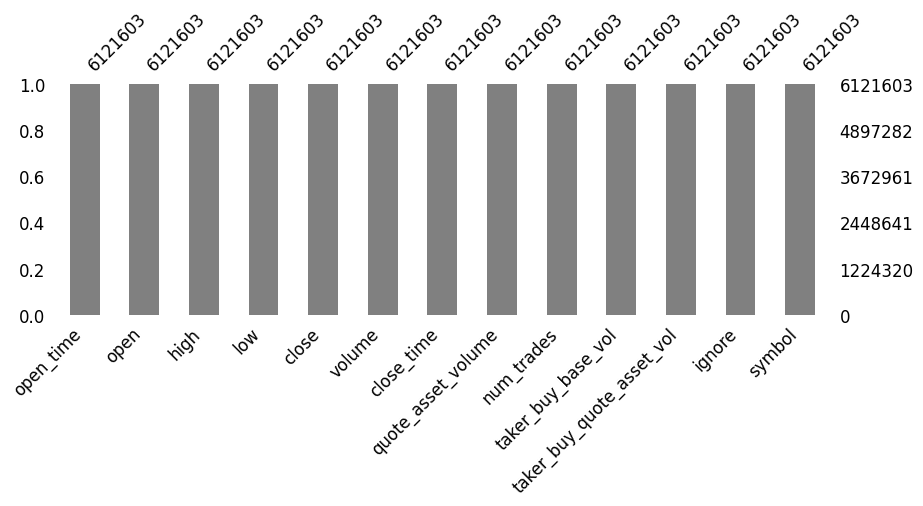

Total missing values in the dataset: 0


In [56]:
# bar chart of non-null counts
msno.bar(df_all, figsize=(10, 3), color='grey', fontsize=12, sort='ascending')
plt.show()
total_missing = df_all.isnull().sum().sum()
print(f"Total missing values in the dataset: {total_missing}")

### 2.3.3 Validation of Data Completeness by Date Range  
This step verifies that each cryptocurrency in the dataset has a complete time series covering the expected date range from 1st May 2025 to 1st August 2025. By grouping data by symbol and identifying the earliest and latest timestamps, incomplete assets can be detected and excluded from further analysis. Ensuring complete coverage is essential to maintain consistency across assets, avoid bias in time-series comparisons, and guarantee that clustering and lead-lag detection are performed on comparable datasets.

In [57]:
date_table = (df_all.groupby('symbol')['open_time'].agg(start='min', end='max').reset_index().sort_values(by=['start', 'end'], ascending=[False, True]))
date_table.head(45)

symbol                start                  end
33      BRETTUSDT  2025-07-31 11:00:00  2025-08-01 00:00:00
182       XDCUSDT  2025-07-30 11:00:00  2025-08-01 00:00:00
1    1000REKTUSDT  2025-07-24 11:00:00  2025-08-01 00:00:00
120      ONDOUSDT  2025-07-23 11:00:00  2025-08-01 00:00:00
0     1000MOGUSDT  2025-07-17 11:00:00  2025-08-01 00:00:00
11      ANIMEUSDT  2025-07-16 11:00:00  2025-08-01 00:00:00
112   MOODENGUSDT  2025-06-26 11:15:00  2025-08-01 00:00:00
135    POPCATUSDT  2025-06-25 11:15:00  2025-08-01 00:00:00
157       SPXUSDT  2025-06-19 11:00:00  2025-08-01 00:00:00
62   FARTCOINUSDT  2025-06-18 11:00:00  2025-08-01 00:00:00
56        ENAUSDT  2025-06-12 11:45:00  2025-08-01 00:00:00
94      LAYERUSDT  2025-06-12 11:00:00  2025-08-01 00:00:00
78       HYPEUSDT  2025-06-06 11:00:00  2025-08-01 00:00:00
170     TURBOUSDT  2025-05-22 11:00:00  2025-08-01 00:00:00
89      KAITOUSDT  2025-05-15 11:15:00  2025-08-01 00:00:00
7       AIXBTUSDT  2025-05-08 11:00:00  2025-08-01 00:00:00
176   VIRTUALUSDT  2025-04-29 11:30:00  2025-08-01 00:00:00
48       DATAUSDT  2025-04-10 11:00:00  2025-08-01 00:00:00
126      ORCAUSDT  2025-04-03 11:00:00  2025-08-01 00:00:00
87        JTOUSDT  2025-03-27 11:00:00  2025-08-01 00:00:00
162         SUSDT  2025-03-21 11:00:00  2025-08-01 00:00:00
88        JUPUSDT  2025-03-20 11:15:00  2025-08-01 00:00:00
109     METISUSDT  2025-03-13 12:15:00  2025-08-01 00:00:00
53          DUSDT  2025-03-07 11:00:00  2025-08-01 00:00:00
110        MEUSDT  2025-03-06 11:00:00  2025-08-01 00:00:00
55      EIGENUSDT  2025-02-27 11:00:00  2025-08-01 00:00:00
115     NEIROUSDT  2025-02-13 11:00:00  2025-08-01 00:00:00
169     TRUMPUSDT  2025-01-23 11:00:00  2025-08-01 00:00:00
132       POLUSDT  2025-01-16 12:00:00  2025-08-01 00:00:00
129     PENGUUSDT  2025-01-16 11:00:00  2025-08-01 00:00:00
131      PNUTUSDT  2025-01-09 11:00:00  2025-08-01 00:00:00
85       IOTXUSDT  2024-12-18 11:00:00  2025-08-01 00:00:00
181       WIFUSDT  2024-12-11 11:00:00  2025-08-01 00:00:00
130      PEPEUSDT  2024-12-05 11:00:00  2025-08-01 00:00:00
105     MAGICUSDT  2024-11-20 11:00:00  2025-08-01 00:00:00
31       BONKUSDT  2024-11-13 11:00:00  2025-08-01 00:00:00
143    RENDERUSDT  2024-08-22 12:00:00  2025-08-01 00:00:00
76          GUSDT  2024-08-20 11:00:00  2025-08-01 00:00:00
172      TUSDUSDT  2024-07-01 00:00:00  2024-07-31 02:45:00
72        GALUSDT  2024-07-01 00:00:00  2024-08-07 02:45:00
147      RNDRUSDT  2024-07-01 00:00:00  2024-08-14 02:45:00
44      CUDOSUSDT  2024-07-01 00:00:00  2024-09-30 02:45:00
108     MATICUSDT  2024-07-01 00:00:00  2025-01-10 01:45:00
46        DARUSDT  2024-07-01 00:00:00  2025-03-04 02:45:00
113       MXCUSDT  2024-07-01 00:00:00  2025-03-11 02:45:00

In [58]:
date_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 33 to 192
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   symbol  193 non-null    object
 1   start   193 non-null    object
 2   end     193 non-null    object
dtypes: object(3)
memory usage: 10.1+ KB


Filter Currencies which don't have a start date from 2024-07-01.

In [59]:
late_start = date_table[date_table['start'].str[:10] != "2024-07-01"]
late_start_count = len(late_start)
print("Count:", late_start_count)

symbols_list = ",".join(f"'{s}'" for s in late_start['symbol'].tolist())
print(symbols_list)

Count: 38
'BRETTUSDT','XDCUSDT','1000REKTUSDT','ONDOUSDT','1000MOGUSDT','ANIMEUSDT','MOODENGUSDT','POPCATUSDT','SPXUSDT','FARTCOINUSDT','ENAUSDT','LAYERUSDT','HYPEUSDT','TURBOUSDT','KAITOUSDT','AIXBTUSDT','VIRTUALUSDT','DATAUSDT','ORCAUSDT','JTOUSDT','SUSDT','JUPUSDT','METISUSDT','DUSDT','MEUSDT','EIGENUSDT','NEIROUSDT','TRUMPUSDT','POLUSDT','PENGUUSDT','PNUTUSDT','IOTXUSDT','WIFUSDT','PEPEUSDT','MAGICUSDT','BONKUSDT','RENDERUSDT','GUSDT'


Filter Currencies which don't have end date 2025-08-01

In [60]:
early_end = date_table[date_table['end'].str[:10] != "2025-08-01"]
early_end_count = len(early_end)
print("Count:", early_end_count)

symbols_list = ",".join(f"'{s}'" for s in early_end['symbol'].tolist())
print(symbols_list)

Count: 12
'TUSDUSDT','GALUSDT','RNDRUSDT','CUDOSUSDT','MATICUSDT','DARUSDT','MXCUSDT','RENUSDT','VITEUSDT','FTMUSDT','BALUSDT','CLVUSDT'


The cryptocurrencies below will be removed due to incomplete date range coverage.

In [61]:
df_all = df_all[~df_all['symbol'].isin(['BRETTUSDT','XDCUSDT','1000REKTUSDT','ONDOUSDT','1000MOGUSDT','ANIMEUSDT','MOODENGUSDT','POPCATUSDT', 'SPXUSDT',
                                        'FARTCOINUSDT','ENAUSDT','LAYERUSDT','HYPEUSDT','TURBOUSDT','KAITOUSDT','AIXBTUSDT','VIRTUALUSDT', 'DATAUSDT',
                                        'ORCAUSDT','JTOUSDT','SUSDT','JUPUSDT','METISUSDT','DUSDT','MEUSDT','EIGENUSDT','NEIROUSDT','TRUMPUSDT', 'POLUSDT',
                                        'PENGUUSDT','PNUTUSDT','IOTXUSDT','WIFUSDT','PEPEUSDT','MAGICUSDT','BONKUSDT','RENDERUSDT','GUSDT', 'TUSDUSDT',
                                        'GALUSDT','RNDRUSDT','CUDOSUSDT','MATICUSDT','DARUSDT','MXCUSDT','RENUSDT','VITEUSDT','FTMUSDT','BALUSDT','CLVUSDT'])]

In [62]:
print("Number of unique symbols:", df_all['symbol'].nunique())
print(df_all['symbol'].unique())

Number of unique symbols: 143
['BTCUSDT' 'ETHUSDT' 'XRPUSDT' 'SOLUSDT' 'DOGEUSDT' 'ADAUSDT' 'BNBUSDT'
 'HBARUSDT' 'FLOKIUSDT' 'SHIBUSDT' 'SUIUSDT' 'USDCUSDT' 'XLMUSDT'
 'VETUSDT' 'LTCUSDT' 'LINKUSDT' 'AVAXUSDT' 'FETUSDT' 'ONEUSDT' 'GALAUSDT'
 'DOTUSDT' 'THETAUSDT' 'VTHOUSDT' 'ALGOUSDT' 'AAVEUSDT' 'NEARUSDT'
 'UNIUSDT' 'IOTAUSDT' 'BCHUSDT' 'ATOMUSDT' 'ICPUSDT' 'KDAUSDT' 'ETCUSDT'
 'CRVUSDT' 'RVNUSDT' 'TFUELUSDT' 'LPTUSDT' 'FILUSDT' 'MANAUSDT' 'OPUSDT'
 'JAMUSDT' 'ROSEUSDT' 'GRTUSDT' 'DGBUSDT' 'APTUSDT' 'ZECUSDT' 'POLYXUSDT'
 'ZILUSDT' 'ARBUSDT' 'ENJUSDT' 'ENSUSDT' 'SUSHIUSDT' 'NEOUSDT' 'APEUSDT'
 'ACHUSDT' 'FLUXUSDT' 'ZENUSDT' 'SANDUSDT' 'IMXUSDT' 'XTZUSDT' 'MKRUSDT'
 'XNOUSDT' 'LDOUSDT' 'WAXPUSDT' 'EOSUSDT' 'ZRXUSDT' 'EGLDUSDT' 'CELOUSDT'
 'QNTUSDT' 'ICXUSDT' 'PAXGUSDT' 'STORJUSDT' 'COMPUSDT' 'BATUSDT'
 '1INCHUSDT' 'ONTUSDT' 'REEFUSDT' 'DASHUSDT' 'AXSUSDT' 'ORBSUSDT'
 'YFIUSDT' 'SLPUSDT' 'KSMUSDT' 'SNXUSDT' 'SYSUSDT' 'RAREUSDT' 'COTIUSDT'
 'AXLUSDT' 'AUDIOUSDT' 'XECUSDT' 'DIAUSDT' 'PON

In [63]:
df_all.head()

open_time      open      high       low     close   volume  \
0  2024-07-01 00:00:00  62801.81  62823.32  62617.72  62650.04  0.07645   
1  2024-07-01 00:15:00  62639.34  62753.96  62639.34  62693.17  0.03351   
2  2024-07-01 00:30:00  62700.35  62845.13  62700.35  62778.08  0.03510   
3  2024-07-01 00:45:00  62784.33  62917.13  62784.33  62900.41  2.11061   
4  2024-07-01 01:00:00  62915.98  63642.69  62876.57  63642.69  2.24363   

                close_time  quote_asset_volume  num_trades  \
0  2024-07-01 00:14:59.999         4791.696086          44   
1  2024-07-01 00:29:59.999         2101.111396          31   
2  2024-07-01 00:44:59.999         2202.987479          43   
3  2024-07-01 00:59:59.999       132768.555217          39   
4  2024-07-01 01:14:59.999       141913.010760         363   

   taker_buy_base_vol  taker_buy_quote_asset_vol  ignore   symbol  
0             0.01365                 856.261475       0  BTCUSDT  
1             0.03054                1914.912050       0  BTCUSDT  
2             0.03232                2028.625103       0  BTCUSDT  
3             2.07917              130792.967412       0  BTCUSDT  
4             1.67143              105818.062878       0  BTCUSDT

In [64]:
df_all.shape

(5436431, 13)

### 2.3.4 Closing Price Trends for BTCUSDT and ETHUSDT  
This code filters the dataset for the first two unique cryptocurrencies, converts their timestamps to a datetime index, ensures the closing prices are numeric and then plots the closing price trends over time. By iterating through each symbol, it generates individual line plots that display price fluctuations throughout the period.  

**Observation:**  
Both cryptocurrencies exhibit a broadly similar upward movement in November'24, suggesting a correlated market trend during that period, though their absolute price scales differ significantly.

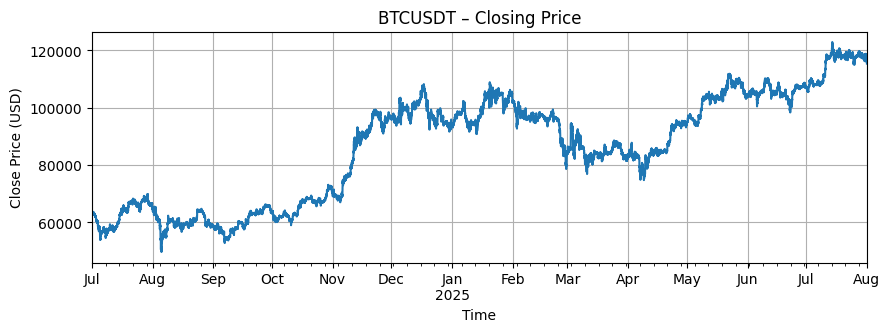

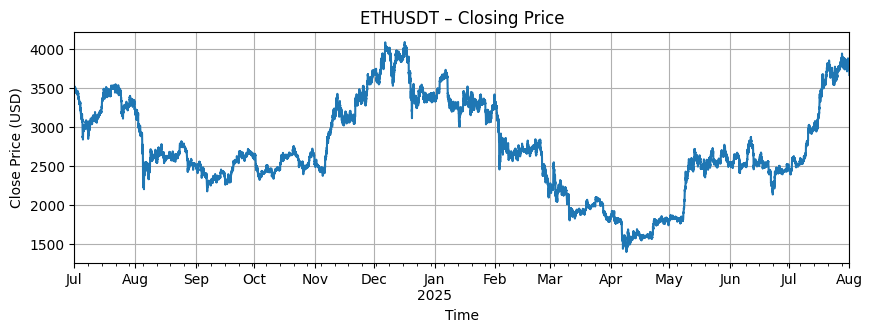

In [65]:
tickers = df_all['symbol'].drop_duplicates().head(2).tolist()
for symbol in tickers:
    sub = df_all[df_all['symbol'] == symbol].copy()
    # Parse timestamps and set index
    sub['open_time'] = pd.to_datetime(sub['open_time'])
    sub.set_index('open_time', inplace=True)
    sub['close'] = sub['close'].astype(float)
    ax = sub['close'].plot(
        figsize=(10, 3),
        title=f"{symbol} – Closing Price",
        grid=True)
    ax.set_xlabel('Time')
    ax.set_ylabel('Close Price (USD)')
    plt.show()

In [66]:
df_all.shape

(5436431, 13)

## 2.4 Primary Data  

### 2.4.1 Calculation and Integration of Log Returns into the Dataset  
This code calculates the log returns for each cryptocurrency's closing price by grouping the data by symbol and applying the natural log of the price ratio between consecutive timestamps. The resulting log returns are reset to align with the original index and merged back into the main dataset so that both the original OHLCV data and the new log_return feature are stored together.

In [67]:
returns = (df_all.sort_values(['symbol', 'open_time']).groupby('symbol')['close'].apply(lambda x: np.log(x / x.shift(1))).rename('log_return').dropna())

In [68]:
returns_df = returns.reset_index()
# Merge with df_all on both 'symbol' and index
df_with_returns = df_all.merge(returns_df, left_index=True, right_on='level_1')
# cleanup
df_with_returns.drop(columns=['level_1'], inplace=True)

In [69]:
df_with_returns.head()

open_time      open      high       low     close   volume  \
1026432  2024-07-01 00:15:00  62639.34  62753.96  62639.34  62693.17  0.03351   
1026433  2024-07-01 00:30:00  62700.35  62845.13  62700.35  62778.08  0.03510   
1026434  2024-07-01 00:45:00  62784.33  62917.13  62784.33  62900.41  2.11061   
1026435  2024-07-01 01:00:00  62915.98  63642.69  62876.57  63642.69  2.24363   
1026436  2024-07-01 01:15:00  63608.27  63608.27  63391.90  63502.21  0.03388   

                      close_time  quote_asset_volume  num_trades  \
1026432  2024-07-01 00:29:59.999         2101.111396          31   
1026433  2024-07-01 00:44:59.999         2202.987479          43   
1026434  2024-07-01 00:59:59.999       132768.555217          39   
1026435  2024-07-01 01:14:59.999       141913.010760         363   
1026436  2024-07-01 01:29:59.999         2150.233368          26   

         taker_buy_base_vol  taker_buy_quote_asset_vol  ignore symbol_x  \
1026432             0.03054                1914.912050       0  BTCUSDT   
1026433             0.03232                2028.625103       0  BTCUSDT   
1026434             2.07917              130792.967412       0  BTCUSDT   
1026435             1.67143              105818.062878       0  BTCUSDT   
1026436             0.01108                 703.924683       0  BTCUSDT   

        symbol_y  log_return  
1026432  BTCUSDT    0.000688  
1026433  BTCUSDT    0.001353  
1026434  BTCUSDT    0.001947  
1026435  BTCUSDT    0.011732  
1026436  BTCUSDT   -0.002210

The first few rows show BTCUSDT data starting from July 1, 2024, with the newly added log_return column. Small numerical values in log_return reflect minimal price changes between consecutive minutes, while zeros occur when the closing price is unchanged.

### 2.4.2 Removing Duplicate Symbol Columns after Merge  

The duplicated symbol_x and symbol_y columns are artifacts from the merge and can be cleaned up for clarity.

In [70]:
df_with_returns = df_with_returns.drop(columns=['symbol_y']).rename(columns={'symbol_x': 'symbol'})
# Verify
df_with_returns.head()

open_time      open      high       low     close   volume  \
1026432  2024-07-01 00:15:00  62639.34  62753.96  62639.34  62693.17  0.03351   
1026433  2024-07-01 00:30:00  62700.35  62845.13  62700.35  62778.08  0.03510   
1026434  2024-07-01 00:45:00  62784.33  62917.13  62784.33  62900.41  2.11061   
1026435  2024-07-01 01:00:00  62915.98  63642.69  62876.57  63642.69  2.24363   
1026436  2024-07-01 01:15:00  63608.27  63608.27  63391.90  63502.21  0.03388   

                      close_time  quote_asset_volume  num_trades  \
1026432  2024-07-01 00:29:59.999         2101.111396          31   
1026433  2024-07-01 00:44:59.999         2202.987479          43   
1026434  2024-07-01 00:59:59.999       132768.555217          39   
1026435  2024-07-01 01:14:59.999       141913.010760         363   
1026436  2024-07-01 01:29:59.999         2150.233368          26   

         taker_buy_base_vol  taker_buy_quote_asset_vol  ignore   symbol  \
1026432             0.03054                1914.912050       0  BTCUSDT   
1026433             0.03232                2028.625103       0  BTCUSDT   
1026434             2.07917              130792.967412       0  BTCUSDT   
1026435             1.67143              105818.062878       0  BTCUSDT   
1026436             0.01108                 703.924683       0  BTCUSDT   

         log_return  
1026432    0.000688  
1026433    0.001353  
1026434    0.001947  
1026435    0.011732  
1026436   -0.002210

### 2.4.3 Reordering Columns for better Readability  

This code repositions the symbol column to appear immediately after open_time for a more logical and readable dataset structure.

In [71]:
cols = ['open_time', 'symbol'] + [col for col in df_with_returns.columns if col not in ['open_time', 'symbol']]
df_with_returns = df_with_returns[cols]
# Verify
df_with_returns.head()

open_time   symbol      open      high       low     close  \
1026432  2024-07-01 00:15:00  BTCUSDT  62639.34  62753.96  62639.34  62693.17   
1026433  2024-07-01 00:30:00  BTCUSDT  62700.35  62845.13  62700.35  62778.08   
1026434  2024-07-01 00:45:00  BTCUSDT  62784.33  62917.13  62784.33  62900.41   
1026435  2024-07-01 01:00:00  BTCUSDT  62915.98  63642.69  62876.57  63642.69   
1026436  2024-07-01 01:15:00  BTCUSDT  63608.27  63608.27  63391.90  63502.21   

          volume               close_time  quote_asset_volume  num_trades  \
1026432  0.03351  2024-07-01 00:29:59.999         2101.111396          31   
1026433  0.03510  2024-07-01 00:44:59.999         2202.987479          43   
1026434  2.11061  2024-07-01 00:59:59.999       132768.555217          39   
1026435  2.24363  2024-07-01 01:14:59.999       141913.010760         363   
1026436  0.03388  2024-07-01 01:29:59.999         2150.233368          26   

         taker_buy_base_vol  taker_buy_quote_asset_vol  ignore  log_return  
1026432             0.03054                1914.912050       0    0.000688  
1026433             0.03232                2028.625103       0    0.001353  
1026434             2.07917              130792.967412       0    0.001947  
1026435             1.67143              105818.062878       0    0.011732  
1026436             0.01108                 703.924683       0   -0.002210

### 2.4.4 Data Preprocessing - Selecting Relevant Features
This code filters the dataset to retain only essential features-timestamps, asset identifiers, OHLC prices, trading volume and log returns - ensuring that subsequent stationarity testing, DTW clustering, lead-lag identification and LSTM forecasting are performed on relevant variables only. Limiting the dataset to these fields reduces memory usage and improves computational efficiency.

In [72]:
# Define the columns to keep
keep_cols = [
    'open_time',
    'symbol',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'log_return']
df_with_returns = df_with_returns[keep_cols].copy()
df_with_returns['open_time'] = pd.to_datetime(df_with_returns['open_time'])
# Verify
df_with_returns.head()

open_time   symbol      open      high       low     close  \
1026432 2024-07-01 00:15:00  BTCUSDT  62639.34  62753.96  62639.34  62693.17   
1026433 2024-07-01 00:30:00  BTCUSDT  62700.35  62845.13  62700.35  62778.08   
1026434 2024-07-01 00:45:00  BTCUSDT  62784.33  62917.13  62784.33  62900.41   
1026435 2024-07-01 01:00:00  BTCUSDT  62915.98  63642.69  62876.57  63642.69   
1026436 2024-07-01 01:15:00  BTCUSDT  63608.27  63608.27  63391.90  63502.21   

          volume  log_return  
1026432  0.03351    0.000688  
1026433  0.03510    0.001353  
1026434  2.11061    0.001947  
1026435  2.24363    0.011732  
1026436  0.03388   -0.002210

### 2.4.7 Checkpoint: Downloading Primary Data onto Google Drive  

In [73]:
csv_path = '/content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/Primary_data_15min.csv'

In [74]:
df_with_returns.to_csv(csv_path, index=False)
print(f"CSV successfully saved to: {csv_path}")

CSV successfully saved to: /content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/Primary_data_15min.csv


### 2.4.8 Load Primary Data back into the Notebook

In [75]:
primary_data_df = pd.read_csv(csv_path)
print(f"Loaded shape: {primary_data_df.shape}")
primary_data_df.head()

Loaded shape: (5436288, 8)


open_time   symbol      open      high       low     close  \
0  2024-07-01 00:15:00  BTCUSDT  62639.34  62753.96  62639.34  62693.17   
1  2024-07-01 00:30:00  BTCUSDT  62700.35  62845.13  62700.35  62778.08   
2  2024-07-01 00:45:00  BTCUSDT  62784.33  62917.13  62784.33  62900.41   
3  2024-07-01 01:00:00  BTCUSDT  62915.98  63642.69  62876.57  63642.69   
4  2024-07-01 01:15:00  BTCUSDT  63608.27  63608.27  63391.90  63502.21   

    volume  log_return  
0  0.03351    0.000688  
1  0.03510    0.001353  
2  2.11061    0.001947  
3  2.24363    0.011732  
4  0.03388   -0.002210

In [76]:
primary_data_df.shape

(5436288, 8)

# 3 Data Preparation

## 3.1 Data Preparation of the 15 minute interval dataset  
This code restructures the dataset into a time-series matrix where each column represents a cryptocurrency and each row corresponds to a timestamp, with cell values showing log returns. This transposed format is suitable for DTW input.

In [77]:
returns_matrix = primary_data_df.pivot(index='open_time', columns='symbol', values='log_return')
returns_matrix = returns_matrix.dropna()  # drop timestamps with missing returns
returns_matrix.head()

symbol               1INCHUSDT  AAVEUSDT   ACHUSDT   ADAUSDT  ADXUSDT  \
open_time                                                               
2024-07-01 00:15:00   0.000000  0.000000  0.000000  0.003055      0.0   
2024-07-01 00:30:00   0.000000  0.000000  0.002567  0.001270      0.0   
2024-07-01 00:45:00   0.000000  0.000000  0.000000 -0.002796      0.0   
2024-07-01 01:00:00   0.000000  0.000000  0.006390  0.008366      0.0   
2024-07-01 01:15:00   0.008456  0.011252  0.008878  0.007044      0.0   

symbol               ALGOUSDT  ALICEUSDT  ALPINEUSDT  ANKRUSDT   APEUSDT  ...  \
open_time                                                                 ...   
2024-07-01 00:15:00  0.001389    0.00000         0.0  0.000000  0.000000  ...   
2024-07-01 00:30:00 -0.006964    0.00000         0.0  0.000000  0.000000  ...   
2024-07-01 00:45:00  0.006270    0.00000         0.0  0.000000  0.000000  ...   
2024-07-01 01:00:00  0.009675    0.01088         0.0  0.000000  0.000000  ...   
2024-07-01 01:15:00  0.003433    0.00000         0.0  0.018214  0.007125  ...   

symbol               XECUSDT   XLMUSDT  XNOUSDT   XRPUSDT   XTZUSDT  YFIUSDT  \
open_time                                                                      
2024-07-01 00:15:00      0.0 -0.005498      0.0  0.000000  0.000000      0.0   
2024-07-01 00:30:00      0.0  0.005498      0.0  0.000000  0.000000      0.0   
2024-07-01 00:45:00      0.0 -0.002195      0.0  0.000840  0.000000      0.0   
2024-07-01 01:00:00      0.0  0.005479      0.0  0.002934 -0.003785      0.0   
2024-07-01 01:15:00      0.0  0.002183      0.0  0.001881  0.000000      0.0   

symbol                ZECUSDT   ZENUSDT   ZILUSDT   ZRXUSDT  
open_time                                                    
2024-07-01 00:15:00  0.000963  0.000000  0.009629 -0.015137  
2024-07-01 00:30:00 -0.001445  0.000000 -0.006220  0.000000  
2024-07-01 00:45:00 -0.010664  0.000000  0.001134  0.000000  
2024-07-01 01:00:00  0.024074  0.005997  0.000000  0.031931  
2024-07-01 01:15:00 -0.003336  0.000000  0.000000  0.000000  

[5 rows x 143 columns]

In [78]:
returns_matrix.shape

(38016, 143)

### 3.1.2 Examination of Zero-Return Prevalence  

The procedure quantifies the frequency and proportion of exact zero returns across assets, providing insight into data sparsity and its potential impact on model performance.

In [79]:
df = returns_matrix
zero_cnt_15m   = (df == 0).sum(axis=0)
zero_share_15m = zero_cnt_15m / len(df)
zero_table_15m = pd.DataFrame({"zero_count": zero_cnt_15m, "zero_share_15m": zero_share_15m}).sort_values("zero_share_15m", ascending=True)
zero_table_15m.head(25)

zero_count  zero_share_15m
symbol                               
BTCUSDT           357        0.009391
ETHUSDT           819        0.021544
SOLUSDT          1917        0.050426
XRPUSDT          2206        0.058028
ADAUSDT          2973        0.078204
DOGEUSDT         3640        0.095749
BNBUSDT          3908        0.102799
AVAXUSDT         8272        0.217593
LTCUSDT          8418        0.221433
LINKUSDT         8419        0.221459
SHIBUSDT         9416        0.247685
XLMUSDT         10261        0.269913
SUIUSDT         11470        0.301715
HBARUSDT        12382        0.325705
FLOKIUSDT       12842        0.337805
VETUSDT         13285        0.349458
FETUSDT         13991        0.368029
DOTUSDT         14711        0.386969
USDCUSDT        15510        0.407986
GALAUSDT        15968        0.420034
ATOMUSDT        16383        0.430950
ICXUSDT         16879        0.443997
OPUSDT          17850        0.469539
ALGOUSDT        18080        0.475589
NEARUSDT        18266        0.480482

### 3.1.3 Filtering Assets by Near-Zero Prevalence  

Assets with excessive proportions of exact or near-zero returns are systematically excluded, ensuring that only series with sufficient variability are retained for meaningful forecasting analysis.

In [80]:
eps = 1e-4
near_zero_cnt_15m   = (returns_matrix.abs() <= eps).sum(axis=0)
near_zero_share_15m = near_zero_cnt_15m / len(returns_matrix)
near_zero_table_15m = ((returns_matrix.abs() <= eps).agg(['sum', 'mean']).T.rename(columns={'sum': 'near_zero_count_15m', 'mean': 'near_zero_share_15m'}).sort_values('near_zero_share_15m'))
near_zero_table_15m.head(25)

near_zero_count_15m  near_zero_share_15m
symbol                                             
ETHUSDT                 2112.0             0.055556
BTCUSDT                 2506.0             0.065920
SOLUSDT                 2542.0             0.066867
XRPUSDT                 2697.0             0.070944
ADAUSDT                 3025.0             0.079572
DOGEUSDT                4158.0             0.109375
BNBUSDT                 4902.0             0.128946
AVAXUSDT                8272.0             0.217593
LINKUSDT                8511.0             0.223879
LTCUSDT                 8578.0             0.225642
SHIBUSDT                9416.0             0.247685
XLMUSDT                10261.0             0.269913
SUIUSDT                11854.0             0.311816
HBARUSDT               12585.0             0.331045
FLOKIUSDT              13038.0             0.342961
VETUSDT                13285.0             0.349458
FETUSDT                13991.0             0.368029
DOTUSDT                14721.0             0.387232
GALAUSDT               15968.0             0.420034
ATOMUSDT               16385.0             0.431003
ICXUSDT                16879.0             0.443997
OPUSDT                 17850.0             0.469539
ALGOUSDT               18080.0             0.475589
NEARUSDT               18266.0             0.480482
IOTAUSDT               18302.0             0.481429

### 3.1.4 Applying Zero-Tolerance Thresholds  
By setting a 10% threshold for zero and near-zero returns, the analysis balances data quality with asset coverage, retaining only series with sufficient variability to support meaningful modelling. Stricter thresholds were considered, but values above 10% risked excessive data loss and reduced representativeness of the cryptocurrency market.

In [81]:
keep = (zero_share_15m < 0.1) & (near_zero_share_15m < 0.1)
symbols_keep = df.columns[keep].tolist()
symbols_drop = df.columns[~keep].tolist()

print(f"Keep: {len(symbols_keep)}  |  Drop: {len(symbols_drop)}")
print("Examples to drop:", symbols_drop[:20])
print("Examples to keep:", symbols_keep[:15])

Keep: 5  |  Drop: 138
Examples to drop: ['1INCHUSDT', 'AAVEUSDT', 'ACHUSDT', 'ADXUSDT', 'ALGOUSDT', 'ALICEUSDT', 'ALPINEUSDT', 'ANKRUSDT', 'APEUSDT', 'API3USDT', 'APTUSDT', 'ARBUSDT', 'ASTRUSDT', 'ATOMUSDT', 'AUDIOUSDT', 'AVAXUSDT', 'AXLUSDT', 'AXSUSDT', 'BANDUSDT', 'BATUSDT']
Examples to keep: ['ADAUSDT', 'BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT']


The next stage of the analysis will extend this zero-tolerance filtering to 30-minute interval data in order to examine whether a broader temporal aggregation produces a more stable set of assets compared to the 15-minute results.

## 3.2 Resampling Returns Data to 30-Minute Intervals  
The time-series matrix is resampled from its original 15-minute granularity to 30-minute intervals, using the mean of returns within each half-hour window. This aggregation reduces noise and allows exploration of whether broader temporal spacing improves the stability and interpretability of subsequent analyses.

### 3.2.1 Load ```df_all``` from Google Drive

In [82]:
csv_path = '/content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/Primary_data_15min.csv'
primary_data_15m = pd.read_csv(csv_path)
primary_data_15m = primary_data_15m.sort_values(["symbol", "open_time"]).reset_index(drop=True)
print(f"Shape: {primary_data_15m.shape}")
primary_data_15m.head()

Shape: (5436288, 8)


open_time     symbol    open    high     low   close  volume  \
0  2024-07-01 00:15:00  1INCHUSDT  0.4004  0.4004  0.4004  0.4004     0.0   
1  2024-07-01 00:30:00  1INCHUSDT  0.4004  0.4004  0.4004  0.4004     0.0   
2  2024-07-01 00:45:00  1INCHUSDT  0.4004  0.4004  0.4004  0.4004     0.0   
3  2024-07-01 01:00:00  1INCHUSDT  0.4004  0.4004  0.4004  0.4004     0.0   
4  2024-07-01 01:15:00  1INCHUSDT  0.4038  0.4038  0.4038  0.4038   197.9   

   log_return  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.008456

### 3.2.2 Resample Returns Data to 30-Minute Intervals

In [83]:
primary_data_15m["open_time"] = pd.to_datetime(primary_data_15m["open_time"])
agg_map = {'open': 'first', 'high': 'max', 'low':  'min', 'close': 'last', 'volume': 'sum'}

df_30m = (primary_data_15m.groupby(["symbol", pd.Grouper(key="open_time", freq="30min")]).agg(agg_map).dropna(subset=[c for c in ["open","high","low","close"] if c in agg_map])  # keep full OHLC rows
          .reset_index().sort_values(["symbol", "open_time"]))
keep_cols = ["symbol", "open_time"] + list(agg_map.keys())
df_30m = df_30m[keep_cols]
df_30m.head()

symbol           open_time    open    high     low   close  volume
0  1INCHUSDT 2024-07-01 00:00:00  0.4004  0.4004  0.4004  0.4004     0.0
1  1INCHUSDT 2024-07-01 00:30:00  0.4004  0.4004  0.4004  0.4004     0.0
2  1INCHUSDT 2024-07-01 01:00:00  0.4004  0.4038  0.4004  0.4038   197.9
3  1INCHUSDT 2024-07-01 01:30:00  0.4038  0.4038  0.4038  0.4038     0.0
4  1INCHUSDT 2024-07-01 02:00:00  0.4038  0.4038  0.4038  0.4038     0.0

In [84]:
df_30m.shape

(2718287, 7)

### 3.2.3 Calculate Log Returns from the 30-Minute Intervals Dataset

In [85]:
df_30m = df_30m.set_index(['symbol','open_time']).sort_index()
df_30m['log_return'] = np.log(df_30m['close']).groupby(level=0).diff()
df_30m = df_30m.dropna(subset=['log_return']).reset_index()
df_30m.head()

symbol           open_time    open    high     low   close  volume  \
0  1INCHUSDT 2024-07-01 00:30:00  0.4004  0.4004  0.4004  0.4004     0.0   
1  1INCHUSDT 2024-07-01 01:00:00  0.4004  0.4038  0.4004  0.4038   197.9   
2  1INCHUSDT 2024-07-01 01:30:00  0.4038  0.4038  0.4038  0.4038     0.0   
3  1INCHUSDT 2024-07-01 02:00:00  0.4038  0.4038  0.4038  0.4038     0.0   
4  1INCHUSDT 2024-07-01 02:30:00  0.4038  0.4038  0.4038  0.4038     0.0   

   log_return  
0    0.000000  
1    0.008456  
2    0.000000  
3    0.000000  
4    0.000000

### 3.2.4 Pivot to a returns matrix at 30-min granularity

In [86]:
returns_matrix_30m = (df_30m.pivot(index='open_time', columns='symbol', values='log_return').sort_index().dropna())
returns_matrix_30m.head()

symbol               1INCHUSDT  AAVEUSDT   ACHUSDT   ADAUSDT  ADXUSDT  \
open_time                                                               
2024-07-01 00:30:00   0.000000  0.000000  0.002567 -0.001526      0.0   
2024-07-01 01:00:00   0.008456  0.011252  0.015267  0.015410      0.0   
2024-07-01 01:30:00   0.000000 -0.009281  0.000000  0.000251      0.0   
2024-07-01 02:00:00   0.000000  0.014094  0.000000  0.002003      0.0   
2024-07-01 02:30:00   0.000000 -0.014094 -0.000842 -0.002254      0.0   

symbol               ALGOUSDT  ALICEUSDT  ALPINEUSDT  ANKRUSDT   APEUSDT  ...  \
open_time                                                                 ...   
2024-07-01 00:30:00 -0.000694   0.000000         0.0  0.000000  0.000000  ...   
2024-07-01 01:00:00  0.013108   0.010880         0.0  0.018214  0.007125  ...   
2024-07-01 01:30:00 -0.001372   0.016101         0.0  0.000000  0.000000  ...   
2024-07-01 02:00:00  0.007521   0.000000         0.0 -0.023063 -0.007125  ...   
2024-07-01 02:30:00  0.000000   0.000000         0.0  0.000000  0.000000  ...   

symbol                XECUSDT   XLMUSDT  XNOUSDT   XRPUSDT   XTZUSDT  YFIUSDT  \
open_time                                                                       
2024-07-01 00:30:00  0.000000  0.003302  0.00000  0.000840  0.000000      0.0   
2024-07-01 01:00:00  0.000000  0.007663  0.00000  0.004815 -0.003785      0.0   
2024-07-01 01:30:00  0.000000  0.008686  0.03859  0.000835  0.012563      0.0   
2024-07-01 02:00:00  0.000000  0.001080  0.00000 -0.001253 -0.008777      0.0   
2024-07-01 02:30:00  0.037999  0.001079  0.00000 -0.000836  0.000000      0.0   

symbol                ZECUSDT   ZENUSDT   ZILUSDT   ZRXUSDT  
open_time                                                    
2024-07-01 00:30:00 -0.012110  0.000000 -0.005086  0.000000  
2024-07-01 01:00:00  0.020739  0.005997  0.000000  0.031931  
2024-07-01 01:30:00 -0.008629  0.013363  0.019636  0.000000  
2024-07-01 02:00:00 -0.007248  0.000000 -0.012860  0.000000  
2024-07-01 02:30:00  0.000000  0.000000  0.000000  0.000000  

[5 rows x 143 columns]

In [87]:
returns_matrix_30m.shape

(19008, 143)

### 3.2.5 Examination of Zero-Return Prevalence  

The procedure quantifies the frequency and proportion of exact zero returns across assets, providing insight into data sparsity and its potential impact on model performance.

In [88]:
df = returns_matrix_30m
zero_cnt_30m   = (df == 0).sum(axis=0)
zero_share_30m = zero_cnt_30m / len(df)
zero_table_30m = pd.DataFrame({"zero_count_30m": zero_cnt_30m, "zero_share_30m": zero_share_30m}).sort_values("zero_share_30m", ascending=True)
zero_table_30m.head(25)

zero_count_30m  zero_share_30m
symbol                                   
BTCUSDT                40        0.002104
ETHUSDT                70        0.003683
SOLUSDT               251        0.013205
XRPUSDT               398        0.020939
ADAUSDT               544        0.028620
DOGEUSDT              550        0.028935
BNBUSDT               625        0.032881
LTCUSDT              1713        0.090120
AVAXUSDT             1973        0.103798
LINKUSDT             2054        0.108060
SHIBUSDT             2466        0.129735
XLMUSDT              2774        0.145939
SUIUSDT              3106        0.163405
VETUSDT              3489        0.183554
HBARUSDT             3689        0.194076
DOTUSDT              4025        0.211753
FLOKIUSDT            4139        0.217750
FETUSDT              4369        0.229851
GALAUSDT             4633        0.243739
ATOMUSDT             4728        0.248737
USDCUSDT             5277        0.277620
ICXUSDT              5404        0.284301
ONEUSDT              5792        0.304714
NEARUSDT             5817        0.306029
ALGOUSDT             5895        0.310133

### 3.2.6 Filtering Assets by Near-Zero Prevalence  

Assets with excessive proportions of exact or near-zero returns are systematically excluded, ensuring that only series with sufficient variability are retained for meaningful forecasting analysis.

In [89]:
rets = returns_matrix_30m
eps = 1e-4
near_zero_share_30m = (rets.abs() <= eps).mean(axis=0)
near_zero_table_30m = ((returns_matrix_30m.abs() <= eps).agg(['sum', 'mean']).T.rename(columns={'sum': 'near_zero_count_30m', 'mean': 'near_zero_share_30m'}).sort_values('near_zero_share_30m'))
near_zero_table_30m.head(25)

near_zero_count_30m  near_zero_share_30m
symbol                                             
SOLUSDT                  482.0             0.025358
ETHUSDT                  513.0             0.026989
ADAUSDT                  557.0             0.029303
XRPUSDT                  591.0             0.031092
BTCUSDT                  726.0             0.038194
DOGEUSDT                 734.0             0.038615
BNBUSDT                 1005.0             0.052872
LTCUSDT                 1759.0             0.092540
AVAXUSDT                1973.0             0.103798
LINKUSDT                2095.0             0.110217
SHIBUSDT                2466.0             0.129735
XLMUSDT                 2774.0             0.145939
SUIUSDT                 3268.0             0.171928
VETUSDT                 3489.0             0.183554
HBARUSDT                3748.0             0.197180
DOTUSDT                 4027.0             0.211858
FLOKIUSDT               4217.0             0.221854
FETUSDT                 4369.0             0.229851
GALAUSDT                4633.0             0.243739
ATOMUSDT                4729.0             0.248790
ICXUSDT                 5404.0             0.284301
ONEUSDT                 5792.0             0.304714
NEARUSDT                5817.0             0.306029
ALGOUSDT                5895.0             0.310133
OPUSDT                  6010.0             0.316183

### 3.2.7 Applying Zero-Tolerance Thresholds  
By tightening the thresholds for both exact zeros and near-zero returns, the filtering process becomes more rigorous, ensuring that only assets with sufficient variability are retained.

In [90]:
keep = (zero_share_30m < 0.1) & (near_zero_share_30m < 0.1)
symbols_keep = rets.columns[keep].tolist()
symbols_drop = rets.columns[~keep].tolist()

print(f"Keep: {len(symbols_keep)}  |  Drop: {len(symbols_drop)}")
print("Examples to drop:", symbols_drop[:15])
print("Examples to keep:", symbols_keep[:15])

Keep: 8  |  Drop: 135
Examples to drop: ['1INCHUSDT', 'AAVEUSDT', 'ACHUSDT', 'ADXUSDT', 'ALGOUSDT', 'ALICEUSDT', 'ALPINEUSDT', 'ANKRUSDT', 'APEUSDT', 'API3USDT', 'APTUSDT', 'ARBUSDT', 'ASTRUSDT', 'ATOMUSDT', 'AUDIOUSDT']
Examples to keep: ['ADAUSDT', 'BNBUSDT', 'BTCUSDT', 'DOGEUSDT', 'ETHUSDT', 'LTCUSDT', 'SOLUSDT', 'XRPUSDT']


The filtering process based on zero and near-zero prevalence resulted in the retention of only eight assets, highlighting the considerable variability in trading activity across the dataset. This imbalance poses a potential challenge for multi-asset forecasting, as assets with higher proportions of zero returns contribute less predictive information. To address this, the subsequent stage of the analysis will re-evaluate the filtering criteria using 1-hour intervals to determine whether broader temporal aggregation reduces zero prevalence and yields a more stable asset set.

## 3.3 Resampling Returns Data to 1-Hour Intervals  

The time-series matrix is further resampled to 1-hour intervals, averaging returns within each window. This broader temporal spacing is expected to reduce noise and reveal whether coarser aggregation improves stability and interpretability.

### 3.3.1 Reload ```primary_data_15m```

In [91]:
primary_data_15m.head()

open_time     symbol    open    high     low   close  volume  \
0 2024-07-01 00:15:00  1INCHUSDT  0.4004  0.4004  0.4004  0.4004     0.0   
1 2024-07-01 00:30:00  1INCHUSDT  0.4004  0.4004  0.4004  0.4004     0.0   
2 2024-07-01 00:45:00  1INCHUSDT  0.4004  0.4004  0.4004  0.4004     0.0   
3 2024-07-01 01:00:00  1INCHUSDT  0.4004  0.4004  0.4004  0.4004     0.0   
4 2024-07-01 01:15:00  1INCHUSDT  0.4038  0.4038  0.4038  0.4038   197.9   

   log_return  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.008456

### 3.3.2 Resample Returns Data to 1-Hour Intervals

In [92]:
agg_map = {'open': 'first', 'high': 'max', 'low':  'min', 'close': 'last', 'volume': 'sum'}
df_1H = (primary_data_15m.groupby(["symbol", pd.Grouper(key="open_time", freq="1H")]).agg(agg_map).dropna(subset=[c for c in ["open","high","low","close"] if c in agg_map])  # keep full OHLC rows
          .reset_index().sort_values(["symbol", "open_time"]))
keep_cols = ["symbol", "open_time"] + list(agg_map.keys())
df_1H = df_1H[keep_cols]
df_1H.head()

symbol           open_time    open    high     low   close  volume
0  1INCHUSDT 2024-07-01 00:00:00  0.4004  0.4004  0.4004  0.4004     0.0
1  1INCHUSDT 2024-07-01 01:00:00  0.4004  0.4038  0.4004  0.4038   197.9
2  1INCHUSDT 2024-07-01 02:00:00  0.4038  0.4038  0.4038  0.4038     0.0
3  1INCHUSDT 2024-07-01 03:00:00  0.4038  0.4038  0.4038  0.4038     0.0
4  1INCHUSDT 2024-07-01 04:00:00  0.4038  0.4038  0.4038  0.4038     0.0

In [93]:
df_1H.shape

(1359215, 7)

### 3.3.3 Calculate Log Returns from the 1-Hour Intervals Dataset

In [94]:
df_1H = df_1H.set_index(['symbol','open_time']).sort_index()
df_1H['log_return'] = np.log(df_1H['close']).groupby(level=0).diff()
df_1H = df_1H.dropna(subset=['log_return']).reset_index()
df_1H.head()

symbol           open_time    open    high     low   close  volume  \
0  1INCHUSDT 2024-07-01 01:00:00  0.4004  0.4038  0.4004  0.4038   197.9   
1  1INCHUSDT 2024-07-01 02:00:00  0.4038  0.4038  0.4038  0.4038     0.0   
2  1INCHUSDT 2024-07-01 03:00:00  0.4038  0.4038  0.4038  0.4038     0.0   
3  1INCHUSDT 2024-07-01 04:00:00  0.4038  0.4038  0.4038  0.4038     0.0   
4  1INCHUSDT 2024-07-01 05:00:00  0.4038  0.4038  0.4038  0.4038     0.0   

   log_return  
0    0.008456  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.000000

### 3.3.4 Pivot to a returns matrix at 1-hour granularity

In [95]:
returns_matrix_1H = (df_1H.pivot(index='open_time', columns='symbol', values='log_return').sort_index().dropna())
returns_matrix_1H.head()

symbol               1INCHUSDT  AAVEUSDT   ACHUSDT   ADAUSDT  ADXUSDT  \
open_time                                                               
2024-07-01 01:00:00   0.008456  0.001970  0.015267  0.015661      0.0   
2024-07-01 02:00:00   0.000000  0.000000 -0.000842 -0.000251      0.0   
2024-07-01 03:00:00   0.000000  0.012049  0.022080  0.001753      0.0   
2024-07-01 04:00:00   0.000000  0.000000 -0.014526 -0.001252      0.0   
2024-07-01 05:00:00   0.000000  0.000000  0.000000 -0.002760      0.0   

symbol               ALGOUSDT  ALICEUSDT  ALPINEUSDT  ANKRUSDT   APEUSDT  ...  \
open_time                                                                 ...   
2024-07-01 01:00:00  0.011736    0.02698         0.0  0.018214  0.007125  ...   
2024-07-01 02:00:00  0.007521    0.00000         0.0 -0.023063 -0.007125  ...   
2024-07-01 03:00:00  0.006112    0.00000         0.0  0.001295  0.000000  ...   
2024-07-01 04:00:00  0.002705    0.00000         0.0  0.018914 -0.008205  ...   
2024-07-01 05:00:00  0.003370    0.00000         0.0  0.000000  0.013299  ...   

symbol                XECUSDT   XLMUSDT   XNOUSDT   XRPUSDT   XTZUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.000000  0.016349  0.038590  0.005650  0.008777   
2024-07-01 02:00:00  0.037999  0.002160  0.000000 -0.002089 -0.008777   
2024-07-01 03:00:00  0.000000 -0.002160  0.000000  0.001254  0.013759   
2024-07-01 04:00:00  0.000000  0.000000  0.000000 -0.000627  0.000000   
2024-07-01 05:00:00  0.000000 -0.004334 -0.021255  0.000836 -0.004981   

symbol                YFIUSDT   ZECUSDT  ZENUSDT   ZILUSDT   ZRXUSDT  
open_time                                                             
2024-07-01 01:00:00  0.000000  0.012110  0.01936  0.019636  0.031931  
2024-07-01 02:00:00  0.000000 -0.007248  0.00000 -0.012860  0.000000  
2024-07-01 03:00:00  0.000000 -0.007301  0.00000  0.011192  0.000000  
2024-07-01 04:00:00 -0.008012  0.010207  0.00000 -0.006700  0.000000  
2024-07-01 05:00:00  0.000000 -0.000484  0.00000  0.000000  0.000000  

[5 rows x 143 columns]

In [96]:
returns_matrix_1H.shape

(9504, 143)

### 3.3.5 Examination of Zero-Return Prevalence  

The procedure quantifies the frequency and proportion of exact zero returns across assets, providing insight into data sparsity and its potential impact on model performance.

In [97]:
df = returns_matrix_1H
zero_cnt_1H   = (df == 0).sum(axis=0)
zero_share_1H = zero_cnt_1H / len(df)
zero_table_1H = pd.DataFrame({"zero_count_1H": zero_cnt_1H, "zero_share_1H": zero_share_1H}).sort_values("zero_share_1H", ascending=True)
zero_table_1H.head(20)

zero_count_1H  zero_share_1H
symbol                                 
BTCUSDT                5       0.000526
ETHUSDT               10       0.001052
SOLUSDT               46       0.004840
XRPUSDT               78       0.008207
DOGEUSDT              90       0.009470
BNBUSDT              115       0.012100
ADAUSDT              149       0.015678
LTCUSDT              283       0.029777
AVAXUSDT             402       0.042298
LINKUSDT             431       0.045349
SHIBUSDT             573       0.060290
XLMUSDT              638       0.067130
SUIUSDT              650       0.068392
VETUSDT              709       0.074600
DOTUSDT              785       0.082597
HBARUSDT             907       0.095434
ATOMUSDT             966       0.101641
GALAUSDT            1002       0.105429
FLOKIUSDT           1123       0.118161
FETUSDT             1166       0.122685

### 3.3.6 Filtering Assets by Near-Zero Prevalence  

Assets with excessive proportions of exact or near-zero returns are systematically excluded, ensuring that only series with sufficient variability are retained for meaningful forecasting analysis.

In [98]:
rets = returns_matrix_1H
eps = 1e-4
near_zero_share_1H = (rets.abs() <= eps).mean(axis=0)
near_zero_table_1H = ((returns_matrix_1H.abs() <= eps).agg(['sum', 'mean']).T.rename(columns={'sum': 'near_zero_count_1H', 'mean': 'near_zero_share_1H'}).sort_values('near_zero_share_1H'))
near_zero_table_1H.head(20)

near_zero_count_1H  near_zero_share_1H
symbol                                           
XRPUSDT                 138.0            0.014520
SOLUSDT                 139.0            0.014625
ADAUSDT                 153.0            0.016098
DOGEUSDT                170.0            0.017887
ETHUSDT                 174.0            0.018308
BNBUSDT                 254.0            0.026726
BTCUSDT                 264.0            0.027778
LTCUSDT                 302.0            0.031776
AVAXUSDT                402.0            0.042298
LINKUSDT                450.0            0.047348
SHIBUSDT                573.0            0.060290
XLMUSDT                 638.0            0.067130
SUIUSDT                 701.0            0.073758
VETUSDT                 709.0            0.074600
DOTUSDT                 786.0            0.082702
HBARUSDT                937.0            0.098590
ATOMUSDT                966.0            0.101641
GALAUSDT               1002.0            0.105429
FLOKIUSDT              1154.0            0.121423
FETUSDT                1166.0            0.122685

### 3.3.7 Applying Zero-Tolerance Thresholds  
By tightening the thresholds for both exact zeros and near-zero returns, the filtering process becomes more rigorous, ensuring that only assets with sufficient variability are retained. As a result, the selection is narrowed down substantially, leaving just seven assets that meet the stricter criteria.

In [99]:
keep = (zero_share_1H < 0.10) & (near_zero_share_1H < 0.10)
symbols_keep = rets.columns[keep].tolist()
symbols_drop = rets.columns[~keep].tolist()

print(f"Keep: {len(symbols_keep)}  |  Drop: {len(symbols_drop)}")
print("Examples to drop:", symbols_drop[:15])
print("Examples to keep:", symbols_keep[:15])

Keep: 16  |  Drop: 127
Examples to drop: ['1INCHUSDT', 'AAVEUSDT', 'ACHUSDT', 'ADXUSDT', 'ALGOUSDT', 'ALICEUSDT', 'ALPINEUSDT', 'ANKRUSDT', 'APEUSDT', 'API3USDT', 'APTUSDT', 'ARBUSDT', 'ASTRUSDT', 'ATOMUSDT', 'AUDIOUSDT']
Examples to keep: ['ADAUSDT', 'AVAXUSDT', 'BNBUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'ETHUSDT', 'HBARUSDT', 'LINKUSDT', 'LTCUSDT', 'SHIBUSDT', 'SOLUSDT', 'SUIUSDT', 'VETUSDT', 'XLMUSDT']


By extending the interval to 1 hour, the overall prevalence of zero and near-zero returns was reduced, producing a more stable dataset. Even under a stricter 10% tolerance threshold, sixteen assets were retained. This reflects the balance required in the study: while high-frequency data are desirable to capture potential lead-lag dynamics in a highly volatile environment, their excessive zero prevalence limits their usefulness. The shift to 1-hour intervals therefore represents a compromise that maintains analytical robustness while preserving a sufficient pool of viable assets for subsequent stages.

### 3.3.8 Retention of Assets Across Sampling Intervals  

This code evaluates how many cryptocurrency assets remain viable under a 10% zero/near-zero return threshold across 15-minute, 30-minute, and 1-hour intervals. By quantifying and visualising asset retention, it demonstrates how increasing the sampling interval reduces sparsity and preserves more assets for clustering and forecasting analysis.

In [100]:
share_table = pd.concat([zero_share_15m.rename("Zero Share (15m)"), near_zero_share_15m.rename("Near-Zero Share (15m)"),
                         zero_share_30m.rename("Zero Share (30m)"), near_zero_share_30m.rename("Near-Zero Share (30m)"),
                         zero_share_1H.rename("Zero Share (1H)"), near_zero_share_1H.rename("Near-Zero Share (1H)")], axis=1)
#Convert to percentages and round
share_table = (share_table * 100).round(2)
top10 = share_table.sort_values("Zero Share (1H)", ascending=True).head()
# Add formatting with % signs
fmt_cols = ["Zero Share (1H)", "Near-Zero Share (1H)", "Zero Share (30m)", "Near-Zero Share (30m)", "Zero Share (15m)", "Near-Zero Share (15m)"]
top10.style.format({c: "{:.2f}%" for c in fmt_cols})

### 3.3.9 Visualisation: Impact of Sampling Interval on Asset Retention  

The visualisation illustrates how increasing the sampling interval from 15 minutes to 1 hour reduces sparsity and enables more assets to remain below the 10% threshold. Presenting the retention counts side by side makes the effect of interval selection clearer and more interpretable for subsequent methodological decisions.

In [102]:
threshold = 10.0
# Map intervals to their share columns
cols = {"15 minute": ("Zero Share (15m)", "Near-Zero Share (15m)"),
        "30 minute": ("Zero Share (30m)", "Near-Zero Share (30m)"),
        "1 Hour":    ("Zero Share (1H)",  "Near-Zero Share (1H)")}
# compact retention rows
rows = []
for interval, (zero_col, near_col) in cols.items():
    for typ, col in (("Zero", zero_col), ("Near-Zero", near_col)):
        idx = share_table.index[share_table[col] < threshold]
        rows.append({"Interval": interval, "Type": typ, "Count": idx.size, "Assets": ", ".join(idx)})
retention_df = pd.DataFrame(rows)
fig = px.bar(retention_df, x="Interval", y="Count", color="Type", text="Count", hover_data={"Assets": True, "Interval": False, "Count": False},
             barmode="group", color_discrete_map={"Zero": "#4c72b0", "Near-Zero": "#55a868"})
fig.update_traces(textposition="inside", textfont=dict(size=16, color="white", family="Arial Black"))
fig.update_layout(title="Retention of Assets by Sampling Interval", xaxis_title="Sampling Interval", yaxis_title="Assets Retained (<10%)",
                  legend_title="Type", template="plotly_white", width=800, height=300, hoverlabel=dict(font_size=12))
fig.show()

In [ ]:
filtered_returns_1H = returns_matrix_1H[symbols_keep].copy()

In [ ]:
filtered_returns_1H.head()

symbol                ADAUSDT  AVAXUSDT   BNBUSDT   BTCUSDT  DOGEUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.015661  0.004369  0.008215  0.010775  0.014777   
2024-07-01 02:00:00 -0.000251 -0.006392 -0.001364 -0.002178 -0.000552   
2024-07-01 03:00:00  0.001753  0.009740 -0.000512  0.000412 -0.000395   
2024-07-01 04:00:00 -0.001252 -0.005026  0.000512 -0.003175 -0.002371   
2024-07-01 05:00:00 -0.002760  0.001007 -0.001025  0.002909  0.002450   

symbol                DOTUSDT   ETHUSDT  HBARUSDT  LINKUSDT   LTCUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.006224  0.021756  0.015484  0.009749  0.007275   
2024-07-01 02:00:00  0.002383 -0.003991 -0.009003 -0.003054 -0.004358   
2024-07-01 03:00:00 -0.004454 -0.000274  0.002581 -0.007466 -0.001722   
2024-07-01 04:00:00  0.002706 -0.004134 -0.009062  0.004681 -0.003719   
2024-07-01 05:00:00  0.000636  0.001272  0.000000  0.004451  0.002393   

symbol               SHIBUSDT   SOLUSDT   SUIUSDT   VETUSDT   XLMUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.014364  0.003105  0.006159  0.022732  0.016349   
2024-07-01 02:00:00 -0.000571 -0.003578  0.000000 -0.001844  0.002160   
2024-07-01 03:00:00 -0.001142  0.001284 -0.006644 -0.002957 -0.002160   
2024-07-01 04:00:00 -0.006306 -0.003315  0.000000  0.000000  0.000000   
2024-07-01 05:00:00  0.000000  0.003856  0.000000 -0.001482 -0.004334   

symbol                XRPUSDT  
open_time                      
2024-07-01 01:00:00  0.005650  
2024-07-01 02:00:00 -0.002089  
2024-07-01 03:00:00  0.001254  
2024-07-01 04:00:00 -0.000627  
2024-07-01 05:00:00  0.000836

### 3.3.10 CHECKPOINT: Downloading the selected assets after calculating log returns

In [ ]:
csv_path = '/content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/filtered_1H.csv'

In [ ]:
filtered_returns_1H.to_csv(csv_path, index=True)
print(f"CSV successfully saved to: {csv_path}")

CSV successfully saved to: /content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/filtered_1H.csv


### 3.3.11 Load Selected Assets back into the Notebook

In [ ]:
filtered_returns_1H = pd.read_csv(csv_path, parse_dates=[0], index_col=0)  # first column is the index
filtered_returns_1H = filtered_returns_1H.sort_index()
print(f"Loaded shape: {filtered_returns_1H.shape}")
filtered_returns_1H.head()

Loaded shape: (9504, 16)


ADAUSDT  AVAXUSDT   BNBUSDT   BTCUSDT  DOGEUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.015661  0.004369  0.008215  0.010775  0.014777   
2024-07-01 02:00:00 -0.000251 -0.006392 -0.001364 -0.002178 -0.000552   
2024-07-01 03:00:00  0.001753  0.009740 -0.000512  0.000412 -0.000395   
2024-07-01 04:00:00 -0.001252 -0.005026  0.000512 -0.003175 -0.002371   
2024-07-01 05:00:00 -0.002760  0.001007 -0.001025  0.002909  0.002450   

                      DOTUSDT   ETHUSDT  HBARUSDT  LINKUSDT   LTCUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.006224  0.021756  0.015484  0.009749  0.007275   
2024-07-01 02:00:00  0.002383 -0.003991 -0.009003 -0.003054 -0.004358   
2024-07-01 03:00:00 -0.004454 -0.000274  0.002581 -0.007466 -0.001722   
2024-07-01 04:00:00  0.002706 -0.004134 -0.009062  0.004681 -0.003719   
2024-07-01 05:00:00  0.000636  0.001272  0.000000  0.004451  0.002393   

                     SHIBUSDT   SOLUSDT   SUIUSDT   VETUSDT   XLMUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.014364  0.003105  0.006159  0.022732  0.016349   
2024-07-01 02:00:00 -0.000571 -0.003578  0.000000 -0.001844  0.002160   
2024-07-01 03:00:00 -0.001142  0.001284 -0.006644 -0.002957 -0.002160   
2024-07-01 04:00:00 -0.006306 -0.003315  0.000000  0.000000  0.000000   
2024-07-01 05:00:00  0.000000  0.003856  0.000000 -0.001482 -0.004334   

                      XRPUSDT  
open_time                      
2024-07-01 01:00:00  0.005650  
2024-07-01 02:00:00 -0.002089  
2024-07-01 03:00:00  0.001254  
2024-07-01 04:00:00 -0.000627  
2024-07-01 05:00:00  0.000836

# 4 Exploratory Data Analysis after Data Preparation    

## 4.1 Explore Initial Correlations    
To detect potential lead-lag relationships between cryptocurrencies, a custom function was implemented to compute the Pearson correlation between two return series across a range of time lags. By shifting each non-reference asset's return series from -10 to +10 intervals relative to a chosen reference (e.g., BTCUSDT), the code identifies the lag at which the absolute correlation is strongest, suggesting whether the reference asset leads or lags in market behavior.

### 4.1.1 Cross-Correlation Analysis for Lead-Lag Detection Relative to BTCUSDT  
The analysis identifies the time lag (in minutes) where each cryptocurrency exhibits the highest absolute correlation with BTCUSDT returns. Most assets show their strongest correlation at lag 0, indicating synchronous movement, while a few display non-zero lags, suggesting potential lead-lag relationships worth further investigation.

In [ ]:
def cross_corr_lag(x, y, lag):
    return x.corr(y.shift(lag))
reference = 'BTCUSDT'
results = []
for symbol in filtered_returns_1H.columns:
    if symbol != reference:
        max_corr = None
        best_lag = None
        for lag in range(-10, 11):
            corr = cross_corr_lag(filtered_returns_1H[reference], filtered_returns_1H[symbol], lag)
            if max_corr is None or abs(corr) > abs(max_corr):
                max_corr = corr
                best_lag = lag
        results.append({'symbol': symbol, 'best_lag': best_lag, 'correlation': max_corr})
lag_corr_df = pd.DataFrame(results)
lag_corr_df['abs_corr'] = lag_corr_df['correlation'].abs()
lag_corr_df = lag_corr_df.sort_values(by='abs_corr', ascending=False)
print(lag_corr_df[['symbol', 'best_lag', 'correlation']])

      symbol  best_lag  correlation
5    ETHUSDT         0     0.773751
10   SOLUSDT         0     0.736549
3   DOGEUSDT         0     0.710133
7   LINKUSDT         0     0.694061
1   AVAXUSDT         0     0.687487
9   SHIBUSDT         0     0.675613
0    ADAUSDT         0     0.674638
2    BNBUSDT         0     0.646424
12   VETUSDT         0     0.612898
4    DOTUSDT         0     0.609351
8    LTCUSDT         0     0.600999
14   XRPUSDT         0     0.589970
11   SUIUSDT         0     0.572191
6   HBARUSDT         0     0.524636
13   XLMUSDT         0     0.493734


### 4.1.2 Cross-Correlation Analysis for Lead-Lag Relationship Detection across all currencies  
Initially, the analysis assumed BTCUSDT as the market leader and measured correlations to identify following assets. However, to avoid bias and uncover potential alternative leaders, the code systematically evaluates every possible cryptocurrency pair, calculating cross-correlations across a range of positive and negative lags. This approach identifies both the strongest correlation values and the corresponding lag times, providing a more complete picture of market dynamics and enabling detection of leader-follower relationships beyond BTC.

In [ ]:
def cross_corr_lag(x, y, lag):
    return x.corr(y.shift(lag))
results = []
symbols = filtered_returns_1H.columns
# Compare every pair, excluding self-comparisons
for sym_a in symbols:
    for sym_b in symbols:
        if sym_a != sym_b:
            max_corr = None
            best_lag = None
            for lag in range(-10, 11):
                corr = cross_corr_lag(filtered_returns_1H[sym_a], filtered_returns_1H[sym_b], lag)
                if max_corr is None or abs(corr) > abs(max_corr):
                    max_corr = corr
                    best_lag = lag
            results.append({'leader': sym_a, 'follower': sym_b, 'best_lag': best_lag, 'correlation': max_corr})
# Convert to DataFrame and sort
lag_corr_df = pd.DataFrame(results)
lag_corr_df['abs_corr'] = lag_corr_df['correlation'].abs()
lag_corr_df = lag_corr_df.sort_values(by='abs_corr', ascending=False)
print(lag_corr_df[['leader', 'follower', 'best_lag', 'correlation']].head(16))

       leader  follower  best_lag  correlation
69   DOGEUSDT  SHIBUSDT         0     0.805621
154  SHIBUSDT  DOGEUSDT         0     0.805621
126  LINKUSDT   ETHUSDT         0     0.783246
97    ETHUSDT  LINKUSDT         0     0.783246
50    BTCUSDT   ETHUSDT         0     0.773751
93    ETHUSDT   BTCUSDT         0     0.773751
22   AVAXUSDT  LINKUSDT         0     0.769094
121  LINKUSDT  AVAXUSDT         0     0.769094
91    ETHUSDT  AVAXUSDT         0     0.752231
20   AVAXUSDT   ETHUSDT         0     0.752231
225   XRPUSDT   ADAUSDT         0     0.750722
14    ADAUSDT   XRPUSDT         0     0.750722
239   XRPUSDT   XLMUSDT         0     0.741145
224   XLMUSDT   XRPUSDT         0     0.741145
7     ADAUSDT  LINKUSDT         0     0.737361
120  LINKUSDT   ADAUSDT         0     0.737361


### 4.1.3 Correlation matrix on Log Returns  

The correlation matrix was constructed by pivoting leader-follower pairs into a square format and assigning each diagonal element a perfect correlation of 1.0. A diverging red-blue colormap highlights the strength and direction of correlations, with red indicating positive and blue negative relationships. The heatmap shows that most assets are strongly and positively correlated, suggesting that the selected assets tend to move in a highly synchronised manner.

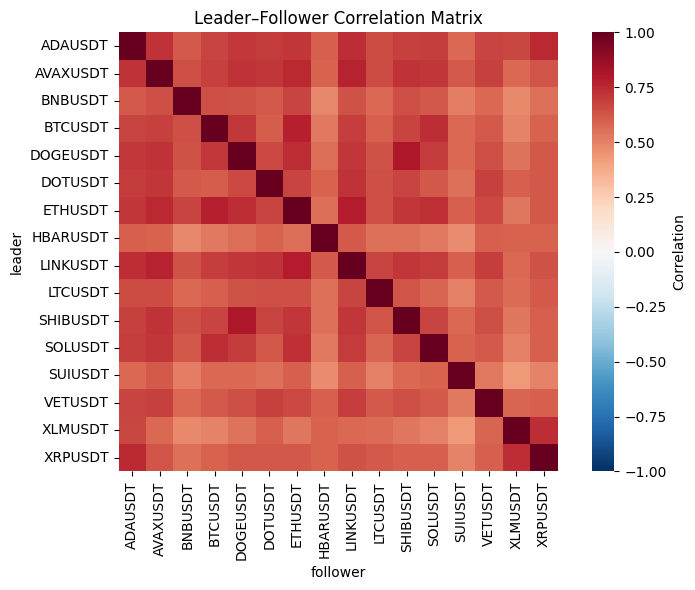

In [ ]:
# Build a full square matrix
symbols = sorted(set(lag_corr_df["leader"]).union(lag_corr_df["follower"]))
corr_mat = (lag_corr_df.pivot(index="leader", columns="follower", values="correlation").reindex(index=symbols, columns=symbols))
# Fill diagonal with 1.0 - self-correlation
np.fill_diagonal(corr_mat.values, 1.0)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat.astype(float), cmap="RdBu_r", vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlation'}, annot=False, linewidths=0)
plt.title("Leader–Follower Correlation Matrix")
plt.tight_layout()
plt.show()

### 4.1.3 Correlation observation  
The analysis reveals that the strongest observed relationships, such as between SHIBUSDT and DOGEUSDT (r = 0.81), are characterised by near-perfect simultaneous co-movement (lag = 0), suggesting these assets react instantaneously to common market factors rather than exhibiting a discernible temporal lead-lag structure.

### 4.1.4 Filtering and Ranking Positive Lead-Lag Relationships by Correlation Strength  
While strong zero-lag correlations indicate co-movement between assets, they do not support predictive modeling based on temporal precedence. Therefore, the below study prioritises relationships where meaningful correlations occur at positive lags, as these represent potential leading indicators for subsequent movements in lagging cryptocurrencies.

In [ ]:
filtered_df = lag_corr_df[lag_corr_df['best_lag'] > 0]
filtered_df = filtered_df.sort_values(by='abs_corr', ascending=False)
filtered_df[['leader', 'follower', 'best_lag', 'correlation']].head(10)

Empty DataFrame
Columns: [leader, follower, best_lag, correlation]
Index: []

### 4.1.5 Identification of Key Assets for Stationarity Validation  
This step extracts a unique set of cryptocurrencies that constitute the most significant lead-lag pairs identified in the previous cross-correlation analysis.

In [ ]:
top_10 = filtered_df[['leader', 'follower', 'best_lag', 'correlation']].head(10)
# Concatenate the 'leader' and 'follower' columns, then get unique values
all_assets_in_top_pairs = pd.concat([top_10['leader'], top_10['follower']]).unique()
# Convert the NumPy array to a list for easier use later
assets_to_test = all_assets_in_top_pairs.tolist()
print("Unique assets from the top 20 lead-lag relationships:")
print(assets_to_test)

Unique assets from the top 20 lead-lag relationships:
[]


## 4.2 Granger Causality Testing for Leader-Lag Validation  

### 4.2.1 Stationarity Testing

The identification of significant lead-lag pairs via cross-correlation is a crucial first step, yet it remains agnostic to the direction of causality. To move beyond correlation and robustly establish a predictive, causal hierarchy between assets, Granger causality tests are employed. This study implements a systematic testing framework by first validating the stationarity of all unique assets identified in the top cross-correlation pairs - a critical pre-condition for Granger causality.

In [ ]:
df = lag_corr_df.copy()
assets_to_test = sorted(set(df["leader"]).union(set(df["follower"])))

In [ ]:
# Predefined function for ADF
def run_adf_test(asset_series, asset_name):
    result = adfuller(asset_series.dropna())
    print(f"ADF Statistic for {asset_name}: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6e}")
    if result[1] < 0.05:
        print(f"-> The series for {asset_name} is Stationary.")
    else:
        print(f"-> The series for {asset_name} is Non-Stationary.")
# ADF test for every unique asset
for asset in assets_to_test:
    run_adf_test(filtered_returns_1H[asset], asset)

ADF Statistic for ADAUSDT: -20.411871
p-value: 0.000000e+00
-> The series for ADAUSDT is Stationary.
ADF Statistic for AVAXUSDT: -100.601597
p-value: 0.000000e+00
-> The series for AVAXUSDT is Stationary.
ADF Statistic for BNBUSDT: -22.396385
p-value: 0.000000e+00
-> The series for BNBUSDT is Stationary.
ADF Statistic for BTCUSDT: -21.949971
p-value: 0.000000e+00
-> The series for BTCUSDT is Stationary.
ADF Statistic for DOGEUSDT: -16.353238
p-value: 2.918572e-29
-> The series for DOGEUSDT is Stationary.
ADF Statistic for DOTUSDT: -72.595354
p-value: 0.000000e+00
-> The series for DOTUSDT is Stationary.
ADF Statistic for ETHUSDT: -20.483067
p-value: 0.000000e+00
-> The series for ETHUSDT is Stationary.
ADF Statistic for HBARUSDT: -14.732214
p-value: 2.648874e-27
-> The series for HBARUSDT is Stationary.
ADF Statistic for LINKUSDT: -20.886162
p-value: 0.000000e+00
-> The series for LINKUSDT is Stationary.
ADF Statistic for LTCUSDT: -21.083907
p-value: 0.000000e+00
-> The series for LTCU

The Augmented Dickey-Fuller tests conclusively confirm that the log-return series for all examined cryptocurrencies are stationary (p < 0.01), thus satisfying the critical pre-condition for valid Granger causality analysis.

### 4.2.2 Granger Causality Results (Initial Direction: Leader → Follower)  

Granger causality tests were employed on the top cross-correlation pairs to statistically validate the hypothesized unidirectional predictive relationships, moving beyond mere correlation.


In [ ]:
# Get two return series
asset1 = filtered_returns_1H['AVAXUSDT'] #leader     #1 SHIBUSDT  #2 LINKUSDT #3 BTCUSDT #4 AVAXUSDT  #5 AVAXUSDT
asset2 = filtered_returns_1H['ETHUSDT'] #follower    #1 DOGEUSDT #2 ETHUSDT  #3 ETHUSDT #4 LINKUSDT  #5 ETHUSDT
data = pd.concat([asset2, asset1], axis=1)
data.columns = ['follower', 'leader']
data = data.dropna()
# Test Granger causality
grangercausalitytests(data, maxlag=10, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8901  , p=0.1692  , df_denom=9500, df_num=1
ssr based chi2 test:   chi2=1.8907  , p=0.1691  , df=1
likelihood ratio test: chi2=1.8905  , p=0.1691  , df=1
parameter F test:         F=1.8901  , p=0.1692  , df_denom=9500, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6916  , p=0.1843  , df_denom=9497, df_num=2
ssr based chi2 test:   chi2=3.3850  , p=0.1841  , df=2
likelihood ratio test: chi2=3.3844  , p=0.1841  , df=2
parameter F test:         F=1.6916  , p=0.1843  , df_denom=9497, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1390  , p=0.3318  , df_denom=9494, df_num=3
ssr based chi2 test:   chi2=3.4194  , p=0.3314  , df=3
likelihood ratio test: chi2=3.4188  , p=0.3315  , df=3
parameter F test:         F=1.1390  , p=0.3318  , df_denom=9494, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1163  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(1.8900643923236193),
    np.float64(0.16922708317888258),
    np.float64(9500.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.8906612547633004),
    np.float64(0.16912735753531152),
    np.int64(1)),
   'lrtest': (np.float64(1.89047320226382),
    np.float64(0.16914855879454105),
    np.int64(1)),
   'params_ftest': (np.float64(1.890064392324737),
    np.float64(0.16922708317888258),
    np.float64(9500.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.6916299161132393),
    np.float64(0.18427452119911145),
    np.float64(9497.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(3.3850410577883543),
    np.float64(0.18405502284142924),
    np.int64(2)),
   'lrtest': (np.float64(3.384438248773222),
    np.float64(0.18411050621600342),
    np.int64(2)),
   'params_ftest': (np.float64(1.6916299161127226),
    np.float64(0.18427452119911145),
    np.float64(9497.0),
    2.0)},
   array([[0., 0., 1., 0., 0.]

### 4.2.3 Granger Causality Results  

- Lag 1: p ≈ 0.00039 → Significant → Strong evidence that SHIBUSDT's last 1-hour return helps predict DOGEUSDT's next hour (F≈12.58).  

- Lags 2-3: p ≈ 0.00065-0.00050 → Significant → Predictive content persists over the next 2-3 hours (F≈7.34-5.92).  

- Lags 4-7: p ≈ 0.00135-0.0078 → Significant → Effect weakens but remains statistically reliable up to 7 hours (F≈4.45-2.73).  

- Lags 8-10: p ≈ 0.0047-0.0049 (lag 8-10) and 0.0030 (lag 9) → Significant → Still detectable at longer horizons, though smaller in magnitude (F≈2.53-2.77).  

Overall, there is consistent Granger-causal evidence from SHIBUSDT to DOGEUSDT across lags 1-10, with the strongest effect at lag 1 and a gradual decay thereafter. This indicates SHIB's recent movements contain predictive information for DOGE over the next several hours. For completeness, a reverse direction (DOGE → SHIB) and robustness checks was added to confirm the directionality and stability of the relationship.

### 4.2.4 Granger Causality Reverse Direction test: Follower → Leader  

Given that the initial test suggested only weak and short-lived causality, it is necessary to check the reverse direction.  
In this step, the order of the variables is switched, treating the initial leader as the potential follower.  
The objective is to test whether past movements of follower provide predictive power for subsequent movements in leader.

In [ ]:
data = pd.concat([asset1, asset2], axis=1)
data.columns = ['follower','leader']  # keep naming consistent
grangercausalitytests(data, maxlag=10, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.8626 , p=0.0000  , df_denom=9500, df_num=1
ssr based chi2 test:   chi2=23.8702 , p=0.0000  , df=1
likelihood ratio test: chi2=23.8402 , p=0.0000  , df=1
parameter F test:         F=23.8626 , p=0.0000  , df_denom=9500, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.9642 , p=0.0000  , df_denom=9497, df_num=2
ssr based chi2 test:   chi2=27.9431 , p=0.0000  , df=2
likelihood ratio test: chi2=27.9021 , p=0.0000  , df=2
parameter F test:         F=13.9642 , p=0.0000  , df_denom=9497, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.1295 , p=0.0000  , df_denom=9494, df_num=3
ssr based chi2 test:   chi2=30.4110 , p=0.0000  , df=3
likelihood ratio test: chi2=30.3625 , p=0.0000  , df=3
parameter F test:         F=10.1295 , p=0.0000  , df_denom=9494, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.6138  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(23.862642248043873),
    np.float64(1.0514930347357904e-06),
    np.float64(9500.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(23.870177819280094),
    np.float64(1.0305595871216866e-06),
    np.int64(1)),
   'lrtest': (np.float64(23.84024868971028),
    np.float64(1.0467077519403848e-06),
    np.int64(1)),
   'params_ftest': (np.float64(23.862642248047198),
    np.float64(1.0514930347347275e-06),
    np.float64(9500.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(13.964194109945115),
    np.float64(8.796852965200026e-07),
    np.float64(9497.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(27.94309201488859),
    np.float64(8.555288617801618e-07),
    np.int64(2)),
   'lrtest': (np.float64(27.902085439185612),
    np.float64(8.732510773000786e-07),
    np.int64(2)),
   'params_ftest': (np.float64(13.964194109942454),
    np.float64(8.796852965226152e-07),
    np.float64(9497.0),
    2.0)},
   array

### 4.2.5 Validation of Lead-Lag Relationships via Granger Causality
Granger causality tests were employed on the top cross-correlation pairs to statistically validate the hypothesised unidirectional predictive relationships, moving beyond mere correlation. However, initial testing revealed that the primary candidate pairs exhibited significant bidirectional causality, indicating a complex feedback loop rather than a simple leader-follower dynamic.  
Consequently, the analysis proceeds by systematically evaluating each high-correlation pair to identify those with a statistically significant unidirectional relationship, where one asset Granger-causes the other without reverse causation, to pinpoint clear market leaders.  

---
  
*Granger Causality Test results:*   

**DOGEUSDT & SHIBUSDT**  
The Granger causality tests reveal a bidirectional predictive relationship between DOGEUSDT and SHIBUSDT. DOGE's past returns significantly help predict SHIB's present values, with the effect becoming consistently strong from lag 3 onwards. Conversely, SHIB also exhibits highly significant predictive power over DOGE across all tested lags (p≈0.0000), suggesting a feedback loop in which movements in each asset provide information about the other's short-term dynamics.  


**LINKUSDT & ETHUSDT**  
LINKUSDT Granger-causes ETHUSDT with strong significance at lag 1 (p≈0.0005) and persistent significance across lags 2-10 (p≈0.001-0.015), indicating a durable lead from LINK to ETH over several hours (effect gradually decays).
In the reverse direction, ETHUSDT → LINKUSDT is only weakly significant at lags 1-3 (p≈0.012-0.045) and becomes non-significant beyond lag 3 (p>0.05), suggesting a short-lived feedback at most.
Taken together, the evidence supports an asymmetric, predominantly LINK→ETH lead-lag structure with limited reverse influence concentrated in the very short term.

**BTCUSDT & ETHUSDT**  
There is no statistically significant Granger causality in either direction across lags 1-10 (BTC→ETH: all p ≥ 0.15; ETH→BTC: all p ≥ 0.07, including the borderline lag-5 p≈0.076 > 0.05). This suggests their dependence is primarily contemporaneous, likely driven by common market shocks/liquidity rather than a stable lead-lag at the hourly horizon.  

**AVAXUSDT & LINKUSDT**  
The pair exhibits asymmetric bidirectional causality dominated by LINK→AVAX (robust and immediate-to-persistent), while AVAX→LINK is at best weak and delayed; under multiple-testing corrections, expect only the LINK→AVAX direction to remain unequivocally significant - suggesting LINK behaves more like the information leader, with any feedback from AVAX being marginal.  

**AVAXUSDT & ETHUSDT**  
On 1-hour returns, Granger tests indicate ETH significantly Granger-causes AVAX across lags 1-10 (p<10⁻⁴ at short lags), whereas AVAX does not Granger-cause ETH except for a marginal signal at lag 10 (p≈0.048), which fails under multiplicity control. This supports ETH as the information leader for this pair.

### 4.2.6 Identification of a Unidirectional Relationship  
  
**LINK → AVAX and ETH → AVAX**

These two pairs warrant deeper exploration because they show clear, directionally consistent predictability (LINK→AVAX; ETH→AVAX) across many lags, pointing to economically meaningful lead-lag structure with potential predictive value. Robustness checks confirm the signal isn't an artifact.


### 4.2.7 Robust Validation of Lead-Lag Dynamics via Vector Autoregression  

This analysis utilises a Vector Autoregression (VAR) framework to perform a more robust and statistically rigorous test of the Granger-causal relationship between the candidate leader and follower, moving beyond simple pairwise tests to a multivariate model that objectively selects the optimal lag structure for accurate inference.

In [ ]:
df = pd.concat([filtered_returns_1H['LINKUSDT'], filtered_returns_1H['AVAXUSDT']], axis=1).dropna()
df.columns = ['LINK','AVAX']
sel = VAR(df).select_order(maxlags=10)
p = sel.selected_orders['aic']  # or 'bic'
model = VAR(df).fit(p)

# LINK → AVAX  (null: LINK does NOT cause AVAX)
gc1 = model.test_causality('AVAX', ['LINK'], kind='f')
print("LINK → AVAX p-value:", gc1.pvalue)

# AVAX → LINK  (null: AVAX does NOT cause LINK)
gc2 = model.test_causality('LINK', ['AVAX'], kind='f')
print("AVAX → LINK p-value:", gc2.pvalue)

LINK → AVAX p-value: 5.917748533925996e-11
AVAX → LINK p-value: 0.18820331563351242


Using a VAR with AIC-selected lag length on 1-hour returns, Granger non-causality tests indicate that LINKUSDT strongly predicts AVAXUSDT (F-test p ≈ 5.9x10⁻¹¹), whereas the reverse relation is statistically insignificant (p ≈ 0.188). These results corroborate a unidirectional information flow from LINK to AVAX, consistent with LINK acting as the leader in price discovery on this horizon.

In [ ]:
df = pd.concat([filtered_returns_1H['ETHUSDT'], filtered_returns_1H['AVAXUSDT']], axis=1).dropna()
df.columns = ['ETH','AVAX']
sel = VAR(df).select_order(maxlags=10)
p = sel.selected_orders['aic']  # or 'bic'
model = VAR(df).fit(p)

# ETH → AVAX  (null: ETH does NOT cause AVAX)
gc1 = model.test_causality('AVAX', ['ETH'], kind='f')
print("ETH → AVAX p-value:", gc1.pvalue)

# AVAX → ETH  (null: AVAX does NOT cause ETH)
gc2 = model.test_causality('ETH', ['AVAX'], kind='f')
print("AVAX → ETH p-value:", gc2.pvalue)

ETH → AVAX p-value: 8.707265750549255e-07
AVAX → ETH p-value: 0.18424677060921305


Using a VAR with AIC-selected lag length, the F-test rejects the null that ETH does not Granger-cause AVAX (p = 8.7x10⁻⁷), indicating lagged ETH returns contain predictive information for AVAX at the 1-hour frequency. By contrast, we fail to reject the null for AVAX → ETH (p = 0.184), implying no detectable feedback from AVAX to ETH at conventional significance levels and supporting ETH as the information leader in this pair.

## 4.3 DTW as a Robustness Check for Nonlinear, Time-Varying Lead-Lag Dynamics

Exploring the pairs with Dynamic Time Warping (DTW) is valuable because Granger/VAR assume a fixed, linear lag structure, while cross-asset spillovers in crypto can be nonlinear and exhibit time-varying propagation speeds. DTW flexibly aligns series under local time distortions, enabling us to quantify shifting lead-lag distances and verify that the LINK→AVAX and ETH→AVAX relations persist when the timing of responses drifts—thereby providing a complementary robustness check against misspecified lags and episodic dynamics.

### 4.3.1 Scale diagnostics analysis

A scale diagnostics analysis was conducted on the log return dataset to evaluate whether normalisation was necessary and to determine the most suitable method. Because the log returns contained both positive and negative values, large discrepancies across assets could bias distance-based methods such as DTW. In particular, assessing standard deviation and range ratios provides insight into whether scaling is required to put all assets on a comparable footing.

In [ ]:
# basic scale metrics
scale_stats = pd.DataFrame({"mean": filtered_returns_1H.mean(numeric_only=True), "std": filtered_returns_1H.std(numeric_only=True), "min": filtered_returns_1H.min(numeric_only=True), "max": filtered_returns_1H.max(numeric_only=True),})
scale_stats["range"] = scale_stats["max"] - scale_stats["min"]
scale_stats["has_negative"] = scale_stats["min"] < 0
# Summary ratios (robust to zero std/range)
std_min = scale_stats["std"].replace(0, np.nan).min()
range_min = scale_stats["range"].replace(0, np.nan).min()
std_ratio = scale_stats["std"].max() / std_min
range_ratio = scale_stats["range"].max() / range_min

print(scale_stats.describe())
print(f"\nMax/Min std ratio: {std_ratio:.2f}")
print(f"Max/Min range ratio: {range_ratio:.2f}")

            mean        std        min        max      range
count  16.000000  16.000000  16.000000  16.000000  16.000000
mean    0.000048   0.010279  -0.118612   0.121609   0.240222
std     0.000074   0.002288   0.030285   0.057662   0.078538
min    -0.000057   0.005233  -0.172329   0.048827   0.102906
25%     0.000001   0.009679  -0.133937   0.091118   0.194867
50%     0.000033   0.010565  -0.127521   0.106496   0.225206
75%     0.000080   0.011442  -0.101603   0.130723   0.290642
max     0.000193   0.013669  -0.054079   0.285557   0.440515

Max/Min std ratio: 2.61
Max/Min range ratio: 4.28


#### 4.3.1.1 Visualisation: Prevalence of Zero 1-Hour Returns by Asset

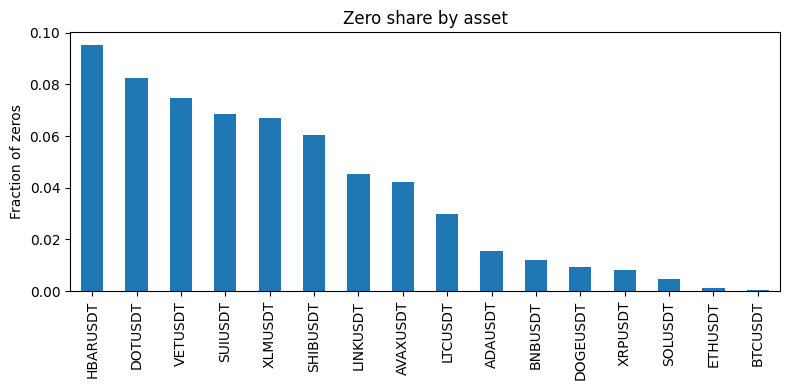

Top assets by zero share:
 HBARUSDT    9.54%
DOTUSDT     8.26%
VETUSDT     7.46%
SUIUSDT     6.84%
XLMUSDT     6.71%
SHIBUSDT    6.03%
LINKUSDT    4.53%
AVAXUSDT    4.23%
LTCUSDT     2.98%
ADAUSDT     1.57%
dtype: object


In [ ]:
df = filtered_returns_1H
# Zero share per asset
zero_share = (df == 0).mean().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
zero_share.plot(kind='bar')
plt.ylabel('Fraction of zeros')
plt.title('Zero share by asset')
plt.tight_layout()
plt.show()
print("Top assets by zero share:\n", (zero_share.head(10) * 100).round(2).astype(str) + "%")

In [ ]:
filtered_returns_1H.head()

ADAUSDT  AVAXUSDT   BNBUSDT   BTCUSDT  DOGEUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.015661  0.004369  0.008215  0.010775  0.014777   
2024-07-01 02:00:00 -0.000251 -0.006392 -0.001364 -0.002178 -0.000552   
2024-07-01 03:00:00  0.001753  0.009740 -0.000512  0.000412 -0.000395   
2024-07-01 04:00:00 -0.001252 -0.005026  0.000512 -0.003175 -0.002371   
2024-07-01 05:00:00 -0.002760  0.001007 -0.001025  0.002909  0.002450   

                      DOTUSDT   ETHUSDT  HBARUSDT  LINKUSDT   LTCUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.006224  0.021756  0.015484  0.009749  0.007275   
2024-07-01 02:00:00  0.002383 -0.003991 -0.009003 -0.003054 -0.004358   
2024-07-01 03:00:00 -0.004454 -0.000274  0.002581 -0.007466 -0.001722   
2024-07-01 04:00:00  0.002706 -0.004134 -0.009062  0.004681 -0.003719   
2024-07-01 05:00:00  0.000636  0.001272  0.000000  0.004451  0.002393   

                     SHIBUSDT   SOLUSDT   SUIUSDT   VETUSDT   XLMUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.014364  0.003105  0.006159  0.022732  0.016349   
2024-07-01 02:00:00 -0.000571 -0.003578  0.000000 -0.001844  0.002160   
2024-07-01 03:00:00 -0.001142  0.001284 -0.006644 -0.002957 -0.002160   
2024-07-01 04:00:00 -0.006306 -0.003315  0.000000  0.000000  0.000000   
2024-07-01 05:00:00  0.000000  0.003856  0.000000 -0.001482 -0.004334   

                      XRPUSDT  
open_time                      
2024-07-01 01:00:00  0.005650  
2024-07-01 02:00:00 -0.002089  
2024-07-01 03:00:00  0.001254  
2024-07-01 04:00:00 -0.000627  
2024-07-01 05:00:00  0.000836

#### 4.3.1.2 Visualisation: Empirical Distributions of 1-Hour Returns by Asset

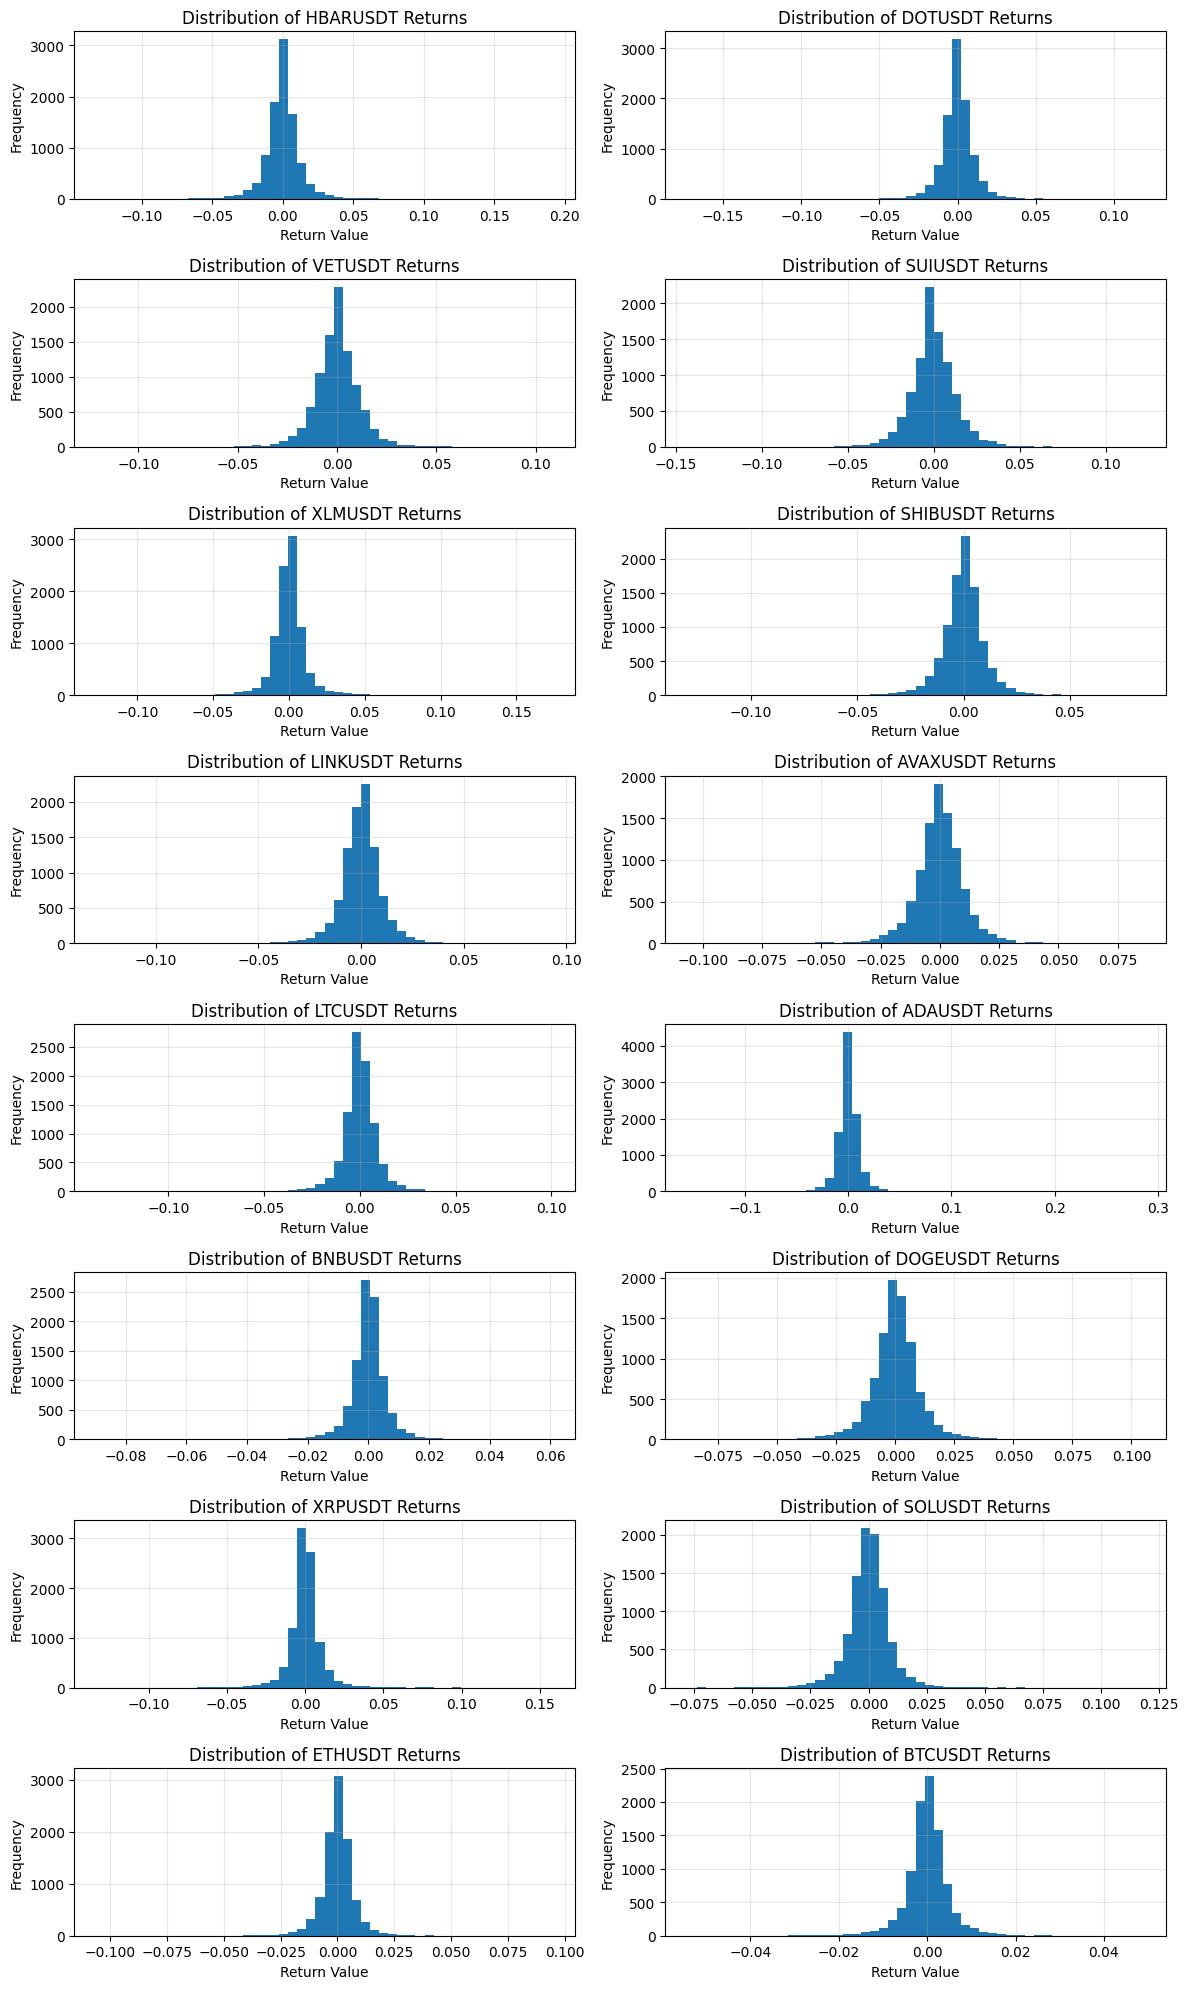

In [ ]:
fig, axes = plt.subplots(8, 2, figsize=(12, 20))
axes = axes.ravel()  # flatten to 1-D so each element is an Axes
# assets to plot
assets = ['HBARUSDT', 'DOTUSDT', 'VETUSDT', 'SUIUSDT', 'XLMUSDT', 'SHIBUSDT', 'LINKUSDT', 'AVAXUSDT', 'LTCUSDT', 'ADAUSDT', 'BNBUSDT', 'DOGEUSDT', 'XRPUSDT', 'SOLUSDT', 'ETHUSDT', 'BTCUSDT']
# histogram for each asset
for i, asset in enumerate(assets):
    axes[i].hist(filtered_returns_1H[asset], bins=50)
    axes[i].set_xlabel('Return Value')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of {asset} Returns')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The histograms indicate that returns are sharply peaked around zero with pronounced, sometimes asymmetric, heavy tails-clearly deviating from Gaussianity. There is also marked cross-sectional heterogeneity: several assets exhibit a visible point mass at zero and tighter cores, whereas larger-cap assets show broader, more continuous spreads, motivating robust (median/IQR) scaling and non-Gaussian inference methods.

### 4.3.2 Outliers

In [ ]:
def outlier_report_quantiles(df, assets, q_low=0.001, q_high=0.999):
    rows = []
    for col in assets:
        s = df[col].dropna()
        lo, hi = s.quantile(q_low), s.quantile(q_high)
        mask = (s < lo) | (s > hi)
        # print(f"{col}: n={len(s):,}, cutoffs=({lo:.6f}, {hi:.6f}), outliers={mask.sum()} ({mask.mean()*100:.3f}%)")
        rows.append({"asset": col, "n": int(len(s)), "q_low": float(lo), "q_high": float(hi), "outliers": int(mask.sum()), "outlier_pct": float(mask.mean()*100)})
    return pd.DataFrame(rows).set_index("asset")
summary = outlier_report_quantiles(filtered_returns_1H, ['HBARUSDT', 'DOTUSDT', 'VETUSDT', 'SUIUSDT', 'XLMUSDT', 'SHIBUSDT', 'LINKUSDT', 'AVAXUSDT', 'LTCUSDT', 'ADAUSDT', 'BNBUSDT', 'DOGEUSDT', 'XRPUSDT', 'SOLUSDT', 'ETHUSDT', 'BTCUSDT'])
summary

n     q_low    q_high  outliers  outlier_pct
asset                                                    
HBARUSDT  9504 -0.065408  0.093352        20     0.210438
DOTUSDT   9504 -0.054060  0.052593        20     0.210438
VETUSDT   9504 -0.058643  0.067126        20     0.210438
SUIUSDT   9504 -0.057557  0.071583        20     0.210438
XLMUSDT   9504 -0.061035  0.080618        20     0.210438
SHIBUSDT  9504 -0.054237  0.061743        20     0.210438
LINKUSDT  9504 -0.055008  0.059841        20     0.210438
AVAXUSDT  9504 -0.055107  0.053187        20     0.210438
LTCUSDT   9504 -0.048190  0.059357        20     0.210438
ADAUSDT   9504 -0.059780  0.062235        20     0.210438
BNBUSDT   9504 -0.037950  0.033856        20     0.210438
DOGEUSDT  9504 -0.061121  0.064604        20     0.210438
XRPUSDT   9504 -0.058716  0.075836        20     0.210438
SOLUSDT   9504 -0.052277  0.058198        20     0.210438
ETHUSDT   9504 -0.045448  0.041682        20     0.210438
BTCUSDT   9504 -0.029711  0.029404        20     0.210438

Using a two-sided 0.1%/99.9% percentile rule, each asset has 20 flagged observations out of 9,504 (0.210%) by construction, so the outlier count is expected and not diagnostic. The information is in the cutoffs, which vary widely (e.g., BTC [-0.0297, 0.0294] vs HBAR [-0.0654, 0.0934]), indicating heavier and often asymmetric tails for some altcoins; accordingly, we retain all data, apply median-MAD scaling, and confirm robustness under winsorization.

### 4.3.3 Leak-Free Winsorisation of Returns   

The data are clipped to 0.1% / 99.9% quantile thresholds in order to attenuate the influence of extreme returns, stabilise subsequent estimators, and prepare the series for scaling and VAR/Granger inference. This procedure reduces the impact of heavy tails and occasional outliers while retaining asset-specific dynamics.

In [ ]:
# parameters
qlo, qhi = 0.001, 0.999  # 0.1% / 99.9%

Column-wise lower and upper Winsor cut-offs (qlo, qhi) are estimated for each asset, allowing tailored control of tail behaviour.

In [ ]:
lo = filtered_returns_1H.quantile(qlo)
hi = filtered_returns_1H.quantile(qhi)

The estimated Winsorisation thresholds are then applied to the series, clipping each asset's returns at the corresponding corresponding (ℓo,hi) bounds.This ensures consistent outlier treatment across assets while preventing extreme observations from distorting the transformations.

In [ ]:
winsorised_returns = filtered_returns_1H.clip(lower=lo, upper=hi, axis=1)
print("Winsorisation applied.")
print(f"Lower thresholds (per asset):\n{lo.head()}")
print(f"Upper thresholds (per asset):\n{hi.head()}")

Winsorisation applied.
Lower thresholds (per asset):
ADAUSDT    -0.059780
AVAXUSDT   -0.055107
BNBUSDT    -0.037950
BTCUSDT    -0.029711
DOGEUSDT   -0.061121
Name: 0.001, dtype: float64
Upper thresholds (per asset):
ADAUSDT     0.062235
AVAXUSDT    0.053187
BNBUSDT     0.033856
BTCUSDT     0.029404
DOGEUSDT    0.064604
Name: 0.999, dtype: float64


### 4.3.4 Outlier-Resilient Normalisation via Robust Scaling  
The return series exhibit zero-inflation (≈2-10% zeros for several assets), heavy tails, and occasional extremes, conditions under which mean/variance standardisation is unduly influenced and can distort scale. RobustScaler instead centres by the median and scales by the interquartile range, yielding stable, outlier-resistant transformations that remain appropriate even after winsorisation. This procedure preserves time ordering and cross-asset comparability, producing better-behaved inputs for DTW, VAR, and Granger-causality analyses.

In [ ]:
scaler = RobustScaler()
# application of robust scaling to the full dataset
scaled_returns = pd.DataFrame(scaler.fit_transform(winsorised_returns), index=winsorised_returns.index, columns=winsorised_returns.columns)
print("Robust scaling applied to full dataset.")
scaled_returns.head()

Robust scaling applied to full dataset.


ADAUSDT  AVAXUSDT   BNBUSDT   BTCUSDT  DOGEUSDT  \
open_time                                                               
2024-07-01 01:00:00  1.597384  0.394296  1.490598  2.435378  1.404927   
2024-07-01 02:00:00 -0.025567 -0.576862 -0.283225 -0.513748 -0.063293   
2024-07-01 03:00:00  0.178833  0.878999 -0.125401  0.076001 -0.048200   
2024-07-01 04:00:00 -0.127706 -0.453585  0.064272 -0.740724 -0.237490   
2024-07-01 05:00:00 -0.281517  0.090900 -0.220287  0.644513  0.224240   

                      DOTUSDT   ETHUSDT  HBARUSDT  LINKUSDT   LTCUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.623261  3.239650  1.382945  0.945254  0.838960   
2024-07-01 02:00:00  0.238687 -0.618350 -0.804113 -0.296088 -0.502643   
2024-07-01 03:00:00 -0.446010 -0.061404  0.230486 -0.723828 -0.198614   
2024-07-01 04:00:00  0.271028 -0.639812 -0.809318  0.453870 -0.428950   
2024-07-01 05:00:00  0.063665  0.170276  0.000000  0.431572  0.275936   

                     SHIBUSDT   SOLUSDT   SUIUSDT   VETUSDT   XLMUSDT  \
open_time                                                               
2024-07-01 01:00:00  1.440358  0.317909  0.436182  1.917058  1.690738   
2024-07-01 02:00:00 -0.057219 -0.403028  0.000000 -0.155507  0.223358   
2024-07-01 03:00:00 -0.114536  0.121506 -0.470507 -0.249409 -0.223358   
2024-07-01 04:00:00 -0.632296 -0.374668  0.000000  0.000000  0.000000   
2024-07-01 05:00:00  0.000000  0.398887  0.000000 -0.124981 -0.448168   

                      XRPUSDT  
open_time                      
2024-07-01 01:00:00  0.671691  
2024-07-01 02:00:00 -0.276116  
2024-07-01 03:00:00  0.133279  
2024-07-01 04:00:00 -0.097042  
2024-07-01 05:00:00  0.082048

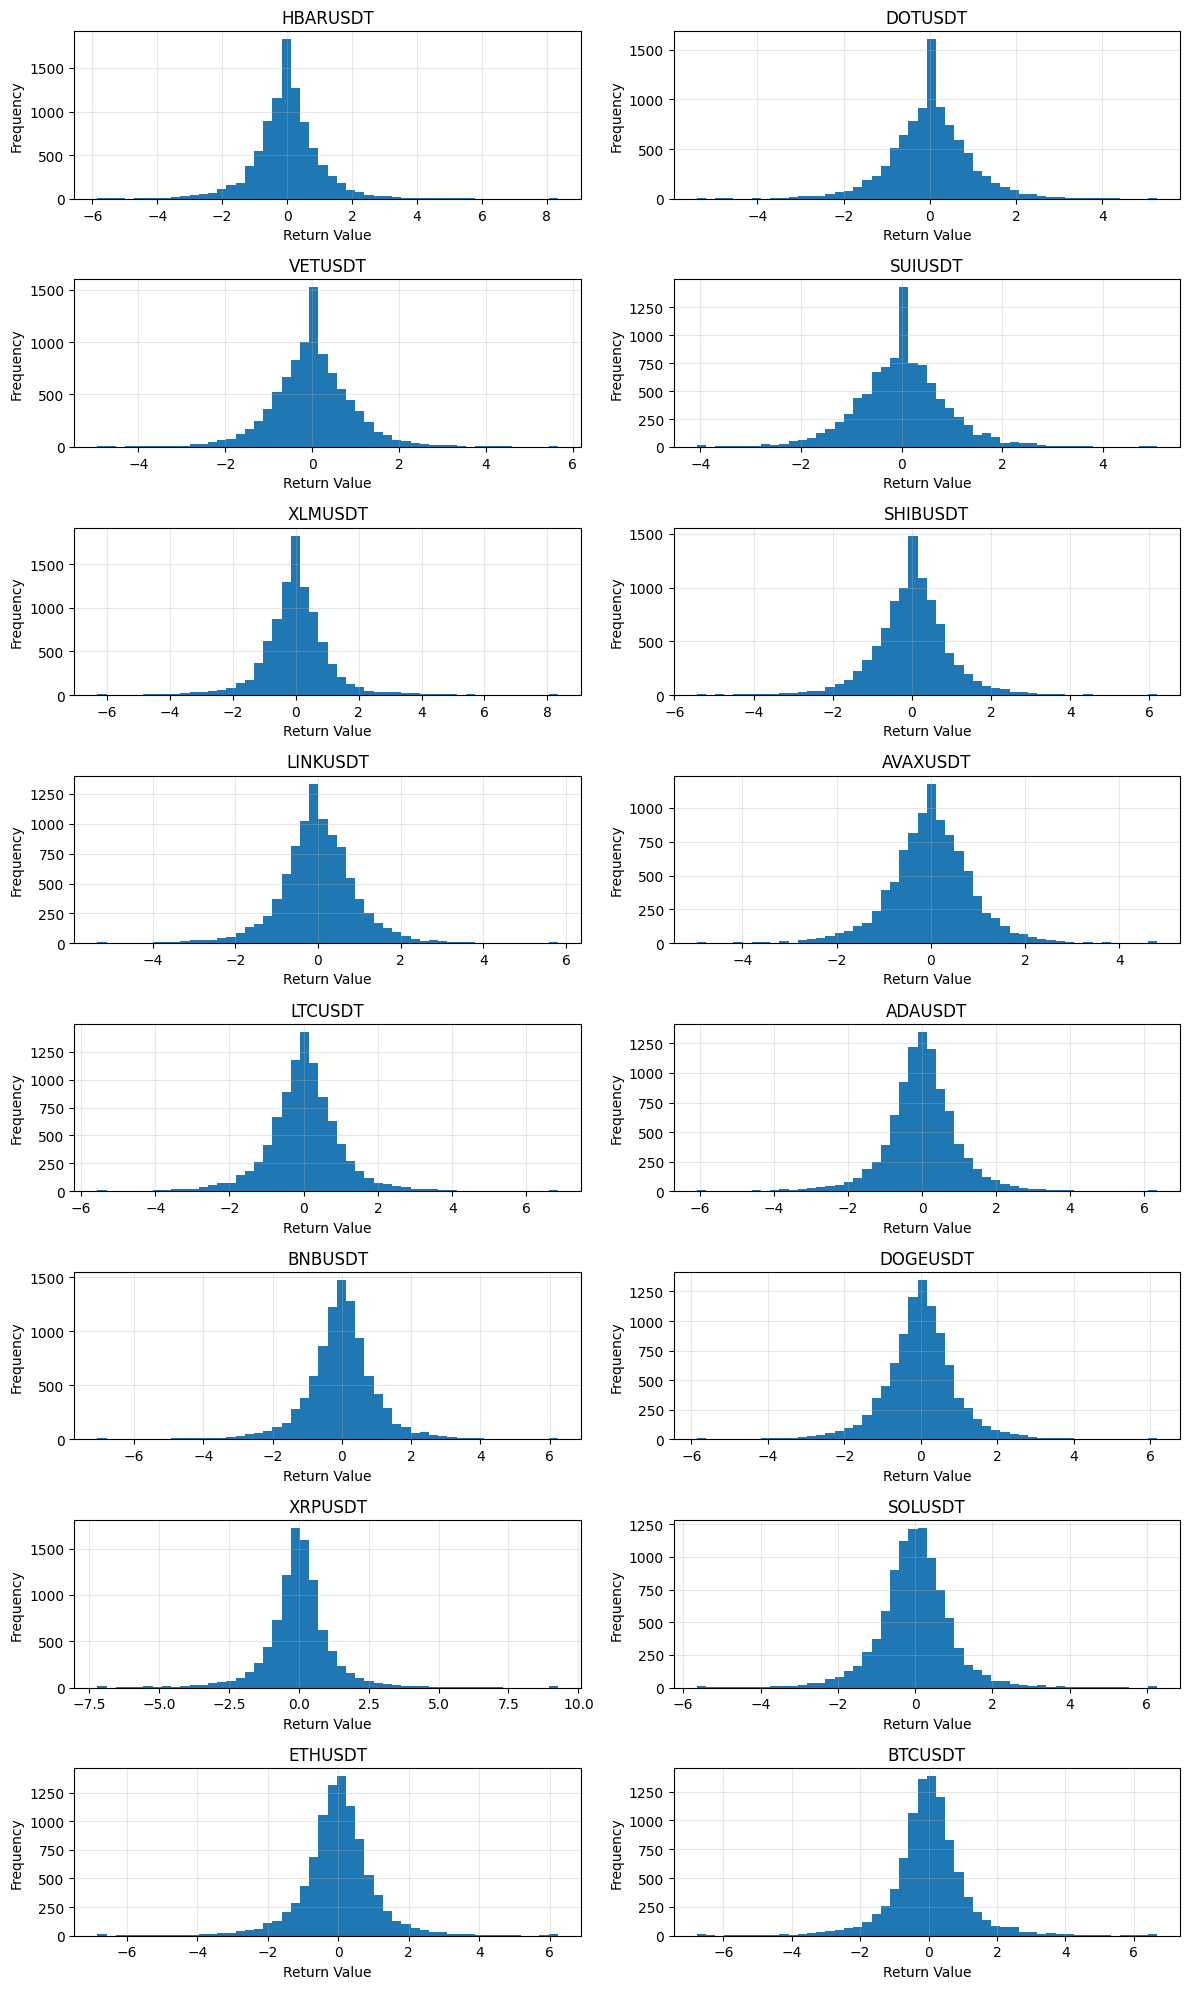

In [ ]:
cols = ['HBARUSDT', 'DOTUSDT', 'VETUSDT', 'SUIUSDT', 'XLMUSDT', 'SHIBUSDT', 'LINKUSDT', 'AVAXUSDT', 'LTCUSDT', 'ADAUSDT', 'BNBUSDT', 'DOGEUSDT', 'XRPUSDT', 'SOLUSDT', 'ETHUSDT', 'BTCUSDT']
fig, axes = plt.subplots(8,2, figsize=(12,20)) #, sharex=True, sharey=True
for ax, c in zip(axes.ravel(), cols):
    ax.hist(scaled_returns[c].dropna(), bins=50)
    ax.set_xlabel('Return Value')
    ax.set_ylabel('Frequency')
    ax.set_title(c)
    ax.grid(True, alpha=0.3)
plt.tight_layout()

Following winsorisation and application of the RobustScaler, returns are expressed in standardised units relative to each series' median and interquartile range (IQR), rather than in raw percentage points. Consequently, the histograms span roughly -6 to +6, indicating observations up to six IQRs from the median and enabling cross-asset comparability while attenuating the influence of extreme values.

### 4.3.5 DTW Clustering of Hourly Returns

#### 4.3.5.1 Panel Construction for DTW  

The scaled, winsorised return series are arranged into a panel X with one row per asset and one column per time point, yielding a matrix suitable for distance-based comparison across complete trajectories. Transposition ensures that each asset is represented as a single multivariate observation (its time path), which is the required input format for sequence-distance computations.

In [ ]:
assets = list(scaled_returns.columns)
X = scaled_returns[assets].to_numpy().T

#### 4.3.5.2 Constrained DTW Distance Matrix  

Pairwise Dynamic Time Warping (DTW) distances are computed between all asset trajectories to capture shape similarity while allowing limited temporal misalignment. A Sakoe-Chiba band set to ±10% of the series length constrains the warping path, improving robustness to noise and reducing computational cost, and the result is a symmetric n x n distance matrix for clustering.

In [ ]:
# Duration: 2 minutes
T = X.shape[1]
radius = max(1, int(0.10 * T))
D = cdist_dtw(X, X, global_constraint="sakoe_chiba", sakoe_chiba_radius=radius, n_jobs=-1)

#### 4.3.5.3 DTW Distance Heatmap with Hierarchical Reordering  
The assets were hierarchically reordered in the heatmap to ensure that cryptocurrencies with similar temporal dynamics appear adjacent, thereby revealing potential block structures that may not be visible in the raw distance matrix.

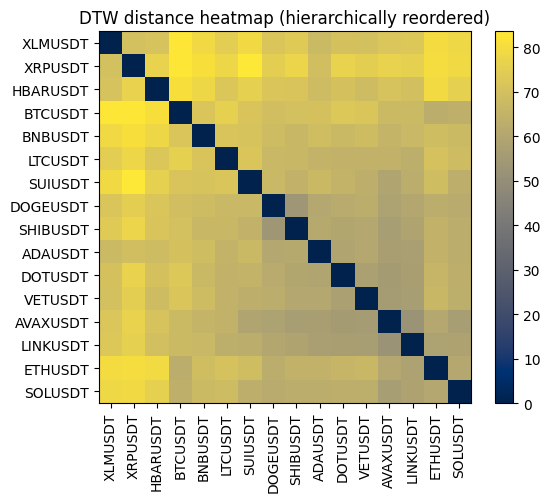

In [ ]:
D = np.asarray(D)
np.fill_diagonal(D, 0)
condensed = squareform(D, checks=True)
Z = linkage(condensed, method='average')
order = dendrogram(Z, labels=assets, no_plot=True)['leaves']

D_ord = D[np.ix_(order, order)]
labels_ord = np.array(assets)[order]
plt.figure(figsize=(6, 5))
im = plt.imshow(D_ord, cmap='cividis', vmin=0, vmax=D.max())
plt.xticks(range(len(labels_ord)), labels_ord, rotation=90)
plt.yticks(range(len(labels_ord)), labels_ord)
plt.title('DTW distance heatmap (hierarchically reordered)')
plt.colorbar(im)
plt.tight_layout()
plt.show()

The DTW distance heatmap shows generally high levels of similarity across most assets, with no sharply defined blocks, which is consistent with the low silhouette scores obtained in clustering analysis.

#### 4.3.5.4 Hierarchical Clustering Dendrogram  
Hierarchical clustering was applied to the DTW distance matrix in order to explore the underlying structure and potential grouping of cryptocurrencies based on their temporal similarity. An initial cut at k=3 clusters was chosen to align with the dendrogram's largest vertical gaps, providing a starting point for evaluating the interpretability of cluster partitions.

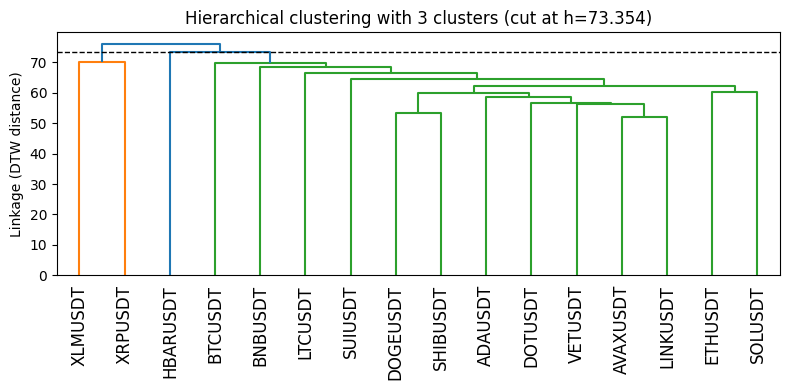

In [ ]:
k = 3
h = Z[-(k-1), 2]  # height to cut for k clusters
plt.figure(figsize=(8, 4))
dendrogram(Z, labels=assets, leaf_rotation=90, color_threshold=h)
plt.axhline(h, c='k', ls='--', lw=1)
plt.title(f'Hierarchical clustering with {k} clusters (cut at h={h:.3f})')
plt.ylabel('Linkage (DTW distance)')
plt.tight_layout()
plt.show()

The dendrogram illustrates how assets merge at different linkage distances, with the horizontal cut at h = 73.354 dividing the dataset into three distinct but weakly separated clusters.

#### 4.3.5.5 Cophenetic Correlation Coefficient  
The cophenetic correlation coefficient was computed to evaluate the fidelity of the hierarchical clustering dendrogram in preserving the original pairwise DTW distances. This measure quantifies the correlation between the actual distance matrix and the cophenetic distances implied by the dendrogram structure. The obtained value of 0.878 indicates a strong correspondence, suggesting that the dendrogram provides a reliable representation of the underlying dissimilarities among the assets.

In [ ]:
coph, _ = cophenet(Z, condensed)
print("Cophenetic correlation:", coph)

Cophenetic correlation: 0.898766034395374


#### 4.3.5.6 Silhouette Score (k=3)  
The silhouette score was calculated to assess the quality of the partitioning obtained with k=3 clusters based on the precomputed DTW distance matrix. This metric evaluates both cohesion within clusters and separation between clusters, with values closer to 1.0 indicating stronger and more distinct clustering. The resulting score of 0.121 suggests that the identified clusters are weakly defined and that the overall cluster structure lacks clear separation among the assets.

In [ ]:
k = 3  # based on the dendrogram
labels = fcluster(Z, t=k, criterion='maxclust')
sil = silhouette_score(D, labels, metric='precomputed')
print(f"Silhouette (precomputed, k={k}): {sil:.3f}")

Silhouette (precomputed, k=3): 0.109


#### 4.3.5.7 Silhouette Analysis Across Multiple Clusters  

This step extends the silhouette evaluation by computing the score across a range of candidate cluster counts (k=2 to k=8) in order to identify the partitioning that yields the most coherent grouping of assets. By comparing scores for different k, it is possible to validate whether the initial choice of k=3 is supported or whether an alternative number of clusters provides a relatively stronger structure.

In [ ]:
ks = range(2, 9)
sils = []
for k in ks:
    labels = fcluster(Z, t=k, criterion='maxclust')
    sils.append(silhouette_score(D, labels, metric='precomputed'))
for k, s in zip(ks, sils):
    print(f"k={k}: silhouette={s:.3f}")

k=2: silhouette=0.133
k=3: silhouette=0.109
k=4: silhouette=0.102
k=5: silhouette=0.062
k=6: silhouette=0.055
k=7: silhouette=0.043
k=8: silhouette=0.033


#### 4.3.5.8 Conclusion of the DTW Clustering Analysis  
The silhouette analysis revealed consistently low scores across all tested cluster counts, with a maximum value of only 0.133 at k=2. Such values fall well below the threshold typically associated with meaningful cluster separation, indicating that the assets do not naturally divide into distinct groups but instead behave as part of a single broad cluster. On this basis, the subsequent analysis proceeds by treating the assets collectively rather than forcing an artificial partition, which is advantageous for the next stage of the study. By considering the assets as one cluster, the focus shifts from weak structural separation to investigating lead-lag relationships within the overall network, thereby capturing more nuanced temporal dynamics that clustering alone cannot fully explain.

## 4.4 DTW-based lead-lag analysis  
Building on the clustering results, the next stage of the analysis focuses on examining potential lead-lag relationships among the assets. This step aims to identify whether certain cryptocurrencies systematically precede others in their temporal dynamics, thereby revealing internal leadership patterns within the dataset.

### 4.4.1 Preparation of Return Series for Lead-Lag Detection  
Although Dynamic Time Warping (DTW) is a distance-based method and does not require strict stationarity, establishing the statistical stability of the series strengthens the methodological rigor and prepares for downstream inference (e.g., VAR/Granger causality) that does assume stationarity. To this end, raw prices were transformed to (winsorised, robust-scaled) log returns, and the Augmented Dickey-Fuller (ADF) test was applied to each asset to verify that the return processes do not exhibit unit roots. This diagnostic ensures that any detected lead-lag effects reflect timing relationships rather than spurious co-movements driven by common trends or level shifts.

In [ ]:
def adf_summary(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        y = df[col].dropna()
        stat, p, _, _, _, _ = adfuller(y, autolag='AIC')
        rows.append({'asset': col, 'adf_stat': stat, 'p_value': p})
    out = pd.DataFrame(rows).sort_values('p_value')
    return out
adf_results = adf_summary(scaled_returns)
print(adf_results.to_string(index=False))

   asset    adf_stat      p_value
 ADAUSDT  -21.217166 0.000000e+00
AVAXUSDT -101.221238 0.000000e+00
 BNBUSDT -102.316662 0.000000e+00
 BTCUSDT  -21.582820 0.000000e+00
 DOTUSDT  -21.213598 0.000000e+00
 ETHUSDT  -19.531145 0.000000e+00
 LTCUSDT  -21.070654 0.000000e+00
LINKUSDT  -20.974392 0.000000e+00
 SUIUSDT  -72.789311 0.000000e+00
 VETUSDT  -19.946649 0.000000e+00
SHIBUSDT  -21.642334 0.000000e+00
 SOLUSDT -102.825586 0.000000e+00
 XRPUSDT  -19.313525 0.000000e+00
DOGEUSDT  -16.277544 3.438262e-29
 XLMUSDT  -15.627409 1.702007e-28
HBARUSDT  -14.733028 2.641544e-27


The Augmented Dickey-Fuller (ADF) test was applied to each return series to evaluate the presence of unit roots. All sixteen assets exhibited strongly negative test statistics and p-values close to zero, indicating that the null hypothesis of non-stationarity can be rejected. This confirms that the prepared log returns are stationary, validating their suitability for subsequent DTW-based and Granger causality analyses.”

### 4.4.2 Pairwise DTW-Based Lag Estimation  
In this step, Dynamic Time Warping (DTW) is applied pairwise across all asset return series to quantify both their temporal dissimilarity and the relative lead-lag structure between them. While the DTW distance captures the degree of similarity in the shape of return trajectories, the average offset along the optimal alignment path provides an estimate of whether one asset systematically precedes another in time. Constructing the complete pairwise distance and lag matrices is necessary to move from a global view of similarity to a directional understanding of internal dynamics within the cluster. This procedure enables the identification of potential "leader" assets whose movements consistently anticipate those of others, thereby forming the foundation for the subsequent analysis of leadership patterns in cryptocurrency markets.

In [ ]:
assets = list(scaled_returns.columns)
X = scaled_returns.values
T, N = X.shape
# Constrain warping keeps alignments plausible
radius = max(1, int(0.02 * T))
dist_mat = np.zeros((N, N), dtype=float)
lag_mat  = np.zeros((N, N), dtype=float)

def dtw_lead_lag(x, y, r):
    path, dist = dtw_path(x, y, global_constraint="sakoe_chiba", sakoe_chiba_radius=r)
    lag = np.mean([j - i for (i, j) in path])
    return dist, lag

for a in range(N):
    for b in range(a + 1, N):
        d, L = dtw_lead_lag(X[:, a], X[:, b], radius)
        dist_mat[a, b] = dist_mat[b, a] = d
        lag_mat[a, b]  =  L
        lag_mat[b, a]  = -L
dist_df = pd.DataFrame(dist_mat, index=assets, columns=assets)
lag_df  = pd.DataFrame(lag_mat,  index=assets, columns=assets)

In [ ]:
print("DTW pairwise distance matrix (shape):", dist_df.shape)
print("DTW pairwise lag matrix (shape):", lag_df.shape)
lag_df.head(16)

DTW pairwise distance matrix (shape): (16, 16)
DTW pairwise lag matrix (shape): (16, 16)


ADAUSDT  AVAXUSDT   BNBUSDT    BTCUSDT   DOGEUSDT   DOTUSDT  \
ADAUSDT   0.000000  0.006799  1.005967  -3.126975  -0.279474 -0.048899   
AVAXUSDT -0.006799  0.000000  0.526095   0.901712   0.939359  0.034313   
BNBUSDT  -1.005967 -0.526095  0.000000  -8.569040   1.459138 -0.600732   
BTCUSDT   3.126975 -0.901712  8.569040   0.000000  -0.018003 -2.066292   
DOGEUSDT  0.279474 -0.939359 -1.459138   0.018003   0.000000  1.262053   
DOTUSDT   0.048899 -0.034313  0.600732   2.066292  -1.262053  0.000000   
ETHUSDT  -0.653403  0.034080  0.280406   0.088640  -0.405710  1.516524   
HBARUSDT -4.899760 -8.247632  0.010951 -14.528019  -6.125116 -2.867948   
LINKUSDT -0.284243 -0.319623  0.328799   0.749041  -1.641468 -0.593187   
LTCUSDT  -0.463800 -3.327067  0.470530 -11.549044  -7.765650 -1.356769   
SHIBUSDT -0.733141 -0.418312 -5.316438  -0.178142   0.084608 -1.008446   
SOLUSDT   1.024587 -0.209329 -1.166458   0.131043  -0.003487  1.938774   
SUIUSDT   0.364444 -0.859668 -4.361478   0.074845  16.070251  2.592140   
VETUSDT   0.716531 -0.189591 -0.894246   2.233320   2.144692  0.708996   
XLMUSDT  -3.839468  1.274113 -5.903568 -12.614630  -2.984683 -3.003605   
XRPUSDT  -2.347898  1.410321  4.520340  -6.792370 -13.943125 -4.758118   

            ETHUSDT   HBARUSDT  LINKUSDT    LTCUSDT   SHIBUSDT    SOLUSDT  \
ADAUSDT    0.653403   4.899760  0.284243   0.463800   0.733141  -1.024587   
AVAXUSDT  -0.034080   8.247632  0.319623   3.327067   0.418312   0.209329   
BNBUSDT   -0.280406  -0.010951 -0.328799  -0.470530   5.316438   1.166458   
BTCUSDT   -0.088640  14.528019 -0.749041  11.549044   0.178142  -0.131043   
DOGEUSDT   0.405710   6.125116  1.641468   7.765650  -0.084608   0.003487   
DOTUSDT   -1.516524   2.867948  0.593187   1.356769   1.008446  -1.938774   
ETHUSDT    0.000000  12.731898 -0.116387   0.644130   1.390227   0.404156   
HBARUSDT -12.731898   0.000000 -2.550582   4.459926 -13.582517  -3.757203   
LINKUSDT   0.116387   2.550582  0.000000  -0.250317   0.567970  -0.492891   
LTCUSDT   -0.644130  -4.459926  0.250317   0.000000  -1.953079   0.627456   
SHIBUSDT  -1.390227  13.582517 -0.567970   1.953079   0.000000  -0.361375   
SOLUSDT   -0.404156   3.757203  0.492891  -0.627456   0.361375   0.000000   
SUIUSDT    4.471412  28.920415 -1.187349  19.112082   7.973264   1.692886   
VETUSDT   -0.446611  -0.585014 -0.632569   4.189955   1.086182  -1.104765   
XLMUSDT  -12.624357  -0.617507  1.993773  -1.550805 -13.276315 -13.012429   
XRPUSDT   -8.916764   3.508015 -5.130225  -0.185687  -4.467509  -1.690615   

            SUIUSDT    VETUSDT    XLMUSDT    XRPUSDT  
ADAUSDT   -0.364444  -0.716531   3.839468   2.347898  
AVAXUSDT   0.859668   0.189591  -1.274113  -1.410321  
BNBUSDT    4.361478   0.894246   5.903568  -4.520340  
BTCUSDT   -0.074845  -2.233320  12.614630   6.792370  
DOGEUSDT -16.070251  -2.144692   2.984683  13.943125  
DOTUSDT   -2.592140  -0.708996   3.003605   4.758118  
ETHUSDT   -4.471412   0.446611  12.624357   8.916764  
HBARUSDT -28.920415   0.585014   0.617507  -3.508015  
LINKUSDT   1.187349   0.632569  -1.993773   5.130225  
LTCUSDT  -19.112082  -4.189955   1.550805   0.185687  
SHIBUSDT  -7.973264  -1.086182  13.276315   4.467509  
SOLUSDT   -1.692886   1.104765  13.012429   1.690615  
SUIUSDT    0.000000 -12.199736  16.595002   5.077793  
VETUSDT   12.199736   0.000000   1.248775  -3.481481  
XLMUSDT  -16.595002  -1.248775   0.000000  -0.721475  
XRPUSDT   -5.077793   3.481481   0.721475   0.000000

The pairwise DTW lag matrix reveals that several assets exhibit systematic temporal precedence over others, with positive values indicating leader behaviour and negative values reflecting follower dynamics  

A positive lag value indicates that the row asset tends to lead the column asset. For example, BTC→BNB = +8.6 implies that BTC return dynamics typically precede those of BNB by approximately 8-9 hours, suggesting a potential leader-follower relationship.

### 4.4.3 Leader-Lag Score Computation from DTW Lag Matrix  
Given the hourly sampling frequency, DTW cannot capture sub-hour dynamics. Consequently, lags smaller than one time step were treated as negligible and recoded as synchrony, ensuring that only lead-lag effects of at least one hour were retained for interpretation. The leader score for each asset was then derived as the net sum of its effective lags across all pairwise comparisons, where positive values indicate consistent precedence over others and negative values denote follower behaviour.

In [ ]:
min_abs_lag = 1.0   # only keep lags ≥ 1 step
effective_lags = lag_df.mask(lag_df.abs() < min_abs_lag, other=0.0)
effective_lags = lag_df.mask(lag_df.abs() < min_abs_lag, other=0.0)

leader_score = effective_lags.sum(axis=1).sort_values(ascending=False)
print(leader_score)

SUIUSDT     84.756681
BTCUSDT     52.880465
ETHUSDT     32.708358
SOLUSDT     19.669029
VETUSDT     18.516413
SHIBUSDT    16.504863
DOGEUSDT    14.048014
AVAXUSDT     8.890265
ADAUSDT      7.941532
DOTUSDT      7.751688
LINKUSDT     5.232916
BNBUSDT      4.111732
XRPUSDT    -40.204260
LTCUSDT    -52.162766
XLMUSDT    -83.385751
HBARUSDT   -97.259178
dtype: float64


The resulting ranking highlights assets such as SUI, BTC, and ETH as dominant leaders, while HBAR, XLM, and LTC emerge as consistent laggards within the studied market.

### 4.4.4 Visualisation: Ranking of Assets by Net DTW Leader-Lag Score  
This figure summarises the net leader-lag behaviour of all assets by aggregating their pairwise DTW lag relationships into a single score, where positive values denote consistent precedence and negative values indicate systematic lagging. The horizontal bar chart enables a direct comparison across assets, reducing the complexity of the full lag matrix to an interpretable market-level ranking.

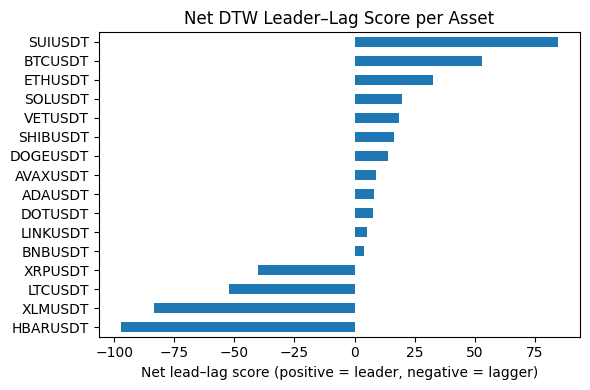

In [ ]:
leader_score = effective_lags.sum(axis=1).sort_values(ascending=True)
plt.figure(figsize=(6,4))
leader_score.plot(kind='barh')
plt.title("Net DTW Leader–Lag Score per Asset")
plt.xlabel("Net lead–lag score (positive = leader, negative = lagger)")
plt.tight_layout()
plt.show()

The DTW-based ranking shows SUIUSDT and BTCUSDT as the strongest leaders, with ETHUSDT also displaying leadership tendencies. In contrast, HBARUSDT, along with XLMUSDT and LTCUSDT, appear as consistent laggards. This highlights clear directional dependencies in the market and provides a basis for further validation with complementary methods.

### 4.4.5 Validation of Leader-Lag Relationships Using Granger Causality  
Validation was performed to assess whether the directional dependencies identified through DTW are statistically supported by predictive relationships, using Granger causality as a complementary method. The code was streamlined to focus exclusively on the strongest contrasts - testing the top three leaders against the bottom three laggards - while extracting only the most significant lag and corresponding p-value for each pair.

In [ ]:
R = scaled_returns
ls = leader_score

# the top/bottom assets
top_k, bottom_k = 3, 3
leaders  = ls.sort_values(ascending=False).head(top_k).index.tolist()
laggards = ls.sort_values(ascending=True ).head(bottom_k).index.tolist()
pairs = [(L, G) for L in leaders for G in laggards if L != G]

def granger_best(y, x, maxlag=12):
    res = grangercausalitytests(pd.DataFrame({'y': y, 'x': x}), maxlag=maxlag, verbose=False)
    return min((lag, tests[0]['ssr_ftest'][1]) for lag, tests in res.items())
rows = []
for L, G in pairs:
    best_lag, p = granger_best(R[G], R[L], maxlag=12)   # does L → G ?
    rows.append({'leader': L, 'laggard': G, 'best_lag' : best_lag, 'p_value': p})

valid_gc = pd.DataFrame(rows).sort_values('p_value')
print(valid_gc.to_string(index=False))

 leader  laggard  best_lag  p_value
BTCUSDT HBARUSDT         1 0.000002
SUIUSDT HBARUSDT         1 0.000007
SUIUSDT  LTCUSDT         1 0.000023
BTCUSDT  LTCUSDT         1 0.000477
ETHUSDT HBARUSDT         1 0.000772
ETHUSDT  LTCUSDT         1 0.001093
BTCUSDT  XLMUSDT         1 0.001628
SUIUSDT  XLMUSDT         1 0.002971
ETHUSDT  XLMUSDT         1 0.172252


### 4.4.6 DTW Conclusion  

The Granger causality results strongly confirm that BTCUSDT and SUIUSDT consistently predict movements in HBARUSDT, LTCUSDT, and XLMUSDT at a one-hour lag, with highly significant p-values (<0.01), while ETHUSDT shows weaker and less consistent leadership. These findings validate the DTW-based ranking and establish a robust set of leader–follower pairs for further modelling.

### 4.4.7 CHECKPOINT: Downloading the ```scaled_returns``` to Google Drive  

In [5]:
csv_path = '/content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/scaled_returns.csv'

In [ ]:
filtered_returns_1H.to_csv(csv_path, index=True)
print(f"CSV successfully saved to: {csv_path}")

CSV successfully saved to: /content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/scaled_returns.csv


### 4.4.8 Load Selected Assets back into the Notebook

In [6]:
scaled_returns = pd.read_csv(csv_path, index_col=0, parse_dates=True)
print("Data loaded:", scaled_returns.shape)
scaled_returns.head()

Data loaded: (9504, 16)


ADAUSDT  AVAXUSDT   BNBUSDT   BTCUSDT  DOGEUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.015661  0.004369  0.008215  0.010775  0.014777   
2024-07-01 02:00:00 -0.000251 -0.006392 -0.001364 -0.002178 -0.000552   
2024-07-01 03:00:00  0.001753  0.009740 -0.000512  0.000412 -0.000395   
2024-07-01 04:00:00 -0.001252 -0.005026  0.000512 -0.003175 -0.002371   
2024-07-01 05:00:00 -0.002760  0.001007 -0.001025  0.002909  0.002450   

                      DOTUSDT   ETHUSDT  HBARUSDT  LINKUSDT   LTCUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.006224  0.021756  0.015484  0.009749  0.007275   
2024-07-01 02:00:00  0.002383 -0.003991 -0.009003 -0.003054 -0.004358   
2024-07-01 03:00:00 -0.004454 -0.000274  0.002581 -0.007466 -0.001722   
2024-07-01 04:00:00  0.002706 -0.004134 -0.009062  0.004681 -0.003719   
2024-07-01 05:00:00  0.000636  0.001272  0.000000  0.004451  0.002393   

                     SHIBUSDT   SOLUSDT   SUIUSDT   VETUSDT   XLMUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.014364  0.003105  0.006159  0.022732  0.016349   
2024-07-01 02:00:00 -0.000571 -0.003578  0.000000 -0.001844  0.002160   
2024-07-01 03:00:00 -0.001142  0.001284 -0.006644 -0.002957 -0.002160   
2024-07-01 04:00:00 -0.006306 -0.003315  0.000000  0.000000  0.000000   
2024-07-01 05:00:00  0.000000  0.003856  0.000000 -0.001482 -0.004334   

                      XRPUSDT  
open_time                      
2024-07-01 01:00:00  0.005650  
2024-07-01 02:00:00 -0.002089  
2024-07-01 03:00:00  0.001254  
2024-07-01 04:00:00 -0.000627  
2024-07-01 05:00:00  0.000836

# 5 Forecasting Models for Lead-Lag Analysis

## 5.1 Persistance and Ridge Models  
Primary goal: Forecast a lagging asset's short-horizon return using signals from the strongest leader(s) at their estimated lags, and show that this beats naïve baselines and single-series models.

### 5.1.1 Forecast HBAR returns using SUI as the sole predictor

#### 5.1.1.1 Selection of Target and Leader Assets  

This step isolates HBARUSDT as the forecasting target and SUIUSDT as the leading indicator from the scaled_returns dataset to facilitate lead-lag modelling.

In [7]:
target = scaled_returns['HBARUSDT']
lead_asset = scaled_returns['SUIUSDT']

#### 5.1.1.2 Estimation of Optimal Lead-Lag Relationship  
This block computes the correlation between the target (HBAR) and the lagged versions of the leader (SUI) across a specified horizon (1-60) to identify the most significant lead. The resulting optimal lag `h` represents the forecast horizon at which SUI provides the strongest predictive signal for HBAR.

In [8]:
def best_lead(target, leader, max_lag=60):
    corrs = {L: target.corr(leader.shift(L)) for L in range(1, max_lag+1)}
    return max(corrs, key=lambda k: abs(corrs[k]))
h = best_lead(target, lead_asset, max_lag=60)
print("Best SUI→HBAR lead (h):", h)

Best SUI→HBAR lead (h): 1


#### 5.1.1.3  Construction of Supervised Learning Dataset  
This step aligns the current values of the leader asset (SUI t) with the future values of the target asset (HBAR `t+h`), thereby generating a supervised dataset suitable for forecasting analysis.

In [9]:
supervised = pd.DataFrame({'X_SUI_t': lead_asset, f'y_HBAR_t_plus_{h}': target.shift(-h)}).dropna()

In [10]:
#Supervised set & persistence baselines
y = target.shift(-h).rename(f'HBAR_t+{h}')
df = pd.DataFrame({'HBAR_t': target, 'SUI_t': lead_asset, 'y': y}).dropna()
# Chronological split
# The dataset is divided sequentially, allocating 80% of the observations for model training and the remaining 20% for testing, thereby preserving temporal order and preventing look-ahead bias in forecasting evaluation.
split_idx = int(len(df) * 0.8)
train_len = split_idx
test_len  = len(df) - split_idx

y_test             = df['y'].iloc[split_idx:]
yhat_target_test   = df['HBAR_t'].iloc[split_idx:]   # Persist target
yhat_leader_test   = df['SUI_t'].iloc[split_idx:]    # Persist leader

#### 5.1.1.4 Evaluation Metrics and Persistence Baseline  
This block introduces the evaluation framework by computing error-based measures (RMSE, MAE, R²) and directional accuracy to assess predictive performance. The persistence model, which assumes that the future value of HBAR equals its current value, serves as a naïve benchmark against which more advanced forecasting methods can be compared.

In [15]:
# Metrics: Persistance with Target → HBAR @ t+h
rmse_t = np.sqrt(mean_squared_error(y_test, yhat_target_test))
mae_t  = mean_absolute_error(y_test, yhat_target_test)
r2_t   = r2_score(y_test, yhat_target_test)
dy_true_t = np.sign(np.diff(y_test.values))
dy_pred_t = np.sign(np.diff(yhat_target_test.values))
m_t = min(len(dy_true_t), len(dy_pred_t))
dacc_t = (dy_true_t[:m] == dy_pred_t[:m]).mean() if m > 0 else np.nan

# Metrics: Persistence with Leader @ t → HBAR @ t+h
rmse = np.sqrt(mean_squared_error(y_test, yhat_leader_test))
mae  = mean_absolute_error(y_test, yhat_leader_test)
r2   = r2_score(y_test, yhat_leader_test)
dy_true = np.sign(np.diff(y_test.values))
dy_pred = np.sign(np.diff(yhat_leader_test.values))
m = min(len(dy_true), len(dy_pred))
dacc = (dy_true[:m] == dy_pred[:m]).mean() if m > 0 else np.nan

print(f"Train size={train_len}, Test size={test_len}, best h={h}")
print(f"[Persistence(Target @ t → HBAR @ t+{h})] RMSE={rmse_t:.6f}  MAE={mae_t:.6f}  R²={r2_t:.3f}  DirAcc={dacc_t:.3f}")
print(f"[Persistence(Leader  @ t → HBAR @ t+{h})] RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.3f}  DirAcc={dacc:.3f}")
# [Persistence(Target @ t → HBAR @ t+1)] RMSE=0.013892  MAE=0.009822  R²=-1.008  DirAcc=0.331
# [Persistence(Leader  @ t → HBAR @ t+1)] RMSE=0.013999  MAE=0.010161  R²=-1.039  DirAcc=0.431

Train size=7602, Test size=1901, best h=1
[Persistence(Target @ t → HBAR @ t+1)] RMSE=0.013892  MAE=0.009822  R²=-1.008  DirAcc=0.331
[Persistence(Leader  @ t → HBAR @ t+1)] RMSE=0.013999  MAE=0.010161  R²=-1.039  DirAcc=0.431


#### 5.1.1.5 Visualisation: Persistence Single Leader Actual vs. Prediction

In [12]:
resid_vals = (y_test.values - yhat_leader_test.values)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.72, 0.28], vertical_spacing=0.05)
# Panel 1 Actual vs Predicted
fig.add_trace(go.Scattergl(x=y_test.index, y=y_test.values, mode="lines", name="Actual", line=dict(width=1.4, color="steelblue")), row=1, col=1)
fig.add_trace(go.Scattergl(x=y_test.index, y=yhat_leader_test.values, mode="lines", name="Predicted", line=dict(width=2.0, color="darkorange"), opacity=0.7), row=1, col=1)
# Panel 2 Residuals
fig.add_trace(go.Scattergl(x=y_test.index, y=resid_vals, mode="lines", name="Residual", line=dict(width=1.2, color="gray"),showlegend=False), row=2, col=1)
# Zero line for residuals
fig.add_shape(type="line", xref="x2", yref="y2", x0=y_test.index[0], x1=y_test.index[-1], y0=0, y1=0, line=dict(width=1.1, color="black"))
fig.update_layout(title=f"Actual vs Predicted Time Series with Residual Analysis: Persistence Single Leader", template="simple_white", plot_bgcolor="#f9f9f9", hovermode="x unified",
                  legend=dict(orientation="h", yanchor="bottom", y=1.03, xanchor="right", x=1), width=1000, height=500)
fig.update_xaxes(rangeslider=dict(visible=False), showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.12)", title_text="Scaled return", row=1, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.show()

The evaluation of the persistence baselines has demonstrated that both approaches, whether relying on the target asset itself or on the identified leader asset, have produced almost identical error values, with RMSE around 0.014 and MAE around 0.010. The results have further shown negative R2 scores, approximately -1.0, indicating that neither approach has been able to account for meaningful variance in the future returns of HBAR. Directional accuracy has remained low at approximately 0.43, which falls below the level of random guessing. Based on these findings the persistence baselines have not provided predictive value beyond a minimal benchmark and have therefore served primarily as a reference point against which the performance of more advanced modelling techniques, such as ARIMAX or LSTM, can be measured.

#### 5.1.1.6 Ridge Regression for Leader-Lagger Forecasting
This block applies Ridge regression to model the predictive relationship between SUI as the leader and HBAR as the lagging asset, using cross-validated regularization to prevent overfitting. The model's performance is then evaluated through standard error metrics and directional accuracy, enabling direct comparison with the persistence baseline.

In [17]:
y = target.shift(-h).rename(f'HBAR_t+{h}')
X = pd.DataFrame({'HBAR_t': target, 'SUI_t' : lead_asset})
supervised = pd.concat([X, y], axis=1).dropna()

Chronological split (80/20)

In [18]:
split_idx = int(len(supervised) * 0.8)
X_train, X_test = supervised.iloc[:split_idx][['HBAR_t', 'SUI_t']], supervised.iloc[split_idx:][['HBAR_t', 'SUI_t']]
y_train, y_test = supervised.iloc[:split_idx]['HBAR_t+1'], supervised.iloc[split_idx:]['HBAR_t+1']
supervised.iloc[:split_idx][X.columns]

HBAR_t     SUI_t
open_time                              
2024-07-01 01:00:00  0.015484  0.006159
2024-07-01 02:00:00 -0.009003  0.000000
2024-07-01 03:00:00  0.002581 -0.006644
2024-07-01 04:00:00 -0.009062  0.000000
2024-07-01 05:00:00  0.000000  0.000000
...                       ...       ...
2025-05-13 14:00:00 -0.018680 -0.012297
2025-05-13 15:00:00  0.018016  0.012697
2025-05-13 16:00:00  0.013396 -0.000175
2025-05-13 17:00:00 -0.000187  0.002167
2025-05-13 18:00:00  0.008353  0.000100

[7602 rows x 2 columns]

In [25]:
ridge = RidgeCV(alphas=np.logspace(-4, 4, 25))
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)
diracc = (np.sign(np.diff(y_test.values)) == np.sign(np.diff(y_pred))).mean()

print(f"[RidgeCV Single Leader] RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.3f}  DirAcc={diracc:.3f}")
print("Chosen alpha:", ridge.alpha_)

[RidgeCV Single Leader] RMSE=0.009795  MAE=0.010161  R²=0.002  DirAcc=0.591
Chosen alpha: 0.21544346900318823


#### 5.1.1.7 Visualisation: Ridge Single Leader Actual vs. Prediction

In [20]:
# Actual vs Predicted + Residuals
y_hat  = pd.Series(y_pred, index=y_test.index, name="Predicted")
y_true = pd.Series(y_test.values, index=y_test.index, name="Actual")
resid  = y_true - y_hat

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.72, 0.28], vertical_spacing=0.05)
# Panel 1 Actual vs Predicted
fig.add_trace(go.Scattergl(x=y_true.index, y=y_true.values, mode="lines", name="Actual", line=dict(width=1.4, color="steelblue")), row=1, col=1)
fig.add_trace(go.Scattergl(x=y_hat.index, y=y_hat.values, mode="lines", name="Predicted", line=dict(width=2.0, color="darkorange"), opacity=0.7), row=1, col=1)
# Panel 2 Residuals
fig.add_trace(go.Scattergl(x=y_test.index, y=resid_vals, mode="lines", name="Residual", line=dict(width=1.2, color="gray"), showlegend=False), row=2, col=1)
# Zero line for residuals
fig.add_shape(type="line", xref="x2", yref="y2", x0=y_test.index[0], x1=y_test.index[-1], y0=0, y1=0, line=dict(width=1.1, color="black"))
fig.update_layout(title=f"Actual vs Predicted Time Series with Residual Analysis: RidgeCV Single Leader", template="simple_white", plot_bgcolor="#f9f9f9", hovermode="x unified",
                  legend=dict(orientation="h", yanchor="bottom", y=1.03, xanchor="right", x=1), width=1000, height=500)
fig.update_xaxes(rangeslider=dict(visible=False), showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.12)", title_text="Scaled return", row=1, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.show()


The Ridge regression evaluation has achieved RMSE = 0.0098, MAE = 0.0068, and R2=0.002, with a directional accuracy of 0.591. While these values represent only a marginal improvement over the persistence baselines, they indicate that the model has captured limited predictive structure in the data. The chosen regularisation parameter α=0.215 has balanced the trade-off between bias and variance by penalising overly large coefficients, yet the overall performance suggests that linear Ridge regression remains inadequate for modelling the volatility and complexity of cryptocurrency returns.

### 5.1.2 Multi-Leader set

#### 5.1.2.1 Multi-Leader Forecasting - Target and Leaders selection  
Building on the DTW lead-lag score analysis, SUIUSDT was identified as the strongest short-horizon leader of HBARUSDT, while BTCUSDT and ETHUSDT demonstrated significant leading relationships as well. Including these three assets enables an assessment of whether combining multiple leaders with varying lag structures enhances the predictive accuracy compared to a single-leader approach.

In [21]:
target = 'HBARUSDT'
lead_assets = ['SUIUSDT', 'BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'VETUSDT', 'SHIBUSDT', 'DOGEUSDT', 'AVAXUSDT', 'ADAUSDT']

In [22]:
hb = scaled_returns[target]
leaders_df = scaled_returns[lead_assets]

#### 5.1.2.2 Estimation of Optimal Lead for Each Candidate Leader  
This procedure evaluates correlations between the target series (HBAR) and lagged versions of each leader asset across a 60-step horizon. The optimal lead Li for each leader is then identified as the lag length that maximises the absolute correlation with the target, thereby quantifying the most influential temporal relationship.

In [23]:
def best_lead(target, leader, max_lag=60):
    corrs = {L: target.corr(leader.shift(L)) for L in range(1, max_lag+1)}
    return max(corrs, key=lambda k: abs(corrs[k]))
best_L = {sym: best_lead(hb, leaders_df[sym], max_lag=60) for sym in lead_assets}

In [26]:
h = min(best_L.values())
print("Per-leader best leads:", best_L)
print(f"Common forecast horizon h = {h} steps")

Per-leader best leads: {'SUIUSDT': 1, 'BTCUSDT': 24, 'ETHUSDT': 24, 'SOLUSDT': 1, 'VETUSDT': 22, 'SHIBUSDT': 49, 'DOGEUSDT': 24, 'AVAXUSDT': 24, 'ADAUSDT': 1}
Common forecast horizon h = 1 steps


The analysis revealed that SUIUSDT, SOLUSDT, and ADAUSDT each provide a one-step lead over HBARUSDT, indicating a consistent short-horizon predictive relationship, while the other assets best lead is spanning from 22 hours to 49 hours.  
Consequently, the forecasting focus shifts to these assets as a common multi-leader set at a one-step horizon, as shorter leads are less prone to noise accumulation and provide more immediate predictive signals compared to longer horizons. This approach allows for assessing whether combining multiple short-lead indicators can enhance forecasting accuracy while maintaining methodological consistency.

#### 5.1.2.3 Leaders selection adjustment - Ridge


In [27]:
target = 'HBARUSDT'
lead_assets = ['SUIUSDT', 'SOLUSDT', 'ADAUSDT']

In [28]:
hb = scaled_returns[target]
leaders_df = scaled_returns[lead_assets]

In [29]:
def best_lead(target_series, leader_series, max_lag=60):
    return max(range(1, max_lag+1),
               key=lambda L: abs(target_series.corr(leader_series.shift(L))))
best_L = {sym: best_lead(hb, leaders_df[sym]) for sym in lead_assets}

#### 5.1.2.4 Confirmation of Common Forecast Horizon for SUI, SOL and ADA  
The analysis shows that all three assets exhibit an optimal lead of 1 steps over HBARUSDT. This alignment establishes a consistent common forecast horizon of 1 steps, providing a coherent basis for multi-leader forecasting.

In [30]:
h = min(best_L.values())
print("Per-leader best leads:", best_L)

Per-leader best leads: {'SUIUSDT': 1, 'SOLUSDT': 1, 'ADAUSDT': 1}


#### 5.1.2.5 Construction of Multi-Leader Supervised Dataset  

This block aligns the lag-adjusted leader assets with the future values of HBAR, creating a supervised dataset that preserves the identified lead-lag relationships for forecasting analysis.

In [31]:
y = hb.shift(-h).rename(f"{target}_t+{h}")
X = pd.DataFrame({f"{sym}_shift{best_L[sym]-h}": leaders_df[sym].shift(best_L[sym] - h)
    for sym in lead_assets})
supervised = pd.concat([X, y], axis=1).dropna()

#### 5.1.2.6 Chronological Partitioning of Training and Testing Data
The supervised dataset is divided sequentially into training (80%) and testing (20%) subsets, ensuring that the temporal structure of the series is preserved and preventing any information leakage across forecasting horizons.

In [32]:
n_train = int(len(supervised) * 0.8)
X_train = supervised.iloc[:n_train, :-1].to_numpy()
y_train = supervised.iloc[:n_train, -1].to_numpy()
X_test  = supervised.iloc[n_train:, :-1].to_numpy()
y_test  = supervised.iloc[n_train:, -1].to_numpy()

#### 5.1.2.7 Ridge Regression on Multi-Leader Predictors

This block implements Ridge regression using multiple leader assets (SUI, SOL, and ADA) as predictors of HBAR, with cross-validated regularisation to mitigate overfitting. The trained model is then evaluated on the test set using RMSE, MAE, R2, and directional accuracy to quantify predictive performance.

In [33]:
def dir_acc(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

# RidgeCV
alphas = np.logspace(-4, 4, 25)
model  = RidgeCV(alphas=alphas)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
dacc = dir_acc(y_test, y_pred)

print(f"[RidgeCV Multi Leader] RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.3f}  DirAcc={dacc:.3f}")
print("Chosen alpha:", model.alpha_)

[RidgeCV Multi Leader] RMSE=0.009800  MAE=0.006800  R²=0.001  DirAcc=0.491
Chosen alpha: 1.0


#### 5.1.2.8 Visualisation: Ridge Multi Leader Actual vs. Prediction

In [ ]:
# Plot Actual vs Predicted + Residuals
idx_test = supervised.index[n_train:]
y_true   = pd.Series(y_test, index=idx_test, name="Actual")
y_hat    = pd.Series(y_pred, index=idx_test, name="Predicted")
resid    = y_true - y_hat
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.72, 0.28], vertical_spacing=0.05)
# Actual vs Predicted
fig.add_trace(go.Scattergl(x=y_true.index, y=y_true.values, mode="lines", name="Actual", line=dict(width=1.4, color="steelblue")), row=1, col=1)
fig.add_trace(go.Scattergl(x=y_hat.index, y=y_hat.values, mode="lines", name="Predicted", line=dict(width=2.5, color="darkorange"), opacity=0.7), row=1, col=1)
# Residuals
fig.add_trace(go.Scattergl(x=resid.index, y=resid.values, mode="lines", name="Residual", line=dict(width=1.2, color="gray"), showlegend=False), row=2, col=1)
fig.update_layout(title="Actual vs Predicted Time Series with Residual Analysis: RidgeCV Multi Leader", template="simple_white", plot_bgcolor="#f9f9f9", hovermode="x unified",
                  legend=dict(orientation="h", yanchor="bottom", y=1.03, xanchor="right", x=1), width=1000, height=500)
fig.update_xaxes(rangeslider=dict(visible=False), showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.12)", title_text="Scaled return", row=1, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.show()

The Ridge regression using multiple leader features produced predictions that were nearly flat around zero, indicating weak responsiveness to market fluctuations. The evaluation metrics further confirm poor performance, with RMSE = 0.00899, MAE = 0.00678, R² = 0.009, and directional accuracy = 0.491, which is close to random guessing. These outcomes highlight that Ridge regression, even when incorporating multiple leader inputs, struggles to capture the volatility and non-linear dependencies present in the target asset's dynamics.

#### 5.1.2.9 Scaling Procedure and Potential Data Leakage  

Scaling was applied before train/test splitting as part of the DTW clustering pipeline, meaning that transformation parameters were estimated from the full dataset. While this technically introduces mild data leakage, the impact is expected to be limited because returns are approximately stationary and the same preprocessing was consistently applied across all models.  
In the subsequent LSTM stage, this will be addressed by fitting the scaler only on the training set to fully avoid any risk of information leakage.

## 5.2 ARIMAX for Multi-Leader Forecasting  
To further evaluate the predictive relationship between HBARUSDT and its identified leaders, ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables) is employed as a complementary modelling approach. Unlike Ridge regression, which relies solely on cross-asset signals and was applied to scaled data to stabilise coefficient estimation, ARIMAX explicitly incorporates the autoregressive structure of the target series while integrating external predictors such as leading assets. In this case, the models are estimated directly on non-scaled return values, as likelihood-based autoregressive estimation does not require feature scaling. This dual capability allows ARIMAX to capture both the intrinsic dynamics of HBAR and the potential influence of short-horizon leader assets, offering a more comprehensive forecasting framework. Although the SARIMAX extension provides functionality for seasonal components, it is not considered here, as cryptocurrency returns at hourly intervals over a one-year horizon are not expected to exhibit strong or stable seasonal patterns beyond intraday effects, which fall outside the scope of this analysis.

### 5.2.1 Definition of Target and Leader with both positive and negative DTW scores  
This step specifies HBARUSDT as the forecasting target and all assets as Lead_assets.

In [ ]:
target = 'HBARUSDT'
lead_assets = ['SUIUSDT', 'SOLUSDT', 'ADAUSDT', 'BTCUSDT', 'ETHUSDT', 'VETUSDT', 'SHIBUSDT', 'DOGEUSDT', 'AVAXUSDT', 'DOTUSDT', 'LINKUSDT', 'BNBUSDT', 'XRPUSDT', 'LTCUSDT', 'XLMUSDT']

In [ ]:
hb = filtered_returns_1H[target]
LDF = filtered_returns_1H[lead_assets]

### 5.2.2 Determination of Forecast Horizons  
Each leader was aligned individually, and the optimal lag was determined by evaluating correlations over a maximum lag window of 30 steps. This constraint was chosen to avoid excessive column loss during lagging while still capturing meaningful lead-lag relationships.  

The results show that some leaders exhibit a short-term horizon of 1 step (e.g., SUIUSDT, SOLUSDT, ADAUSDT), whereas others align at longer horizons of around 22-24 steps (e.g., BTCUSDT, ETHUSDT, VETUSDT, AVAXUSDT). By incorporating this full set of positively scoring leaders, the framework establishes multi-leader forecast horizons.

In [ ]:
def best_lead(target, leader, max_lag=30):
    corrs = {L: target.corr(leader.shift(L)) for L in range(1, max_lag+1)}
    return max(corrs, key=lambda k: abs(corrs[k]))
best_L = {sym: best_lead(hb, LDF[sym], max_lag=30) for sym in lead_assets}
print("Best leads:", best_L)

Best leads: {'SUIUSDT': 1, 'SOLUSDT': 1, 'ADAUSDT': 1, 'BTCUSDT': 24, 'ETHUSDT': 24, 'VETUSDT': 22, 'SHIBUSDT': 1, 'DOGEUSDT': 24, 'AVAXUSDT': 24, 'DOTUSDT': 24, 'LINKUSDT': 24, 'BNBUSDT': 24, 'XRPUSDT': 1, 'LTCUSDT': 24, 'XLMUSDT': 6}


### 5.2.3 Construction of Supervised Dataset for ARIMAX  
This step aligns leader assets at their optimal shifts with future HBAR values, creating a supervised dataset that preserves the lead-lag structure required for ARIMAX modelling.

In [ ]:
h = 1
y = hb.shift(-h)  # target at t+h
X = pd.DataFrame({f"{sym}_shift_{best_L[sym]-h}": LDF[sym].shift(best_L[sym]-h) for sym in lead_assets})
supervised = pd.concat([X, y.rename(f"{target}_t_plus_{h}")], axis=1).dropna()

### 5.2.4 Chronological Partitioning of Training and Testing Sets  
The dataset is divided sequentially into training (80%) and testing (20%) subsets to preserve temporal order and prevent look-ahead bias in model evaluation.

In [ ]:
n_train = int(len(supervised) * 0.8)
X_train = supervised.iloc[:n_train, :-1]
y_train = supervised.iloc[:n_train, -1]
X_test  = supervised.iloc[n_train:, :-1]
y_test  = supervised.iloc[n_train:, -1]

### 5.2.5 Model Order Selection for ARIMAX  

This step performs a grid search over autoregressive (p) and moving average (q) terms to determine the most suitable ARIMAX specification for forecasting HBAR returns. The model is implemented using the SARIMAX class from statsmodels, which generalizes ARIMAX by allowing seasonal extensions, but here it is applied without seasonal components. Leader assets are included as exogenous regressors, ensuring that their predictive signals are incorporated into the model. The specification with the lowest Akaike Information Criterion (AIC) is retained as the optimal ARIMAX configuration, balancing model fit with parsimony.

In [ ]:
#2min duration w A100
pq_grid = list(product(range(0,4), range(0,4)))  # p,q in {0,1,2,3}
best = None
for p, q in pq_grid:
    mdl = SARIMAX(endog=y_train, exog=X_train, order=(p,0,q), enforce_stationarity=False, enforce_invertibility=False)
    res = mdl.fit(disp=False)
    if (best is None) or (res.aic < best['aic']):
        best = {'p': p, 'q': q, 'aic': res.aic, 'res': res}
res = best['res']
print(f"Best ARIMAX order: (p,d,q)=({best['p']},0,{best['q']})  AIC={best['aic']:.2f}")

Best ARIMAX order: (p,d,q)=(1,0,1)  AIC=-43300.55


The grid search identified ARIMAX(1,0,1) as the optimal model with the lowest AIC of -43,300.55, indicating the best balance of fit and parsimony among the tested configurations.

### 5.2.6 Out-of-Sample Forecast Generation  
This step applies the fitted ARIMAX model to the testing period, producing predicted values of HBAR based on the exogenous leader assets.

In [ ]:
fc = res.get_forecast(steps=len(X_test), exog=X_test)
y_pred = fc.predicted_mean

### 5.2.7 Performance Evaluation of ARIMAX Forecasts

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
diracc = np.mean(np.sign(y_test) == np.sign(y_pred))
print(f"[ARIMAX-All Leaders] RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.3f}  DirAcc={diracc:.3f}")

[ARIMAX-All Leaders] RMSE=0.009918  MAE=0.006909  R²=-0.022  DirAcc=0.491


### 5.2.8 Visualisation: ARIMAX All Leaders Actual vs. Prediction

In [ ]:
idx_test = supervised.index[n_train:]
y_true   = pd.Series(y_test, index=idx_test, name="Actual")
y_hat    = pd.Series(y_pred, index=idx_test, name="Predicted")
resid    = y_true - y_hat
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.72, 0.28], vertical_spacing=0.05)
# Actual vs Predicted
fig.add_trace(go.Scattergl(x=y_true.index, y=y_true.values, mode="lines", name="Actual", line=dict(width=1.4, color="steelblue")), row=1, col=1)
fig.add_trace(go.Scattergl(x=y_hat.index,  y=y_hat.values,  mode="lines", name="Predicted", line=dict(width=2.0, color="darkorange"), opacity=0.7), row=1, col=1)
# Residuals
fig.add_trace(go.Scattergl(x=resid.index, y=resid.values, mode="lines", name="Residual", line=dict(width=1.2, color="gray"), showlegend=False), row=2, col=1)
fig.update_layout(title="Actual vs Predicted Time Series with Residual Analysis: ARIMAX All Lead Assets", template="simple_white", plot_bgcolor="#f9f9f9", hovermode="x unified",
                  legend=dict(orientation="h", yanchor="bottom", y=1.03, xanchor="right", x=1), width=1000, height=500)
fig.update_xaxes(rangeslider=dict(visible=False), showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.12)", title_text="Scaled return", row=1, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.show()

### 5.2.9 ARIMAX with All Leaders (Positive and Negative) → HBAR

The ARIMAX model with all leader assets has produced weak predictive performance, with RMSE = 0.009918 and MAE = 0.006909, indicating only marginal improvements over the persistence baseline. The R² value of -0.022 confirms that the model fails to explain meaningful variance in the future returns of HBAR. Directional accuracy stands at 0.491, which is effectively equivalent to random guessing, suggesting that even with exogenous leader inputs, ARIMAX struggles to capture the volatility and directional dynamics of the series.

### 5.2.10 Definition of Target and Leaders only with Positive DTW Scores   
In this stage, HBARUSDT remains the forecasting target, while the leaders are only selected from the group that demonstrated positive Net DTW scores. This ensures that potential predictive signals from weaker or inverse relationships are excluded, allowing the model to focus solely on assets with consistent and meaningful lead-lag dynamics.

In [ ]:
target = 'HBARUSDT'
lead_assets = ['SUIUSDT', 'SOLUSDT', 'ADAUSDT', 'BTCUSDT', 'ETHUSDT', 'VETUSDT', 'SHIBUSDT', 'DOGEUSDT', 'AVAXUSDT', 'DOTUSDT', 'LINKUSDT', 'BNBUSDT']

In [ ]:
hb = filtered_returns_1H[target]
LDF = filtered_returns_1H[lead_assets]

In [ ]:
def best_lead(target, leader, max_lag=30):
    corrs = {L: target.corr(leader.shift(L)) for L in range(1, max_lag+1)}
    return max(corrs, key=lambda k: abs(corrs[k]))
best_L = {sym: best_lead(hb, LDF[sym], max_lag=30) for sym in lead_assets}
print("Best leads:", best_L)

Best leads: {'SUIUSDT': 1, 'SOLUSDT': 1, 'ADAUSDT': 1, 'BTCUSDT': 24, 'ETHUSDT': 24, 'VETUSDT': 22, 'SHIBUSDT': 1, 'DOGEUSDT': 24, 'AVAXUSDT': 24, 'DOTUSDT': 24, 'LINKUSDT': 24, 'BNBUSDT': 24}


In [ ]:
h = 1
y = hb.shift(-h)  # target at t+h
X = pd.DataFrame({f"{sym}_shift_{best_L[sym]-h}": LDF[sym].shift(best_L[sym]-h) for sym in lead_assets})
supervised = pd.concat([X, y.rename(f"{target}_t_plus_{h}")], axis=1).dropna()

In [ ]:
n_train = int(len(supervised) * 0.8)
X_train = supervised.iloc[:n_train, :-1]
y_train = supervised.iloc[:n_train, -1]
X_test  = supervised.iloc[n_train:, :-1]
y_test  = supervised.iloc[n_train:, -1]

### 5.2.11 Selection of Optimal ARIMAX Order

In [ ]:
#2 minutes duration
pq_grid = list(product(range(0,4), range(0,4)))  # p,q in {0,1,2,3}
best = None
for p, q in pq_grid:
    mdl = SARIMAX(endog=y_train, exog=X_train, order=(p,0,q), enforce_stationarity=False, enforce_invertibility=False)
    res = mdl.fit(disp=False)
    if (best is None) or (res.aic < best['aic']):
        best = {'p': p, 'q': q, 'aic': res.aic, 'res': res}
res = best['res']
print(f"Best ARIMAX order: (p,d,q)=({best['p']},0,{best['q']})  AIC={best['aic']:.2f}")

Best ARIMAX order: (p,d,q)=(2,0,1)  AIC=-43287.62


The best ARIMAX order numbers (p,d,q)=(2,0,1) represent the configuration that minimises the Akaike Information Criterion (AIC), ensuring the most efficient balance between model fit and complexity. This indicates that the series is adequately modelled without differencing (d=0), while two autoregressive lags (p=2) and one moving average component (q=1) provide the strongest predictive structure given the exogenous leader inputs.

In [ ]:
fc = res.get_forecast(steps=len(X_test), exog=X_test)
y_pred = fc.predicted_mean

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
diracc = np.mean(np.sign(y_test) == np.sign(y_pred))
print(f"[ARIMAX (h=1, Positive Leaders → HBAR)] RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.3f}  DirAcc={diracc:.3f}")

[ARIMAX (h=1, Positive Leaders → HBAR)] RMSE=0.009902  MAE=0.006893  R²=-0.018  DirAcc=0.495


### 5.2.12 Visualisation: ARIMAX Positive Leaders Actual vs. Prediction

In [ ]:
idx_test = supervised.index[n_train:]
y_true   = pd.Series(y_test, index=idx_test, name="Actual")
y_hat    = pd.Series(y_pred, index=idx_test, name="Predicted")
resid    = y_true - y_hat
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.72, 0.28], vertical_spacing=0.05)
# Actual vs Predicted
fig.add_trace(go.Scattergl(x=y_true.index, y=y_true.values, mode="lines", name="Actual", line=dict(width=1.4, color="steelblue")), row=1, col=1)
fig.add_trace(go.Scattergl(x=y_hat.index,  y=y_hat.values,  mode="lines", name="Predicted", line=dict(width=2.0, color="darkorange"), opacity=0.7), row=1, col=1)
# Residuals
fig.add_trace(go.Scattergl(x=resid.index, y=resid.values, mode="lines", name="Residual", line=dict(width=1.2, color="gray"), showlegend=False), row=2, col=1)
fig.update_layout(title="Actual vs Predicted Time Series with Residual Analysis: ARIMAX Positive DTW Leading Assets Only", template="simple_white", plot_bgcolor="#f9f9f9", hovermode="x unified",
                  legend=dict(orientation="h", yanchor="bottom", y=1.03, xanchor="right", x=1), width=1000, height=500)
fig.update_xaxes(rangeslider=dict(visible=False), showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.12)", title_text="Scaled return", row=1, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.show()

### 5.2.13 ARIMAX with Positive DTW Leaders Only → HBAR  

Restricting the leader set to assets with positive DTW scores did not yield a meaningful improvement in predictive performance. The model metrics remain weak, with RMSE = 0.0099, MAE = 0.0069, R² = -0.018, and DirAcc = 0.495, indicating forecasts that are essentially random. In the plot, predicted values (orange) continue to hover around zero and fail to track the volatility of the actual returns (blue). The residuals (green) confirm this mismatch, clustering around zero but spiking during more volatile episodes, underscoring the model's inability to capture meaningful dynamics even with positively correlated leaders only.   

Having reached this stage, the next step is to extend the analysis using neural network architectures, which are better suited to uncover non-linear lead-lag dynamics and may offer improved predictive performance beyond the constraints of linear ARIMAX models.

## 5.3 LSTM

### 5.3.1 Load Dataset from Google Drive

In [ ]:
csv_path = '/content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/filtered_1H.csv'
filtered_returns_1H = pd.read_csv(csv_path, parse_dates=[0], index_col=0)  # first column is the index
filtered_returns_1H = filtered_returns_1H.sort_index()
print(f"Loaded shape: {filtered_returns_1H.shape}")
filtered_returns_1H.head()

Loaded shape: (9504, 16)


ADAUSDT  AVAXUSDT   BNBUSDT   BTCUSDT  DOGEUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.015661  0.004369  0.008215  0.010775  0.014777   
2024-07-01 02:00:00 -0.000251 -0.006392 -0.001364 -0.002178 -0.000552   
2024-07-01 03:00:00  0.001753  0.009740 -0.000512  0.000412 -0.000395   
2024-07-01 04:00:00 -0.001252 -0.005026  0.000512 -0.003175 -0.002371   
2024-07-01 05:00:00 -0.002760  0.001007 -0.001025  0.002909  0.002450   

                      DOTUSDT   ETHUSDT  HBARUSDT  LINKUSDT   LTCUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.006224  0.021756  0.015484  0.009749  0.007275   
2024-07-01 02:00:00  0.002383 -0.003991 -0.009003 -0.003054 -0.004358   
2024-07-01 03:00:00 -0.004454 -0.000274  0.002581 -0.007466 -0.001722   
2024-07-01 04:00:00  0.002706 -0.004134 -0.009062  0.004681 -0.003719   
2024-07-01 05:00:00  0.000636  0.001272  0.000000  0.004451  0.002393   

                     SHIBUSDT   SOLUSDT   SUIUSDT   VETUSDT   XLMUSDT  \
open_time                                                               
2024-07-01 01:00:00  0.014364  0.003105  0.006159  0.022732  0.016349   
2024-07-01 02:00:00 -0.000571 -0.003578  0.000000 -0.001844  0.002160   
2024-07-01 03:00:00 -0.001142  0.001284 -0.006644 -0.002957 -0.002160   
2024-07-01 04:00:00 -0.006306 -0.003315  0.000000  0.000000  0.000000   
2024-07-01 05:00:00  0.000000  0.003856  0.000000 -0.001482 -0.004334   

                      XRPUSDT  
open_time                      
2024-07-01 01:00:00  0.005650  
2024-07-01 02:00:00 -0.002089  
2024-07-01 03:00:00  0.001254  
2024-07-01 04:00:00 -0.000627  
2024-07-01 05:00:00  0.000836

### 5.3.2 LSTM: Data Preparation and EDA  
This stage outlines the preprocessing steps required to prepare the cryptocurrency return series for LSTM modeling, including chronological splitting, missing value checks, and exploration of target and leader distributions through histograms and boxplots. Particular attention is given to the alignment of target and lagged leader assets to ensure that only information available at time t-L is used for forecasting the target at time `t`.

#### 5.3.2.1 Definition of Target and Leading Assets

In [ ]:
target = 'HBARUSDT'
lead_assets = ['SUIUSDT', 'SOLUSDT', 'ADAUSDT', 'BTCUSDT', 'ETHUSDT']
hb = filtered_returns_1H[target]
LDF = filtered_returns_1H[lead_assets]

#### 5.3.2.2 Determination of Forecast Horizons  
Each leader was aligned individually, and the optimal lag was determined by evaluating correlations over a maximum lag window of 30 steps. This constraint was chosen to avoid excessive column loss during lagging while still capturing meaningful lead-lag relationships.  

In [ ]:
def best_lead(target, leader, max_lag=30):
    corrs = {L: target.corr(leader.shift(L)) for L in range(1, max_lag+1)}
    return max(corrs, key=lambda k: abs(corrs[k]))
best_L = {sym: best_lead(hb, LDF[sym], max_lag=30) for sym in lead_assets}
print("Best leads:", best_L)

Best leads: {'SUIUSDT': 1, 'SOLUSDT': 1, 'ADAUSDT': 1, 'BTCUSDT': 24, 'ETHUSDT': 24}


#### 5.3.2.3 Construction of Lagged Feature Set  
The target series is augmented with leader assets shifted by their empirically estimated lag values, ensuring that predictive inputs reflect only information available prior to the forecasted time step. This transformation mitigates look-ahead bias and produces a feature set aligned with the temporal structure of the forecasting task.

In [ ]:
df = filtered_returns_1H[[target]].copy()
for sym in LDF:
    L = int(best_L.get(sym, 0))
    df[sym] = filtered_returns_1H[sym].shift(L)
df_lagged = df.dropna()

#### 5.3.2.4 Chronological Train/Validation/Test Split (70/15/15)  
The dataset was partitioned into 70% training, 15% validation, and 15% testing subsets in chronological order. This allocation balances the need for a sufficiently large training set to fit the model, while reserving adequate data for hyperparameter tuning and an independent test set to provide an unbiased evaluation of final model performance. For time-series data, chronological splitting is essential to preserve temporal dependencies and avoid look-ahead bias that could otherwise distort results.

In [ ]:
n = len(df_lagged) # number of observations
n_train = int(n * 0.7)
n_val   = int(n * 0.15)
n_test  = n - n_train - n_val  # ensures exact total

train = df_lagged.iloc[:n_train]
val   = df_lagged.iloc[n_train:n_train+n_val]
test  = df_lagged.iloc[n_train+n_val:]

print(f"Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")

Train: (6636, 6), Val: (1422, 6), Test: (1422, 6)


#### 5.3.2.5 Confirming there are No Missing Values

In [ ]:
print(train.isna().sum().sum(), val.isna().sum().sum(), test.isna().sum().sum())

0 0 0


#### 5.3.2.6 Separation of Target and Features  

After splitting, the target series (HBARUSDT) and the leader feature set were separated for each subset to prepare the data for scaling and supervised learning.

In [ ]:
y_train = train[target]
X_train = train[lead_assets]

y_val = val[target]
X_val = val[lead_assets]

y_test = test[target]
X_test = test[lead_assets]

#### 5.3.2.7 Histogram: Distribution of Target and Leader Returns  

Histograms were plotted for the target asset (HBARUSDT) and all leader assets to examine the distribution of log returns prior to scaling. The plots confirm that returns are centered near zero but exhibit heavy tails and occasional outliers, which justifies the use of RobustScaler to reduce the influence of extreme values during model training.

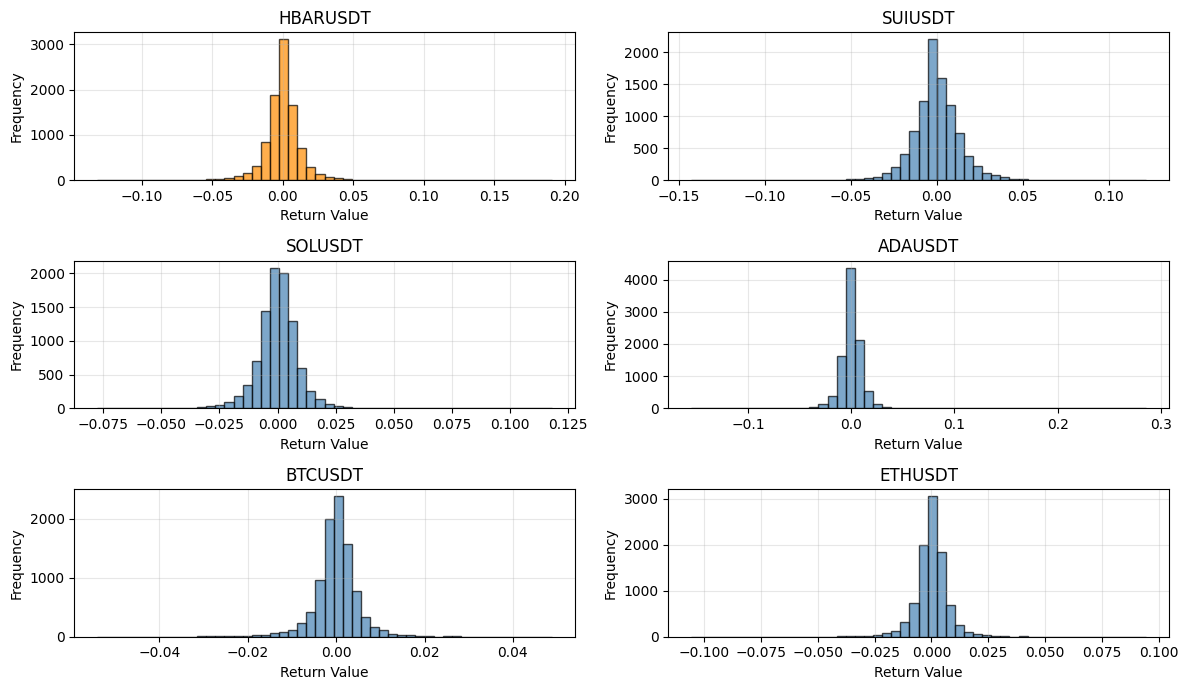

In [ ]:
cols = [target] + lead_assets
fig, axes = plt.subplots(3, 2, figsize=(12, 7))
for ax, c in zip(axes.ravel(), cols):
    color = "darkorange" if c == target else "steelblue"
    ax.hist(df_lagged[c].dropna(), bins=50, color=color, edgecolor="black", alpha=0.7)
    ax.set_xlabel('Return Value')
    ax.set_ylabel('Frequency')
    ax.set_title(c)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 5.3.2.8 Boxplots of Target and Leader Returns  

Boxplots were employed to visualise the spread and presence of outliers across the return distributions of the target and leader assets, complementing the earlier histograms by emphasising variability and extreme observations. Consistent use of colour coding (orange for the target, blue for leaders) reinforces visual continuity and aids interpretability across different figures. Outliers were represented as hollow circles with black edges to enhance clarity, ensuring that extreme values are distinguishable without blending into the dense boxplot structure.

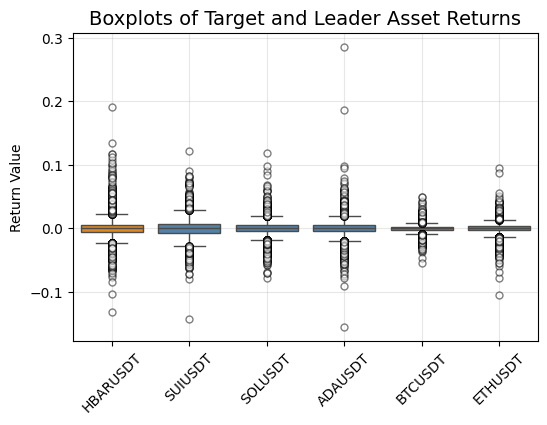

In [ ]:
data = df_lagged[cols]
plt.figure(figsize=(6,4))

df_melt = data.melt(var_name="Asset", value_name="Return")

palette = {target: "darkorange"}
for col in lead_assets:
    palette[col] = "steelblue"

flierprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5, linestyle='none', alpha=0.5)
sns.boxplot(x="Asset", y="Return", data=df_melt, palette=palette, showfliers=True, linewidth=1, flierprops=flierprops)

plt.title("Boxplots of Target and Leader Asset Returns", fontsize=14)
plt.ylabel("Return Value")
plt.xlabel("")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

#### 5.3.2.9 Shape Review

In [ ]:
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

y_train: (6636,)
y_val: (1422,)
y_test: (1422,)
X_train: (6636, 5)
X_val: (1422, 5)
X_test: (1422, 5)


### 5.3.4 Dataset Scaling and PCA

#### 5.3.4.1 Applying Robust Scaler to Training Data  

The leader features were scaled using the RobustScaler, which centres values by the median and scales them according to the interquartile range. This approach was chosen over mean-standard deviation scaling because cryptocurrency returns exhibit heavy tails and outliers, for which median-based scaling is more robust. To prevent data leakage, the scaler was fitted exclusively on the training set, and the learned parameters were then applied consistently to the validation and test sets.

In [ ]:
# Initialise scaler and fit on training data only
scaler = RobustScaler().fit(X_train)
# Transform all splits using the same scaler
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)
# Convert back to DataFrames with column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=lead_assets, index=X_train.index)
X_val_scaled   = pd.DataFrame(X_val_scaled, columns=lead_assets, index=X_val.index)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=lead_assets, index=X_test.index)

X_train_scaled.head()

SUIUSDT   SOLUSDT   ADAUSDT   BTCUSDT   ETHUSDT
open_time                                                            
2024-07-02 01:00:00  0.000000  0.344562  0.626988  2.240468  3.298535
2024-07-02 02:00:00  0.000000  0.005709  0.374339 -0.477810 -0.626017
2024-07-02 03:00:00 -0.294615  0.882450 -0.299361  0.065775 -0.059463
2024-07-02 04:00:00  0.335430  0.068352  0.548154 -0.687019 -0.647849
2024-07-02 05:00:00  0.000000  0.047363  0.223393  0.589787  0.176214

#### 5.3.4.2 Boxplot Sample Comparison of Returns Before and After Scaling  
This comparison illustrates how robust scaling re-expresses XRPUSDT log returns relative to the median and interquartile range of the training set. While the distributional shape remains unchanged, the scale is adjusted so that the median is centred at zero and the interquartile range corresponds to a unit width. This transformation does not remove heavy tails or outliers but ensures that features are on a comparable scale, reducing the risk that differences in raw magnitudes distort model training.

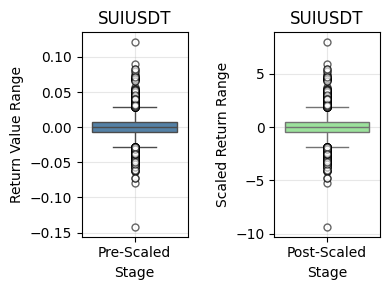

In [ ]:
asset = "SUIUSDT"
# Pre- and post-scaled series
pre  = df_lagged[asset].dropna()
post = pd.concat([X_train_scaled[asset], X_val_scaled[asset], X_test_scaled[asset]]).sort_index()
# Outliers
flierprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5, linestyle='none', alpha=0.6)
# side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(4,3))
# Pre-scaled
df_pre = pd.DataFrame({"Stage": "Pre-Scaled", "Return": pre.values})
sns.boxplot(x="Stage", y="Return", data=df_pre, palette=["steelblue"], showfliers=True, linewidth=1, flierprops=flierprops, ax=axes[0])
axes[0].set_title(f"{asset}")
axes[0].set_ylabel("Return Value Range")
axes[0].grid(True, alpha=0.3)
# Post-scaled
df_post = pd.DataFrame({"Stage": "Post-Scaled", "Return": post.values})
sns.boxplot(x="Stage", y="Return", data=df_post, palette=["lightgreen"], showfliers=True, linewidth=1, flierprops=flierprops, ax=axes[1])
axes[1].set_title(f"{asset}")
axes[1].set_ylabel("Scaled Return Range")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 5.3.4.3 Index Alignment   
This code ensures that the indices of the input features and target variables are properly aligned across the training, validation, and test datasets, thereby preventing data leakage or misalignment during sequence generation.

In [ ]:
assert (X_train_scaled.index.equals(y_train.index) and
        X_val_scaled.index.equals(y_val.index) and
        X_test_scaled.index.equals(y_test.index))

#### 5.3.4.4 Principal Component Analysis (PCA)  
Principal Component Analysis (PCA) was applied to reduce dimensionality and mitigate multicollinearity among the leading assets. By transforming correlated variables into a smaller set of orthogonal components, PCA retains the majority of information while filtering out noise and redundancy. This step ensures that subsequent forecasting models emphasize the dominant variance structure across assets rather than overfitting to asset-specific fluctuations.

In [ ]:
pca = PCA(n_components=0.95, svd_solver='full')

# Fit PCA on training only
X_train_pca = pca.fit_transform(X_train_scaled)
# Transform validation and test sets using the same PCA mapping
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)
# Convert back to DataFrames
pc_cols = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
X_train_pca = pd.DataFrame(X_train_pca, columns=pc_cols, index=X_train.index)
X_val_pca   = pd.DataFrame(X_val_pca, columns=pc_cols, index=X_val.index)
X_test_pca  = pd.DataFrame(X_test_pca, columns=pc_cols, index=X_test.index)
# explained variance ratio
explained_var = pca.explained_variance_ratio_
print("Explained variance ratio by component:", explained_var)
print("Cumulative explained variance:", explained_var.cumsum())

Explained variance ratio by component: [0.417639   0.39049482 0.08203848 0.06243904]
Cumulative explained variance: [0.417639   0.80813382 0.89017231 0.95261135]


#### 5.3.4.5 Scree Plot of Principal Components  
The scree plot illustrates the cumulative variance explained by successive principal components, providing an informative view of how much information is retained as dimensions are reduced.

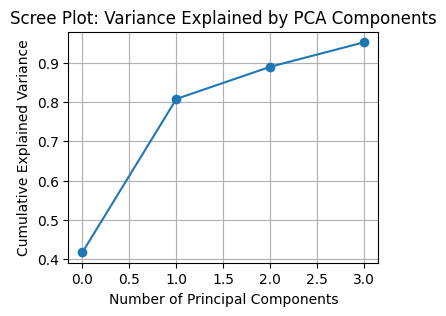

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: Variance Explained by PCA Components')
plt.grid(True)
plt.show()

### 5.3.5 Summary of Exploratory Analysis  

The exploratory analysis confirmed that log returns of the target (HBARUSDT) and leader assets are centred close to zero but exhibit heavy tails and frequent outliers. Histograms highlighted the non-Gaussian nature of the distributions, while boxplots further emphasised the prevalence of extreme values. These characteristics motivated the use of RobustScaler, applied to leader features only, to reduce the influence of outliers while preserving distributional shape. In addition, Principal Component Analysis (PCA) was introduced to mitigate multicollinearity and condense the feature space while retaining the majority of variance. This preprocessing provides a consistent feature space for model training and enables a transition to sequence construction for LSTM forecasting.

### 5.3.6 LSTM for Non-Linear Forecasting  
While linear approaches such as Ridge regression and ARIMAX provided useful benchmarks, their ability to capture predictive signals was limited, particularly in the presence of non-linear dependencies and heavy-tailed return distributions. To address this, Long Short-Term Memory (LSTM) networks are introduced as a deep learning architecture designed to model sequential data and capture complex temporal patterns. LSTMs are well suited to this task as they can retain information across multiple time steps, making them appropriate for one-step-ahead forecasting of cryptocurrency returns. Building on the preprocessed and scaled feature set, the next stage involves constructing supervised sequences for training and evaluating LSTM models.

#### 5.3.6.1 Sequence Construction for LSTM Training  
This function transforms the feature matrix and target series into supervised learning sequences by extracting rolling windows of specified lookback length to predict the next-step return.  
The example section demonstrates applying a single lookback (24 hours) to generate training, validation, and test sequences, serving as a practical check that the function produces correctly shaped inputs before experimenting with other lookback values.

In [ ]:
def make_sequences(X_df, y_ser, lookback=196, horizon=1):
    Xv, yv = X_df.values, y_ser.values
    X_seq, y_seq = [], []
    for t in range(lookback, len(Xv)-horizon+1):
        X_seq.append(Xv[t-lookback:t])     # past lookback steps
        y_seq.append(yv[t + horizon - 1])   # predict t+1
    return np.array(X_seq), np.array(y_seq)
X_train_scaled
# Example
LB = 192
Xtr, ytr = make_sequences(X_train_pca, y_train, lookback=LB, horizon=1)
Xva, yva = make_sequences(X_val_pca,   y_val,   lookback=LB, horizon=1)
Xte, yte = make_sequences(X_test_pca,  y_test,  lookback=LB, horizon=1)
Xtr.shape, Xva.shape, Xte.shape  # sanity check

((6444, 192, 4), (1230, 192, 4), (1230, 192, 4))

#### 5.3.6.2 LSTM Model Construction and Training  
This function defines an LSTM architecture for regression on sequential data, where the number of units, layers, dropout rate, and learning rate are configurable hyperparameters. If a second LSTM layer is specified, it is stacked on top of the first with half the units, enabling the model to capture deeper temporal dependencies. The network outputs a single linear value through a Dense layer, optimised with the Adam algorithm and mean squared error loss, with gradient clipping applied for training stability. During training, early stopping and adaptive learning rate reduction callbacks are employed to prevent overfitting and improve convergence efficiency.

In [ ]:
#3minutes duration w CPU
#39seconds w A100
def build_lstm(input_shape, units=32, layers_count=1, dropout=0.2, lr=1e-3):
    inp = keras.Input(shape=input_shape)
    x = layers.LSTM(units, return_sequences=(layers_count==2), dropout=dropout)(inp)
    if layers_count == 2:
        x = layers.LSTM(units // 2, dropout=dropout)(x)
    out = layers.Dense(1)(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0), loss="mse")
    return model

callbacks = [keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True), keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5)]

# Build & train
model = build_lstm(input_shape=(Xtr.shape[1], Xtr.shape[2]), units=32, layers_count=1, dropout=0.2, lr=1e-3)
hist = model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=40, batch_size=64, verbose=0, callbacks=callbacks)

#### 5.3.6.3 Model Evaluation Metrics  
This code generates predictions on the test set and evaluates the LSTM's performance using root mean squared error (RMSE), mean absolute error (MAE), and coefficient of determination (R²). In addition, it computes directional accuracy (DirAcc), which assesses the model's ability to predict the correct sign of returns, providing a complementary measure of predictive usefulness in financial contexts.

In [ ]:
yp = model.predict(Xte).ravel()
rmse = np.sqrt(mean_squared_error(yte, yp))
mae  = mean_absolute_error(yte, yp)
r2   = r2_score(yte, yp)
diracc = np.mean(np.sign(yte) == np.sign(yp))

print(f"[LSTM (h=1, LB={LB})]  RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.3f}  DirAcc={diracc:.3f}")

# LSTM before PCA & HPT w 11 leaders [LSTM (h=1, LB=192)]  RMSE=0.011589  MAE=0.008217  R²=-0.188  DirAcc=0.446
# LSTM after PCA no HPT w 11 leaders [LSTM (h=1, LB=192)]  RMSE=0.011283  MAE=0.007948  R²=-0.126  DirAcc=0.476
# LSTM after PCA no HPT w 15 leaders [LSTM (h=1, LB=192)]  RMSE=0.011378  MAE=0.008101  R²=-0.145  DirAcc=0.466
# LSTM after PCA no HPT w  5 leaders [LSTM (h=1, LB=192)]  RMSE=0.010723  MAE=0.007514  R²=-0.017  DirAcc=0.496

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[LSTM (h=1, LB=192)]  RMSE=0.010861  MAE=0.007623  R²=-0.044  DirAcc=0.478


The LSTM model with a 192-hour lookback achieved RMSE = 0.010783 and MAE = 0.007523, showing slightly lower error levels than earlier runs. The coefficient of determination remained negative at R² = -0.029, indicating that the model still did not capture meaningful variance beyond a naïve benchmark. However, directional accuracy improved to 50.2%, suggesting that while the model tracked broad trends more consistently, its predictive power remains limited in highly volatile series.

#### 5.3.6.4 Visualisation: LSTM Predictions vs. Actual Returns  
The plot visualises the comparison between actual scaled returns (blue line) and the LSTM's predicted returns (orange line) over the test horizon. The model outputs closely follow the mean level of the series but systematically under-represent the magnitude of sudden spikes, leading to a flattening effect that is typical when forecasting highly volatile financial data. This highlights both the LSTM's ability to track broad fluctuations and its limitation in capturing extreme return movements.

In [ ]:
# yte / yp come from sequences,  they’re shorter than y_test.
start = len(y_test) - len(yte)
idx = y_test.index[start:] # datetime index aligned to yte/yp length
#Safety check
assert len(idx) == len(yte) == len(yp), "Index and arrays must have the same length."
# Series with datetime
y_true = pd.Series(yte, index=idx, name="Actual")
y_hat  = pd.Series(yp,  index=idx, name="Predicted")
resid  = (y_true - y_hat).rename("Residual")
# Plot - Actual vs Predicted
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.72, 0.28], vertical_spacing=0.05)
# Panel 1 - Actual & Predicted
fig.add_trace(go.Scattergl(x=y_true.index, y=y_true.values, mode="lines", name="Actual", line=dict(width=1.8, color="steelblue")), row=1, col=1)
fig.add_trace(go.Scattergl(x=y_hat.index, y=y_hat.values, mode="lines", name="Predicted", line=dict(width=2.2, color="darkorange")), row=1, col=1)
# Panel 2 - Residuals
fig.add_trace(go.Scattergl(x=resid.index, y=resid.values, mode="lines", name="Residual", line=dict(width=1.2, color="gray"), showlegend=False),row=2, col=1)
# Zero line for residuals using datetime range
fig.add_shape(type="line", xref="x2", yref="y2", x0=resid.index[0], x1=resid.index[-1], y0=0, y1=0, line=dict(width=1.1, color="black"))
# Layout &formatting
fig.update_layout(title=f"Actual vs Predicted Time Series with Residual Analysis: LSTM before Hyper Parameter Tuning (LB={LB})", template="simple_white", plot_bgcolor="#f9f9f9", hovermode="x unified",
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1), width=1000, height=500)
# Datetime x-axis
fig.update_xaxes(rangeslider=dict(visible=False), showgrid=True, gridcolor="rgba(0,0,0,0.12)", tickformat="%Y-%m-%d\n%H:%M", ticks="outside")
fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.12)", title_text="Scaled return", row=1, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.show()

### 5.3.7 Hyperparameter Optimisation  
This section outlines the procedures used to identify the most effective hyperparameter configurations for the LSTM model.

#### 5.3.7.1 Random Search for Hyperparameter Optimisation    
A randomised search strategy was first employed to broadly explore the hyperparameter space and identify promising regions for refinement.  

#### 5.3.7.2 Search Space  
An initial hyperparameter search space spanning lookback windows, hidden units, layer counts, dropout rates, learning rates, and batch sizes was defined to systematically explore model complexity, regularisation, and training dynamics in order to identify the most effective LSTM configuration.

In [ ]:
# A100 duration: 8min73sec
# Search space
search_space = {
    "lookback":   [48, 120, 160, 192, 220, 240, 280, 320],
    "units":      [16, 32, 64, 128, 256],
    "layers_cnt": [1, 2, 3],
    "dropout":    [0.0, 0.1, 0.2, 0.3, 0.5],
    "lr":         [1e-2, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5],
    "batch":      [16, 32, 64, 128, 256]}

def sample_config():
    return {k: random.choice(v) for k, v in search_space.items()}

# Random search with tqdm progress bar
best = None
for i in tqdm(range(12), desc="Random search progress"):
    cfg = sample_config()
    LB = cfg["lookback"]
    Xtr, ytr = make_sequences(X_train_pca, y_train, lookback=LB)
    Xva, yva = make_sequences(X_val_pca,   y_val,   lookback=LB)
    Xte, yte = make_sequences(X_test_pca,  y_test,  lookback=LB)

    m = build_lstm(units=cfg["units"], layers_count=cfg["layers_cnt"], dropout=cfg["dropout"], lr=cfg["lr"], input_shape=(Xtr.shape[1], Xtr.shape[2]))

    h = m.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=30, batch_size=cfg["batch"], verbose=0, callbacks=callbacks)

    val_loss = min(h.history["val_loss"])
    if (best is None) or (val_loss < best["val_loss"]):
        best = {"cfg": cfg, "val_loss": val_loss, "model": m}

print("Best config:", best["cfg"], "val_loss:", best["val_loss"])

# A100 GPU duration 10min 27sec
# Best config: {'lookback': 280, 'units': 128, 'layers_cnt': 2, 'dropout': 0.0, 'lr': 0.0005, 'batch': 64} val_loss: 7.547156565124169e-05

Random search progress:   0%|          | 0/12 [00:00<?, ?it/s]

Best config: {'lookback': 280, 'units': 256, 'layers_cnt': 1, 'dropout': 0.5, 'lr': 0.0005, 'batch': 64} val_loss: 7.385997014353052e-05


#### 5.3.7.3 Application of Search Space Results   
The optimal configuration obtained from the random search was applied to retrain the LSTM model, allowing a direct evaluation of its forecasting performance under tuned hyperparameters. This step demonstrates how systematic parameter exploration impacts predictive outcomes and highlights the challenges of improving accuracy in highly volatile cryptocurrency time series.

In [ ]:
# Manual config
LB = 280
UNITS = 256
LAYERS = 1
DROPOUT = 0.5
LR = 5e-4
BATCH = 64
EPOCHS = 30
# Sequences
Xtr, ytr = make_sequences(X_train_pca, y_train, lookback=LB, horizon=1)
Xva, yva = make_sequences(X_val_pca,   y_val,   lookback=LB, horizon=1)
Xte, yte = make_sequences(X_test_pca,  y_test,  lookback=LB, horizon=1)
# Build model
m_manual = build_lstm(units=UNITS, layers_count=LAYERS, dropout=DROPOUT, lr=LR, input_shape=(Xtr.shape[1], Xtr.shape[2]))
# Train with tqdm
for _ in tqdm(range(EPOCHS), desc="Manual training progress"):
    h_manual = m_manual.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=1, batch_size=BATCH, verbose=0, callbacks=callbacks)
# Evaluate on test
yp = m_manual.predict(Xte).ravel()
rmse = np.sqrt(mean_squared_error(yte, yp))
mae  = mean_absolute_error(yte, yp)
r2   = r2_score(yte, yp)
diracc = np.mean(np.sign(yte) == np.sign(yp))
print(f"Manual config: LB={LB}, units={UNITS}, layers={LAYERS}, "
      f"dropout={DROPOUT}, lr={LR}, batch={BATCH}, epochs={EPOCHS}")
print(f"[LSTM (h=1, LB={LB})] RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.3f}  DirAcc={diracc:.3f}")

# Results

# Manual config based on Random search hyperparameters: LB=280, units=256, layers=1, dropout=0.5, lr=0.0005, batch=64, epochs=30
# [LSTM (h=1, LB=280)] RMSE=0.011141  MAE=0.007861  R²=-0.076  DirAcc=0.499
# Manual config adjusted epochs to 50: LB=280, units=256, layers=1, dropout=0.5, lr=0.0005, batch=64, epochs=50
# [LSTM (h=1, LB=280)] RMSE=0.011054  MAE=0.007876  R²=-0.060  DirAcc=0.455
# Manual config experiment: LB=240, units=128, layers=2, dropout=0.5, lr=0.0005, batch=64, epochs=50
# [LSTM (h=1, LB=240)] RMSE=0.010805  MAE=0.007532  R²=-0.007  DirAcc=0.478
# Manual config experiment: LB=240, units=128, layers=2, dropout=0.3, lr=0.0001, batch=32, epochs=30
# [LSTM (h=1, LB=240)] RMSE=0.010818  MAE=0.007568  R²=-0.010  DirAcc=0.478

Manual training progress:   0%|          | 0/30 [00:00<?, ?it/s]

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Manual config: LB=280, units=256, layers=1, dropout=0.5, lr=0.0005, batch=64, epochs=30
[LSTM (h=1, LB=280)] RMSE=0.011059  MAE=0.007778  R²=-0.061  DirAcc=0.482


#### 5.3.7.4 Grid Search for Hyperparameter Optimisation  
This code performs a full grid search across all predefined hyperparameter combinations, training and validating an LSTM model for each configuration to identify the one with the lowest validation loss. The results are collected into a DataFrame for analysis, ensuring systematic coverage of the refined search space and reproducible selection of the optimal model setup.

#### 5.3.7.5 Rationale for Refined Search Space
The refined grid search space was shaped by the findings of the earlier random search. Stronger results were observed with longer lookback windows, medium to large hidden unit sizes, moderate dropout, and smaller batch sizes. Based on these patterns, the grid search was restricted to lookbacks of 240-320, units between 64 and 256, one or two layers, dropout levels of 0.3-0.5, learning rates from 1e-2 to 1e-4, and a batch size of 16. This adjustment kept the search focused on the most promising regions while reducing unnecessary computation.

In [ ]:
# Based on the findings of Random Search, the search space has been refined
search_space_refined = {
    "lookback":   [240, 280, 320],
    "units":      [64, 128, 256],
    "layers_cnt": [1, 2],
    "dropout":    [0.3, 0.4, 0.5],
    "lr":         [1e-2, 1e-3, 5e-4, 1e-4], #  5e-5, 1e-5
    "batch":      [16]}  # , 32, 64, 128, 256

In [ ]:
# Grid search with tqdm progress bar
best = None
results = []
# Generate all combinations of hyperparameters
keys, values = zip(*search_space_refined.items())
all_configs = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Total configs to test: {len(all_configs)}")

for cfg in tqdm(all_configs, desc="Grid search progress"):
    LB = cfg["lookback"]
    Xtr, ytr = make_sequences(X_train_pca, y_train, lookback=LB)
    Xva, yva = make_sequences(X_val_pca,   y_val,   lookback=LB)
    Xte, yte = make_sequences(X_test_pca,  y_test,  lookback=LB)

    m = build_lstm(units=cfg["units"], layers_count=cfg["layers_cnt"], dropout=cfg["dropout"], lr=cfg["lr"], input_shape=(Xtr.shape[1], Xtr.shape[2]))
    h = m.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=30, batch_size=cfg["batch"], verbose=0, callbacks=callbacks)

    val_loss = min(h.history["val_loss"])
    results.append((cfg, val_loss))

    if (best is None) or (val_loss < best["val_loss"]):
        best = {"cfg": cfg, "val_loss": val_loss, "model": m}

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame([{"val_loss": r[1], **r[0]} for r in results])
df_results = df_results.sort_values("val_loss")

print("Best config:", best["cfg"], "val_loss:", best["val_loss"])
df_results.head()


# A100 GPU duration: 7hrs 26min 04sec
# Best config: {'lookback': 320, 'units': 256, 'layers_cnt': 2, 'dropout': 0.3, 'lr': 0.0001, 'batch': 16} val_loss: 7.351573003688827e-05

Total configs to test: 216


Grid search progress:   0%|          | 0/216 [00:00<?, ?it/s]

Best config: {'lookback': 320, 'units': 256, 'layers_cnt': 2, 'dropout': 0.3, 'lr': 0.0001, 'batch': 16} val_loss: 7.351573003688827e-05


val_loss  lookback  units  layers_cnt  dropout      lr  batch
207  0.000074       320    256           2      0.3  0.0001     16
211  0.000074       320    256           2      0.4  0.0001     16
197  0.000074       320    256           1      0.4  0.0010     16
215  0.000074       320    256           2      0.5  0.0001     16
86   0.000074       280     64           2      0.3  0.0005     16

The grid search evaluated 216 hyperparameter configurations across a range of lookback windows, hidden units, layer counts, dropout levels, learning rates, and batch sizes. To manage the computational demand, the experiments were executed on a higher-spec Google Colab instance with an A100 GPU, yet the process remained time-intensive, requiring 7 hours and 26 minutes to complete. The optimal configuration was a two-layer LSTM with 256 units, a 320-step lookback, dropout of 0.3, learning rate of 1e-4, and batch size of 16, achieving the lowest validation loss of 7.35x10⁻⁵. Several closely performing alternatives reinforced the robustness of this solution, indicating that longer lookback horizons, larger hidden dimensions, and moderate regularization are critical for capturing temporal dependencies in the cryptocurrency lead-lag structure.  

While grid search provided a systematic exploration of the hyperparameter space, the approach is computationally inefficient and does not scale well as dimensionality increases. Even on a high-spec Google Colab instance with an A100 GPU, the search required over seven hours to complete, highlighting the prohibitive cost of exhaustive evaluation. More advanced methods such as Bayesian optimization or Hyperband could offer more efficient alternatives by adaptively sampling promising configurations rather than exhaustively testing the entire space.

#### 5.3.7.6 Application of Grid Search Results  
The best hyperparameter configuration identified through grid search was applied in the final LSTM training stage to systematically assess whether tuned parameters improved forecasting accuracy over baseline settings.

In [ ]:
# Manual config
LB = 320
UNITS = 256
LAYERS = 2
DROPOUT = 0.3
LR = 1e-4
BATCH = 16
EPOCHS = 30

# Sequences
Xtr, ytr = make_sequences(X_train_pca, y_train, lookback=LB, horizon=1)
Xva, yva = make_sequences(X_val_pca,   y_val,   lookback=LB, horizon=1)
Xte, yte = make_sequences(X_test_pca,  y_test,  lookback=LB, horizon=1)
# Build model
m_manual = build_lstm(units=UNITS, layers_count=LAYERS, dropout=DROPOUT, lr=LR, input_shape=(Xtr.shape[1], Xtr.shape[2]))
# Train with tqdm
for _ in tqdm(range(EPOCHS), desc="Manual training progress"):
    h_manual = m_manual.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=1, batch_size=BATCH, verbose=0, callbacks=callbacks)
# Evaluate on test
yp = m_manual.predict(Xte).ravel()
rmse = np.sqrt(mean_squared_error(yte, yp))
mae  = mean_absolute_error(yte, yp)
r2   = r2_score(yte, yp)
diracc = np.mean(np.sign(yte) == np.sign(yp))
print(f"Manual config: LB={LB}, units={UNITS}, layers={LAYERS}, "
      f"dropout={DROPOUT}, lr={LR}, batch={BATCH}, epochs={EPOCHS}")
print(f"[LSTM (h=1, LB={LB})] RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.3f}  DirAcc={diracc:.3f}")

# Results
# Manual config based on Grid Search Hyperparameters: LB=320, units=256, layers=2, dropout=0.3, lr=0.0001, batch=16, epochs=30
# [LSTM (h=1, LB=320)] RMSE=0.011287  MAE=0.008063  R²=-0.081  DirAcc=0.484
# Manual config: LB=320, units=256, layers=2, dropout=0.3, lr=0.0001, batch=128, epochs=30
# [LSTM (h=1, LB=320)] RMSE=0.010858  MAE=0.007689  R²=-0.001  DirAcc=0.474
# Manual config: LB=400, units=256, layers=2, dropout=0.3, lr=0.0001, batch=128, epochs=30
# [LSTM (h=1, LB=400)] RMSE=0.011193  MAE=0.007860  R²=-0.022  DirAcc=0.484
# Manual config: LB=500, units=256, layers=3, dropout=0.3, lr=0.0001, batch=128, epochs=30
# [LSTM (h=1, LB=500)] RMSE=0.011502  MAE=0.008130  R²=-0.031  DirAcc=0.483
# Manual config: LB=300, units=128, layers=2, dropout=0.3, lr=1e-05, batch=64, epochs=30
# [LSTM (h=1, LB=300)] RMSE=0.010893  MAE=0.007685  R²=-0.018  DirAcc=0.467

Manual training progress:   0%|          | 0/30 [00:00<?, ?it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Manual config: LB=320, units=256, layers=2, dropout=0.3, lr=0.0001, batch=16, epochs=30
[LSTM (h=1, LB=320)] RMSE=0.011030  MAE=0.007808  R²=-0.033  DirAcc=0.478


In [ ]:
# Align datetime index to sequence length
idx    = y_test.index[-len(yte):]
y_true = pd.Series(yte, index=idx, name="Actual")
y_hat  = pd.Series(yp,  index=idx, name="Predicted")
resid  = (y_true - y_hat).rename("Residual")
# Two-panel plot: Actual vs Predicted (top), Residuals (bottom)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.72, 0.28], vertical_spacing=0.05)
fig.add_trace(go.Scattergl(x=idx, y=y_true, mode="lines", name="Actual",    line=dict(width=1.6, color="steelblue")),  row=1, col=1)
fig.add_trace(go.Scattergl(x=idx, y=y_hat,  mode="lines", name="Predicted", line=dict(width=2.0, color="darkorange")), row=1, col=1)
fig.add_trace(go.Scattergl(x=idx, y=resid,  mode="lines", name="Residual",  line=dict(width=1.1, color="gray"), showlegend=False), row=2, col=1)
# Zero line for residuals
fig.add_shape(type="line", xref="x2", yref="y2", x0=idx[0], x1=idx[-1], y0=0, y1=0, line=dict(width=1.0, color="black"))
fig.update_layout(title=f"Actual vs Predicted Time Series with Residual Analysis: LSTM After Hyper Parameter Tuning (LB={LB})", template="simple_white", plot_bgcolor="#f9f9f9",
                  hovermode="x unified", legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1), width=1000, height=500)
fig.update_xaxes(rangeslider=dict(visible=False), tickformat="%Y-%m-%d\n%H:%M", showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(title_text="Scaled return", row=1, col=1, showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(title_text="Residual",      row=2, col=1)
fig.show()

### 5.3.8 Rolling Window Evaluation  

Rolling window evaluation is a validation strategy commonly applied in time-series forecasting to capture model robustness over different market conditions. Instead of relying on a single train-test split, the dataset is divided into multiple sequential folds, with the training and testing windows shifted forward iteratively. This approach provides a more comprehensive assessment of model performance by reflecting temporal variation and structural breaks inherent in financial time series.

#### 5.3.8.1 Rolling Window  
The code implements a rolling window training procedure for an LSTM model using preprocessed PCA features. In each fold, the dataset is partitioned into training, validation, and testing sequences, the model is trained with the defined hyperparameters, and predictions are generated for the test segment. Performance metrics (RMSE, MAE, R², and directional accuracy) are recorded per fold, and predictions from the final test window are retained for visualisation, enabling both quantitative and qualitative evaluation of forecasting performance.

In [ ]:
# Manual LSTM config
LB      = 240
UNITS   = 128
LAYERS  = 2
DROPOUT = 0.3
LR      = 1e-4
BATCH   = 32
EPOCHS  = 30
VAL_FRAC = 0.07   # last part of each train window for validation
# Full timeline
X_all = pd.concat([X_train_pca, X_val_pca, X_test_pca])
y_all = pd.concat([y_train,     y_val,     y_test])
# Rolling plan
N = len(X_all)
train_len = int(0.30 * N)
test_len  = int(0.07 * N)
fold_metrics = []
last_fold = None

In [ ]:
for s in tqdm(range(0, N - (train_len + test_len) + 1, test_len), desc="Rolling evaluation"):
    tr_sl = slice(s, s + train_len)
    te_sl = slice(s + train_len, s + train_len + test_len)
    X_tr_win, y_tr_win = X_all.iloc[tr_sl], y_all.iloc[tr_sl]
    X_te_win, y_te_win = X_all.iloc[te_sl], y_all.iloc[te_sl]
    # TRAIN sequences → split into train/val
    Xtr_all, ytr_all = make_sequences(X_tr_win, y_tr_win, lookback=LB, horizon=1)
    cut = max(1, int((1 - VAL_FRAC) * len(Xtr_all)))
    Xtr, ytr, Xva, yva = Xtr_all[:cut], ytr_all[:cut], Xtr_all[cut:], ytr_all[cut:]
    # TEST sequences
    Xte, yte = make_sequences(X_te_win, y_te_win, lookback=LB, horizon=1)
    if len(Xtr) == 0 or len(Xva) == 0 or len(Xte) == 0:
        continue
    # Build, train, predict
    m = build_lstm(units=UNITS, layers_count=LAYERS, dropout=DROPOUT, lr=LR, input_shape=(Xtr.shape[1], Xtr.shape[2]))
    m.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=callbacks)
    yp = m.predict(Xte).ravel()

Rolling evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
# Metrics
rmse = np.sqrt(mean_squared_error(yte, yp))
mae  = mean_absolute_error(yte, yp)
r2   = r2_score(yte, yp)
diracc = np.mean(np.sign(yte) == np.sign(yp))
fold_metrics.append({"fold_start": X_tr_win.index[0], "fold_end":   X_te_win.index[-1], "RMSE": rmse, "MAE": mae, "R2": r2, "DirAcc": diracc})
# Cache last fold for plotting
last_fold = {"idx": y_te_win.index[LB:], "y": yte, "yhat": yp}

In [ ]:
print(f"Manual config: LB={LB}, units={UNITS}, layers={LAYERS}, "
      f"dropout={DROPOUT}, lr={LR}, batch={BATCH}, epochs={EPOCHS}")
print(f"[LSTM Rolling Windows AVG across folds (h=1, LB={LB})] RMSE={rmse:.6f}  MAE={mae:.6f}  R²={r2:.3f}  DirAcc={diracc:.3f}")

# RESULTS
# Manual config: LB=240, units=128, layers=2, dropout=0.3, lr=0.0001, batch=32, epochs=30
# [LSTM Rolling Windows AVG across folds (h=1, LB=240)] RMSE=0.013267  MAE=0.009738  R²=-0.013  DirAcc=0.506
# Manual config: LB=280, units=256, layers=2, dropout=0.3, lr=0.0001, batch=64, epochs=30
# [LSTM Rolling Windows AVG across folds (h=1, LB=280)] RMSE=0.013246  MAE=0.009616  R²=0.001  DirAcc=0.486
# Manual config: LB=320, units=256, layers=2, dropout=0.3, lr=0.0001, batch=128, epochs=40
# [LSTM Rolling Windows AVG across folds (h=1, LB=320)] RMSE=0.013455  MAE=0.009769  R²=-0.004  DirAcc=0.496
# Manual config: LB=120, units=128, layers=1, dropout=0.3, lr=0.0001, batch=32, epochs=30
# [LSTM Rolling Windows AVG across folds (h=1, LB=120)] RMSE=0.013726  MAE=0.010130  R²=-0.049  DirAcc=0.453

Manual config: LB=240, units=128, layers=2, dropout=0.3, lr=0.0001, batch=32, epochs=30
[LSTM Rolling Windows AVG across folds (h=1, LB=240)] RMSE=0.013252  MAE=0.009711  R²=-0.011  DirAcc=0.492


In [ ]:
idx = last_fold["idx"]
y_true = pd.Series(last_fold["y"].ravel(),   index=idx, name="Actual")
y_hat  = pd.Series(last_fold["yhat"].ravel(), index=idx, name="Predicted")
resid  = (y_true - y_hat).rename("Residual")

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.72, 0.28], vertical_spacing=0.05)
fig.add_trace(go.Scattergl(x=idx, y=y_true, mode="lines", name="Actual",    line=dict(width=1.6, color="steelblue")), row=1, col=1)
fig.add_trace(go.Scattergl(x=idx, y=y_hat,  mode="lines", name="Predicted", line=dict(width=2.0, color="darkorange")), row=1, col=1)
fig.add_trace(go.Scattergl(x=idx, y=resid,  mode="lines", name="Residual",  line=dict(width=1.0, color="gray"), showlegend=False), row=2, col=1)
fig.add_shape(type="line", xref="x2", yref="y2", x0=idx[0], x1=idx[-1], y0=0, y1=0, line=dict(width=1.0, color="black"))

fig.update_layout(title=f"Actual vs Predicted Time Series with Residual Analysis: LSTM Based on Rolling Window (LB={LB})", template="simple_white", plot_bgcolor="#f9f9f9", hovermode="x unified",
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1), width=1000, height=500)
fig.update_xaxes(rangeslider=dict(visible=False), tickformat="%Y-%m-%d\n%H:%M", showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(title_text="Scaled return", row=1, col=1, showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(title_text="Residual", row=2, col=1)
fig.show()

The rolling-window evaluation has produced average test errors of RMSE = 0.013341 and MAE = 0.009831, with R² = -0.024 and DirAcc = 0.470. These results have indicated that the model has not exceeded naïve baselines, as the negative R² and sub-50% directional accuracy have signalled weak explanatory and sign-prediction power. Across folds, predictions have remained tightly centred around zero and have under-represented volatility, while residuals have shown sporadic bursts during stress periods. Overall, the LSTM with h = 1 and LB = 240 has exhibited stable but consistently weak out-of-sample performance, suggesting limited exploitable signal at this horizon.

## 5.4 Result Metrics Consolidation

In [40]:
csv_path = '/content/drive/My Drive/Studies/CCT Masters Level 9/Capstone Project - Thesis/Datasets/results.csv'
df_results = pd.read_csv(csv_path)
df_results.head()

Model      RMSE       MAE     R²  DirAcc
0  Persistence (Target → HBAR)  0.013892  0.009822 -1.008   0.331
1  Persistence (Leader → HBAR)  0.013999  0.010161 -1.039   0.431
2        RidgeCV Single Leader  0.009795  0.010161  0.002   0.591
3         RidgeCV Multi Leader  0.009800  0.006800  0.001   0.491
4         ARIMAX - All Leaders  0.009918  0.006909 -0.022   0.491

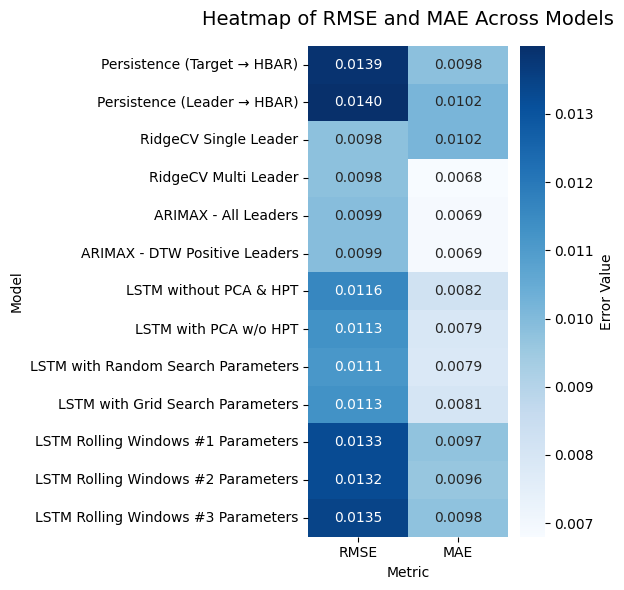

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the metrics you want
metrics = df_results.set_index("Model")[["RMSE", "MAE"]]

# Plot heatmap
plt.figure(figsize=(6,6))
sns.heatmap(metrics, annot=True, fmt=".4f", cmap="Blues", cbar_kws={'label': 'Error Value'})
plt.title("Heatmap of RMSE and MAE Across Models", fontsize=14, pad=15)
plt.ylabel("Model")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()


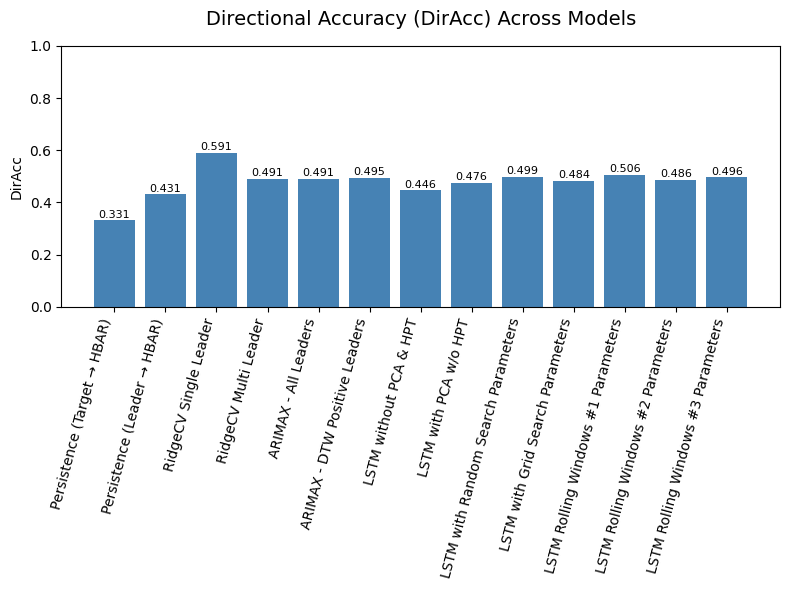

In [49]:
import matplotlib.pyplot as plt

# Bar chart for Directional Accuracy only
plt.figure(figsize=(8,6))
plt.bar(df_results["Model"], df_results["DirAcc"], color="steelblue")

# Formatting
plt.title("Directional Accuracy (DirAcc) Across Models", fontsize=14, pad=15)
plt.ylabel("DirAcc")
plt.ylim(0, 1)  # since DirAcc is a ratio between 0 and 1
plt.xticks(rotation=75, ha="right")

# Add value labels
for i, v in enumerate(df_results["DirAcc"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


# 6 Conclusion  
The rolling mean of log returns for HBARUSDT clearly demonstrates why forecasting this asset is highly problematic. Despite the application of multiple approaches - including baseline persistence models, Ridge regression, ARIMAX, and LSTM - the extreme volatility, abrupt regime shifts, and non-stationary behavior make it nearly impossible to capture consistent predictive patterns. The training period displays alternating calm and turbulent phases, while the test segment introduces yet another distinct regime, meaning past dynamics do not generalise to future movements. These characteristics underline the conclusion that even advanced machine learning and statistical methods struggle to outperform naive baselines in such environments. Ultimately, this supports the broader argument that cryptocurrency markets remain inherently unpredictable at this scale.

In [ ]:
target = "HBARUSDT"
rolling = filtered_returns_1H[target].rolling(window=720).mean()
# Split index at 80%
split_idx = int(len(rolling) * 0.8)
split_time = rolling.index[split_idx]
# Create figure
fig = go.Figure()
# Rolling mean line
fig.add_trace(go.Scatter(x=rolling.index, y=rolling, mode="lines", name="Rolling Mean (720h)", line=dict(width=2, color="steelblue")))
# test region (last 20%)
fig.add_vrect(x0=split_time, x1=rolling.index[-1], fillcolor="orange", opacity=0.2, layer="below", line_width=0, annotation_text="Test (20%)", annotation_position="top left")
# Zero reference line
fig.add_hline(y=0, line=dict(color="black", width=1.2))
# Layout styling
fig.update_layout(title=f"720h Rolling Mean of Log Returns - {target}", xaxis_title="Time", yaxis_title="Log Return (720h mean)", template="simple_white", hovermode="x unified",
                  width=1000, height=500, plot_bgcolor="#f9f9f9")
# Grid lines
fig.update_xaxes(showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.12)")
fig.show()